In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Library

In [2]:
import os, random, time, math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import umap.umap_ as umap

2025-08-23 20:05:32.403059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755979532.603190      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755979532.662483      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# SETTINGS

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_DIR = '/kaggle/working/'
DATA_DIR = '/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images'
os.makedirs(SAVE_DIR, exist_ok=True)
SEED = 42
BATCH_SIZE_SSL = 64
BATCH_SIZE_SUP = 64
EPOCHS_SSL = 2000
EPOCHS_LINEAR = 2000
IMG_SIZE = 224
LR_SSL = 3e-4
LR_LINEAR = 3e-4
BASE_EMA = 0.99
torch.manual_seed(SEED);
np.random.seed(SEED);
random.seed(SEED);
print(f"Using device: {DEVICE}")


Using device: cuda


# UTILS

In [4]:
def plot_curve(values, title, xlab="Epoch", ylab="Value"):
    plt.figure()
    plt.plot(range(1, len(values)+1), values)
    plt.title(title); plt.xlabel(xlab); plt.ylabel(ylab)
    plt.grid(True); plt.show()

# BYOL TRANSFORMATION

In [5]:
class BYOLTransform:
    """Return two strong augmented views of the same image."""
    def __init__(self, size=224):
        s = 1.0
        color_jitter = T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        self.t = T.Compose([
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])
    def __call__(self, x):
        return self.t(x), self.t(x)

# SUPERVISED TRANSFORM

In [6]:
SUP_TRANSFORM = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


# CONTRASTIVE DATASET

In [7]:
class PairDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, transform_pair):
        self.imgs = image_folder.imgs
        self.loader = image_folder.loader
        self.transform_pair = transform_pair
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        path, _ = self.imgs[idx]
        img = self.loader(path)
        if not isinstance(img, Image.Image):
            img = Image.open(path).convert("RGB")
        v1, v2 = self.transform_pair(img)
        return v1, v2

# DATA LOAD AND SPLIT (20-80)

In [8]:
full_sup = ImageFolder(root=DATA_DIR, transform=SUP_TRANSFORM)
CLASS_TO_IDX = full_sup.class_to_idx
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
NUM_CLASSES = len(CLASS_TO_IDX)
print("Classes:", CLASS_TO_IDX)

n_total = len(full_sup)
n_train_ssl = int(0.2 * n_total)
n_test = n_total - n_train_ssl
ssl_train_sup, test_sup = random_split(full_sup, [n_train_ssl, n_test], generator=torch.Generator().manual_seed(SEED))
ssl_train_indices = ssl_train_sup.indices if hasattr(ssl_train_sup, 'indices') else list(range(n_train_ssl))

# BYOL unlabeled loader (pairs)
raw_folder = ImageFolder(root=DATA_DIR)  # raw loader (no transforms)
ssl_contrast = PairDataset(raw_folder, BYOLTransform(size=IMG_SIZE))
ssl_train_loader = DataLoader(Subset(ssl_contrast, ssl_train_indices),
                              batch_size=BATCH_SIZE_SSL, shuffle=True, num_workers=2, drop_last=True)

# Supervised loaders (for downstream & test)
train_sup_loader = DataLoader(Subset(full_sup, ssl_train_indices),
                              batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
test_loader = DataLoader(test_sup, batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

# Create train/val split (from the 90%) for downstream
val_ratio = 0.2
n_train_down = int((1 - val_ratio) * len(ssl_train_indices))
n_val_down = len(ssl_train_indices) - n_train_down
train_down_indices, val_down_indices = random_split(ssl_train_indices, [n_train_down, n_val_down],
                                                    generator=torch.Generator().manual_seed(SEED))
train_down_loader = DataLoader(Subset(full_sup, train_down_indices),
                               batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
val_down_loader = DataLoader(Subset(full_sup, val_down_indices),
                             batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

print(f"Total: {n_total} | SSL Train: {len(ssl_train_indices)} | Test: {len(test_sup)}")


Classes: {'Monkeypox_augmented': 0, 'Others_augmented': 1}
Total: 3192 | SSL Train: 638 | Test: 2554


# BYOL MODEL

In [9]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=4096, out_dim=256, use_bn=True):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim)]
        if use_bn: layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class BYOLNet(nn.Module):
    """
    Online network: encoder -> projector -> predictor
    Target network: encoder -> projector (EMA)
    """
    def __init__(self, proj_dim=256, feat_dim=2048):
        super().__init__()
        # Encoder (ResNet-50)
        enc = models.resnet50(weights=None)
        enc.fc = nn.Identity()              # 2048-D features
        self.encoder = enc
        # Projector & Predictor
        self.projector = MLP(in_dim=feat_dim, hidden_dim=4096, out_dim=proj_dim, use_bn=True)
        self.predictor = MLP(in_dim=proj_dim, hidden_dim=4096, out_dim=proj_dim, use_bn=True)

    def forward(self, x):
        h = self.encoder(x)                 # [B, 2048]
        z = self.projector(h)               # [B, proj_dim]
        p = self.predictor(z)               # [B, proj_dim]
        # L2 normalize for cosine similarity
        z = F.normalize(z, dim=1)
        p = F.normalize(p, dim=1)
        return h, z, p

@torch.no_grad()
def momentum_update(online: BYOLNet, target: BYOLNet, m: float):
    for p_o, p_t in zip(online.parameters(), target.parameters()):
        p_t.data = p_t.data * m + p_o.data * (1.0 - m)

def byol_loss(p1, p2_t, p2, p1_t):
    """
    Negative cosine similarity between online predictions and opposite target projections.
    Loss = 2 - 2 * cos(p1, z2_t) + 2 - 2 * cos(p2, z1_t)
    """
    return 2 - 2 * (p1 * p2_t).sum(dim=1).mean() + 2 - 2 * (p2 * p1_t).sum(dim=1).mean()

# TRAIN BYOL

In [10]:
online = BYOLNet(proj_dim=256, feat_dim=2048).to(DEVICE)
target = BYOLNet(proj_dim=256, feat_dim=2048).to(DEVICE)
target.load_state_dict(online.state_dict())     # init target = online

opt_ssl = torch.optim.Adam(online.parameters(), lr=LR_SSL)
ssl_loss_history = []

print("Starting BYOL pretraining...")
global_step = 0
for epoch in range(1, EPOCHS_SSL + 1):
    online.train()
    running = 0.0
    for v1, v2 in tqdm(ssl_train_loader, desc=f"BYOL Epoch {epoch}/{EPOCHS_SSL}"):
        v1, v2 = v1.to(DEVICE), v2.to(DEVICE)

        # Online forward
        _, z1_o, p1_o = online(v1)
        _, z2_o, p2_o = online(v2)

        # Target forward (no grad)
        with torch.no_grad():
            _, z1_t, _ = target(v1)
            _, z2_t, _ = target(v2)

        # Loss
        loss = byol_loss(p1_o, z2_t, p2_o, z1_t)

        opt_ssl.zero_grad()
        loss.backward()
        opt_ssl.step()
        
        m = 1 - (1 - BASE_EMA) * (math.cos(math.pi * global_step / (EPOCHS_SSL * len(ssl_train_loader))) + 1) / 2
        momentum_update(online, target, m)
        global_step += 1

        running += loss.item() * v1.size(0)

    epoch_loss = running / (len(ssl_train_loader.dataset))
    ssl_loss_history.append(epoch_loss)
    print(f"BYOL Epoch {epoch}: loss={epoch_loss:.4f}")

# Save encoder weights (only the backbone)
torch.save(online.encoder.state_dict(), os.path.join(SAVE_DIR, "byol_resnet50_encoder.pth"))
print("Saved BYOL encoder to:", os.path.join(SAVE_DIR, "byol_resnet50_encoder.pth"))


Starting BYOL pretraining...


BYOL Epoch 1/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1: loss=1.6289


BYOL Epoch 2/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 2: loss=1.3390


BYOL Epoch 3/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 3: loss=1.4294


BYOL Epoch 4/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 4: loss=1.3161


BYOL Epoch 5/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 5: loss=1.2289


BYOL Epoch 6/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 6: loss=1.2129


BYOL Epoch 7/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 7: loss=1.1153


BYOL Epoch 8/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 8: loss=1.0306


BYOL Epoch 9/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 9: loss=0.9956


BYOL Epoch 10/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 10: loss=0.9907


BYOL Epoch 11/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 11: loss=0.9851


BYOL Epoch 12/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 12: loss=0.9387


BYOL Epoch 13/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 13: loss=0.9788


BYOL Epoch 14/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 14: loss=0.9372


BYOL Epoch 15/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 15: loss=0.8885


BYOL Epoch 16/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 16: loss=0.8697


BYOL Epoch 17/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 17: loss=0.8186


BYOL Epoch 18/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 18: loss=0.8041


BYOL Epoch 19/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 19: loss=0.7788


BYOL Epoch 20/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 20: loss=0.7434


BYOL Epoch 21/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 21: loss=0.7080


BYOL Epoch 22/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 22: loss=0.6729


BYOL Epoch 23/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 23: loss=0.6874


BYOL Epoch 24/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 24: loss=0.6957


BYOL Epoch 25/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 25: loss=0.6634


BYOL Epoch 26/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 26: loss=0.6681


BYOL Epoch 27/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 27: loss=0.6785


BYOL Epoch 28/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 28: loss=0.5769


BYOL Epoch 29/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 29: loss=0.6318


BYOL Epoch 30/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 30: loss=0.6095


BYOL Epoch 31/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 31: loss=0.6318


BYOL Epoch 32/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 32: loss=0.6041


BYOL Epoch 33/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 33: loss=0.6043


BYOL Epoch 34/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 34: loss=0.6272


BYOL Epoch 35/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 35: loss=0.6241


BYOL Epoch 36/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 36: loss=0.5866


BYOL Epoch 37/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 37: loss=0.6548


BYOL Epoch 38/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 38: loss=0.6543


BYOL Epoch 39/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 39: loss=0.5729


BYOL Epoch 40/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 40: loss=0.6797


BYOL Epoch 41/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 41: loss=0.6007


BYOL Epoch 42/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 42: loss=0.5969


BYOL Epoch 43/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 43: loss=0.6619


BYOL Epoch 44/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 44: loss=0.6482


BYOL Epoch 45/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 45: loss=0.6626


BYOL Epoch 46/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 46: loss=0.6555


BYOL Epoch 47/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 47: loss=0.6383


BYOL Epoch 48/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 48: loss=0.6912


BYOL Epoch 49/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 49: loss=0.6635


BYOL Epoch 50/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 50: loss=0.6487


BYOL Epoch 51/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 51: loss=0.6840


BYOL Epoch 52/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 52: loss=0.6430


BYOL Epoch 53/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 53: loss=0.6710


BYOL Epoch 54/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 54: loss=0.6231


BYOL Epoch 55/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 55: loss=0.7181


BYOL Epoch 56/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 56: loss=0.6825


BYOL Epoch 57/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 57: loss=0.6992


BYOL Epoch 58/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 58: loss=0.6976


BYOL Epoch 59/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 59: loss=0.7337


BYOL Epoch 60/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 60: loss=0.7236


BYOL Epoch 61/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 61: loss=0.7390


BYOL Epoch 62/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 62: loss=0.6936


BYOL Epoch 63/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 63: loss=0.7224


BYOL Epoch 64/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 64: loss=0.7038


BYOL Epoch 65/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 65: loss=0.6934


BYOL Epoch 66/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 66: loss=0.6950


BYOL Epoch 67/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 67: loss=0.7248


BYOL Epoch 68/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 68: loss=0.7555


BYOL Epoch 69/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 69: loss=0.7414


BYOL Epoch 70/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 70: loss=0.7468


BYOL Epoch 71/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 71: loss=0.7377


BYOL Epoch 72/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 72: loss=0.7808


BYOL Epoch 73/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 73: loss=0.7771


BYOL Epoch 74/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 74: loss=0.7124


BYOL Epoch 75/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 75: loss=0.7628


BYOL Epoch 76/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 76: loss=0.7793


BYOL Epoch 77/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 77: loss=0.7618


BYOL Epoch 78/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 78: loss=0.7731


BYOL Epoch 79/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 79: loss=0.7927


BYOL Epoch 80/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 80: loss=0.7461


BYOL Epoch 81/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 81: loss=0.8079


BYOL Epoch 82/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 82: loss=0.7639


BYOL Epoch 83/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 83: loss=0.7495


BYOL Epoch 84/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 84: loss=0.8520


BYOL Epoch 85/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 85: loss=0.7665


BYOL Epoch 86/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 86: loss=0.7638


BYOL Epoch 87/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 87: loss=0.7775


BYOL Epoch 88/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 88: loss=0.8009


BYOL Epoch 89/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 89: loss=0.7972


BYOL Epoch 90/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 90: loss=0.7820


BYOL Epoch 91/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 91: loss=0.7989


BYOL Epoch 92/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 92: loss=0.6835


BYOL Epoch 93/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 93: loss=0.8243


BYOL Epoch 94/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 94: loss=0.7889


BYOL Epoch 95/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 95: loss=0.7836


BYOL Epoch 96/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 96: loss=0.8049


BYOL Epoch 97/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 97: loss=0.7969


BYOL Epoch 98/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 98: loss=0.7387


BYOL Epoch 99/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 99: loss=0.7121


BYOL Epoch 100/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 100: loss=0.7811


BYOL Epoch 101/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 101: loss=0.7224


BYOL Epoch 102/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 102: loss=0.6924


BYOL Epoch 103/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 103: loss=0.7906


BYOL Epoch 104/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 104: loss=0.7628


BYOL Epoch 105/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 105: loss=0.7241


BYOL Epoch 106/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 106: loss=0.7340


BYOL Epoch 107/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 107: loss=0.7235


BYOL Epoch 108/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 108: loss=0.7939


BYOL Epoch 109/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 109: loss=0.7254


BYOL Epoch 110/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 110: loss=0.8242


BYOL Epoch 111/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 111: loss=0.7128


BYOL Epoch 112/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 112: loss=0.6609


BYOL Epoch 113/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 113: loss=0.7437


BYOL Epoch 114/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 114: loss=0.7400


BYOL Epoch 115/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 115: loss=0.6860


BYOL Epoch 116/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 116: loss=0.6477


BYOL Epoch 117/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 117: loss=0.7469


BYOL Epoch 118/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 118: loss=0.7297


BYOL Epoch 119/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 119: loss=0.6689


BYOL Epoch 120/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 120: loss=0.7383


BYOL Epoch 121/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 121: loss=0.7117


BYOL Epoch 122/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 122: loss=0.6962


BYOL Epoch 123/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 123: loss=0.6821


BYOL Epoch 124/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 124: loss=0.6995


BYOL Epoch 125/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 125: loss=0.7081


BYOL Epoch 126/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 126: loss=0.6454


BYOL Epoch 127/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 127: loss=0.6606


BYOL Epoch 128/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 128: loss=0.6422


BYOL Epoch 129/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 129: loss=0.5879


BYOL Epoch 130/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 130: loss=0.7211


BYOL Epoch 131/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 131: loss=0.6517


BYOL Epoch 132/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 132: loss=0.6630


BYOL Epoch 133/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 133: loss=0.6615


BYOL Epoch 134/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 134: loss=0.6962


BYOL Epoch 135/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 135: loss=0.6541


BYOL Epoch 136/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 136: loss=0.7048


BYOL Epoch 137/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 137: loss=0.6276


BYOL Epoch 138/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 138: loss=0.7608


BYOL Epoch 139/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 139: loss=0.6827


BYOL Epoch 140/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 140: loss=0.6651


BYOL Epoch 141/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 141: loss=0.6394


BYOL Epoch 142/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 142: loss=0.6566


BYOL Epoch 143/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 143: loss=0.6957


BYOL Epoch 144/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 144: loss=0.6176


BYOL Epoch 145/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 145: loss=0.6553


BYOL Epoch 146/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 146: loss=0.6737


BYOL Epoch 147/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 147: loss=0.6213


BYOL Epoch 148/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 148: loss=0.6512


BYOL Epoch 149/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 149: loss=0.5605


BYOL Epoch 150/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 150: loss=0.6250


BYOL Epoch 151/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 151: loss=0.6503


BYOL Epoch 152/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 152: loss=0.6489


BYOL Epoch 153/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 153: loss=0.6085


BYOL Epoch 154/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 154: loss=0.6178


BYOL Epoch 155/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 155: loss=0.6175


BYOL Epoch 156/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 156: loss=0.6250


BYOL Epoch 157/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 157: loss=0.5989


BYOL Epoch 158/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 158: loss=0.6432


BYOL Epoch 159/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 159: loss=0.6104


BYOL Epoch 160/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 160: loss=0.6245


BYOL Epoch 161/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 161: loss=0.5802


BYOL Epoch 162/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 162: loss=0.5466


BYOL Epoch 163/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 163: loss=0.5764


BYOL Epoch 164/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 164: loss=0.5842


BYOL Epoch 165/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 165: loss=0.5639


BYOL Epoch 166/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 166: loss=0.5681


BYOL Epoch 167/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 167: loss=0.5746


BYOL Epoch 168/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 168: loss=0.5615


BYOL Epoch 169/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 169: loss=0.5536


BYOL Epoch 170/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 170: loss=0.5803


BYOL Epoch 171/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 171: loss=0.5599


BYOL Epoch 172/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 172: loss=0.5601


BYOL Epoch 173/2000: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


BYOL Epoch 173: loss=0.5650


BYOL Epoch 174/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 174: loss=0.5753


BYOL Epoch 175/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 175: loss=0.5722


BYOL Epoch 176/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 176: loss=0.5549


BYOL Epoch 177/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 177: loss=0.5396


BYOL Epoch 178/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 178: loss=0.5724


BYOL Epoch 179/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 179: loss=0.5311


BYOL Epoch 180/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 180: loss=0.5329


BYOL Epoch 181/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 181: loss=0.5702


BYOL Epoch 182/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 182: loss=0.5159


BYOL Epoch 183/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 183: loss=0.5680


BYOL Epoch 184/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 184: loss=0.5685


BYOL Epoch 185/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 185: loss=0.5394


BYOL Epoch 186/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 186: loss=0.5774


BYOL Epoch 187/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 187: loss=0.5306


BYOL Epoch 188/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 188: loss=0.5695


BYOL Epoch 189/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 189: loss=0.5615


BYOL Epoch 190/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 190: loss=0.5299


BYOL Epoch 191/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 191: loss=0.5883


BYOL Epoch 192/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 192: loss=0.5002


BYOL Epoch 193/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 193: loss=0.5201


BYOL Epoch 194/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 194: loss=0.4999


BYOL Epoch 195/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 195: loss=0.5485


BYOL Epoch 196/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 196: loss=0.5289


BYOL Epoch 197/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 197: loss=0.4743


BYOL Epoch 198/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 198: loss=0.5421


BYOL Epoch 199/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 199: loss=0.4993


BYOL Epoch 200/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 200: loss=0.5531


BYOL Epoch 201/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 201: loss=0.5065


BYOL Epoch 202/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 202: loss=0.4800


BYOL Epoch 203/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 203: loss=0.5141


BYOL Epoch 204/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 204: loss=0.4613


BYOL Epoch 205/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 205: loss=0.5072


BYOL Epoch 206/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 206: loss=0.4829


BYOL Epoch 207/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 207: loss=0.4829


BYOL Epoch 208/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 208: loss=0.4726


BYOL Epoch 209/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 209: loss=0.4551


BYOL Epoch 210/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 210: loss=0.5198


BYOL Epoch 211/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 211: loss=0.4808


BYOL Epoch 212/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 212: loss=0.4963


BYOL Epoch 213/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 213: loss=0.4776


BYOL Epoch 214/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 214: loss=0.4684


BYOL Epoch 215/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 215: loss=0.4733


BYOL Epoch 216/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 216: loss=0.4720


BYOL Epoch 217/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 217: loss=0.4619


BYOL Epoch 218/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 218: loss=0.4524


BYOL Epoch 219/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 219: loss=0.4377


BYOL Epoch 220/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 220: loss=0.4344


BYOL Epoch 221/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 221: loss=0.4408


BYOL Epoch 222/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 222: loss=0.4398


BYOL Epoch 223/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 223: loss=0.4675


BYOL Epoch 224/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 224: loss=0.4795


BYOL Epoch 225/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 225: loss=0.4443


BYOL Epoch 226/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 226: loss=0.4810


BYOL Epoch 227/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 227: loss=0.4872


BYOL Epoch 228/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 228: loss=0.4878


BYOL Epoch 229/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 229: loss=0.4748


BYOL Epoch 230/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 230: loss=0.4049


BYOL Epoch 231/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 231: loss=0.4694


BYOL Epoch 232/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 232: loss=0.4475


BYOL Epoch 233/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 233: loss=0.4397


BYOL Epoch 234/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 234: loss=0.5018


BYOL Epoch 235/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 235: loss=0.4829


BYOL Epoch 236/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 236: loss=0.4565


BYOL Epoch 237/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 237: loss=0.5101


BYOL Epoch 238/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 238: loss=0.4436


BYOL Epoch 239/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 239: loss=0.4661


BYOL Epoch 240/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 240: loss=0.4354


BYOL Epoch 241/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 241: loss=0.4435


BYOL Epoch 242/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 242: loss=0.4126


BYOL Epoch 243/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 243: loss=0.4547


BYOL Epoch 244/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 244: loss=0.4153


BYOL Epoch 245/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 245: loss=0.3958


BYOL Epoch 246/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 246: loss=0.3884


BYOL Epoch 247/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 247: loss=0.5021


BYOL Epoch 248/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 248: loss=0.4695


BYOL Epoch 249/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 249: loss=0.3899


BYOL Epoch 250/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 250: loss=0.4464


BYOL Epoch 251/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 251: loss=0.4581


BYOL Epoch 252/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 252: loss=0.4602


BYOL Epoch 253/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 253: loss=0.4892


BYOL Epoch 254/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 254: loss=0.4176


BYOL Epoch 255/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 255: loss=0.4343


BYOL Epoch 256/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 256: loss=0.4143


BYOL Epoch 257/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 257: loss=0.4020


BYOL Epoch 258/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 258: loss=0.4423


BYOL Epoch 259/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 259: loss=0.4165


BYOL Epoch 260/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 260: loss=0.4016


BYOL Epoch 261/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 261: loss=0.4288


BYOL Epoch 262/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 262: loss=0.4273


BYOL Epoch 263/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 263: loss=0.4139


BYOL Epoch 264/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 264: loss=0.4382


BYOL Epoch 265/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 265: loss=0.4220


BYOL Epoch 266/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 266: loss=0.4247


BYOL Epoch 267/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 267: loss=0.4322


BYOL Epoch 268/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 268: loss=0.4140


BYOL Epoch 269/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 269: loss=0.3968


BYOL Epoch 270/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 270: loss=0.3776


BYOL Epoch 271/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 271: loss=0.4053


BYOL Epoch 272/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 272: loss=0.4139


BYOL Epoch 273/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 273: loss=0.4294


BYOL Epoch 274/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 274: loss=0.4290


BYOL Epoch 275/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 275: loss=0.4364


BYOL Epoch 276/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 276: loss=0.4079


BYOL Epoch 277/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 277: loss=0.4217


BYOL Epoch 278/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 278: loss=0.4180


BYOL Epoch 279/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 279: loss=0.4216


BYOL Epoch 280/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 280: loss=0.3633


BYOL Epoch 281/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 281: loss=0.3904


BYOL Epoch 282/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 282: loss=0.4004


BYOL Epoch 283/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 283: loss=0.4441


BYOL Epoch 284/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 284: loss=0.3655


BYOL Epoch 285/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 285: loss=0.3981


BYOL Epoch 286/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 286: loss=0.3844


BYOL Epoch 287/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 287: loss=0.3998


BYOL Epoch 288/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 288: loss=0.4437


BYOL Epoch 289/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 289: loss=0.4044


BYOL Epoch 290/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 290: loss=0.3689


BYOL Epoch 291/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 291: loss=0.4170


BYOL Epoch 292/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 292: loss=0.4080


BYOL Epoch 293/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 293: loss=0.3992


BYOL Epoch 294/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 294: loss=0.4688


BYOL Epoch 295/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 295: loss=0.3868


BYOL Epoch 296/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 296: loss=0.4021


BYOL Epoch 297/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 297: loss=0.4251


BYOL Epoch 298/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 298: loss=0.3960


BYOL Epoch 299/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 299: loss=0.3490


BYOL Epoch 300/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 300: loss=0.4013


BYOL Epoch 301/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 301: loss=0.4180


BYOL Epoch 302/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 302: loss=0.4140


BYOL Epoch 303/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 303: loss=0.4053


BYOL Epoch 304/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 304: loss=0.3790


BYOL Epoch 305/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 305: loss=0.4165


BYOL Epoch 306/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 306: loss=0.3977


BYOL Epoch 307/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 307: loss=0.4045


BYOL Epoch 308/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 308: loss=0.3635


BYOL Epoch 309/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 309: loss=0.3830


BYOL Epoch 310/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 310: loss=0.3677


BYOL Epoch 311/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 311: loss=0.3575


BYOL Epoch 312/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 312: loss=0.3413


BYOL Epoch 313/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 313: loss=0.3946


BYOL Epoch 314/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 314: loss=0.4014


BYOL Epoch 315/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 315: loss=0.3740


BYOL Epoch 316/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 316: loss=0.3618


BYOL Epoch 317/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 317: loss=0.4182


BYOL Epoch 318/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 318: loss=0.3952


BYOL Epoch 319/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 319: loss=0.3642


BYOL Epoch 320/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 320: loss=0.3760


BYOL Epoch 321/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 321: loss=0.3805


BYOL Epoch 322/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 322: loss=0.3711


BYOL Epoch 323/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 323: loss=0.3901


BYOL Epoch 324/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 324: loss=0.3762


BYOL Epoch 325/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 325: loss=0.3589


BYOL Epoch 326/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 326: loss=0.3626


BYOL Epoch 327/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 327: loss=0.3587


BYOL Epoch 328/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 328: loss=0.3742


BYOL Epoch 329/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 329: loss=0.3524


BYOL Epoch 330/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 330: loss=0.3363


BYOL Epoch 331/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 331: loss=0.3324


BYOL Epoch 332/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 332: loss=0.3640


BYOL Epoch 333/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 333: loss=0.3267


BYOL Epoch 334/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 334: loss=0.3658


BYOL Epoch 335/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 335: loss=0.3752


BYOL Epoch 336/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 336: loss=0.3298


BYOL Epoch 337/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 337: loss=0.3239


BYOL Epoch 338/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 338: loss=0.4340


BYOL Epoch 339/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 339: loss=0.3644


BYOL Epoch 340/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 340: loss=0.3590


BYOL Epoch 341/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 341: loss=0.3617


BYOL Epoch 342/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 342: loss=0.3513


BYOL Epoch 343/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 343: loss=0.3753


BYOL Epoch 344/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 344: loss=0.3186


BYOL Epoch 345/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 345: loss=0.3585


BYOL Epoch 346/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 346: loss=0.3497


BYOL Epoch 347/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 347: loss=0.3525


BYOL Epoch 348/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 348: loss=0.3227


BYOL Epoch 349/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 349: loss=0.3485


BYOL Epoch 350/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 350: loss=0.3442


BYOL Epoch 351/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 351: loss=0.3431


BYOL Epoch 352/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 352: loss=0.3256


BYOL Epoch 353/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 353: loss=0.3250


BYOL Epoch 354/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 354: loss=0.3468


BYOL Epoch 355/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 355: loss=0.3433


BYOL Epoch 356/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 356: loss=0.3717


BYOL Epoch 357/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 357: loss=0.3556


BYOL Epoch 358/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 358: loss=0.3523


BYOL Epoch 359/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 359: loss=0.3416


BYOL Epoch 360/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 360: loss=0.3099


BYOL Epoch 361/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 361: loss=0.3628


BYOL Epoch 362/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 362: loss=0.3417


BYOL Epoch 363/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 363: loss=0.3044


BYOL Epoch 364/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 364: loss=0.3153


BYOL Epoch 365/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 365: loss=0.3044


BYOL Epoch 366/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 366: loss=0.3088


BYOL Epoch 367/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 367: loss=0.3271


BYOL Epoch 368/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 368: loss=0.3157


BYOL Epoch 369/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 369: loss=0.3602


BYOL Epoch 370/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 370: loss=0.3925


BYOL Epoch 371/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 371: loss=0.3670


BYOL Epoch 372/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 372: loss=0.3708


BYOL Epoch 373/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 373: loss=0.3487


BYOL Epoch 374/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 374: loss=0.3485


BYOL Epoch 375/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 375: loss=0.3649


BYOL Epoch 376/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 376: loss=0.3311


BYOL Epoch 377/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 377: loss=0.3697


BYOL Epoch 378/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 378: loss=0.3279


BYOL Epoch 379/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 379: loss=0.3724


BYOL Epoch 380/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 380: loss=0.3451


BYOL Epoch 381/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 381: loss=0.3770


BYOL Epoch 382/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 382: loss=0.3188


BYOL Epoch 383/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 383: loss=0.3307


BYOL Epoch 384/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 384: loss=0.3235


BYOL Epoch 385/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 385: loss=0.3598


BYOL Epoch 386/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 386: loss=0.3432


BYOL Epoch 387/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 387: loss=0.3409


BYOL Epoch 388/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 388: loss=0.3141


BYOL Epoch 389/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 389: loss=0.3151


BYOL Epoch 390/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 390: loss=0.3621


BYOL Epoch 391/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 391: loss=0.3231


BYOL Epoch 392/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 392: loss=0.3427


BYOL Epoch 393/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 393: loss=0.3354


BYOL Epoch 394/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 394: loss=0.3078


BYOL Epoch 395/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 395: loss=0.3608


BYOL Epoch 396/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 396: loss=0.3551


BYOL Epoch 397/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 397: loss=0.3202


BYOL Epoch 398/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 398: loss=0.3542


BYOL Epoch 399/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 399: loss=0.3676


BYOL Epoch 400/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 400: loss=0.3311


BYOL Epoch 401/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 401: loss=0.3554


BYOL Epoch 402/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 402: loss=0.3554


BYOL Epoch 403/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 403: loss=0.3309


BYOL Epoch 404/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 404: loss=0.3827


BYOL Epoch 405/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 405: loss=0.3719


BYOL Epoch 406/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 406: loss=0.3571


BYOL Epoch 407/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 407: loss=0.3686


BYOL Epoch 408/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 408: loss=0.3248


BYOL Epoch 409/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 409: loss=0.3183


BYOL Epoch 410/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 410: loss=0.3034


BYOL Epoch 411/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 411: loss=0.3274


BYOL Epoch 412/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 412: loss=0.3074


BYOL Epoch 413/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 413: loss=0.3063


BYOL Epoch 414/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 414: loss=0.2949


BYOL Epoch 415/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 415: loss=0.3258


BYOL Epoch 416/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 416: loss=0.3485


BYOL Epoch 417/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 417: loss=0.3395


BYOL Epoch 418/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 418: loss=0.3291


BYOL Epoch 419/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 419: loss=0.3599


BYOL Epoch 420/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 420: loss=0.3130


BYOL Epoch 421/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 421: loss=0.3157


BYOL Epoch 422/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 422: loss=0.3288


BYOL Epoch 423/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 423: loss=0.3098


BYOL Epoch 424/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 424: loss=0.3071


BYOL Epoch 425/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 425: loss=0.3287


BYOL Epoch 426/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 426: loss=0.2953


BYOL Epoch 427/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 427: loss=0.3071


BYOL Epoch 428/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 428: loss=0.3391


BYOL Epoch 429/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 429: loss=0.3554


BYOL Epoch 430/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 430: loss=0.3127


BYOL Epoch 431/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 431: loss=0.3256


BYOL Epoch 432/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 432: loss=0.3281


BYOL Epoch 433/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 433: loss=0.3073


BYOL Epoch 434/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 434: loss=0.3781


BYOL Epoch 435/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 435: loss=0.3096


BYOL Epoch 436/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 436: loss=0.3341


BYOL Epoch 437/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 437: loss=0.2954


BYOL Epoch 438/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 438: loss=0.2994


BYOL Epoch 439/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 439: loss=0.3583


BYOL Epoch 440/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 440: loss=0.2877


BYOL Epoch 441/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 441: loss=0.3342


BYOL Epoch 442/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 442: loss=0.2978


BYOL Epoch 443/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 443: loss=0.3170


BYOL Epoch 444/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 444: loss=0.3552


BYOL Epoch 445/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 445: loss=0.3391


BYOL Epoch 446/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 446: loss=0.3311


BYOL Epoch 447/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 447: loss=0.3385


BYOL Epoch 448/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 448: loss=0.3158


BYOL Epoch 449/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 449: loss=0.3425


BYOL Epoch 450/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 450: loss=0.3344


BYOL Epoch 451/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 451: loss=0.3083


BYOL Epoch 452/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 452: loss=0.2993


BYOL Epoch 453/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 453: loss=0.3203


BYOL Epoch 454/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 454: loss=0.3330


BYOL Epoch 455/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 455: loss=0.3447


BYOL Epoch 456/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 456: loss=0.2992


BYOL Epoch 457/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 457: loss=0.3282


BYOL Epoch 458/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 458: loss=0.3222


BYOL Epoch 459/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 459: loss=0.3358


BYOL Epoch 460/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 460: loss=0.3150


BYOL Epoch 461/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 461: loss=0.3606


BYOL Epoch 462/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 462: loss=0.3199


BYOL Epoch 463/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 463: loss=0.3070


BYOL Epoch 464/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 464: loss=0.3143


BYOL Epoch 465/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 465: loss=0.3567


BYOL Epoch 466/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 466: loss=0.3050


BYOL Epoch 467/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 467: loss=0.3601


BYOL Epoch 468/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 468: loss=0.3385


BYOL Epoch 469/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 469: loss=0.3407


BYOL Epoch 470/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 470: loss=0.3488


BYOL Epoch 471/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 471: loss=0.3253


BYOL Epoch 472/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 472: loss=0.3164


BYOL Epoch 473/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 473: loss=0.2962


BYOL Epoch 474/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 474: loss=0.3057


BYOL Epoch 475/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 475: loss=0.3108


BYOL Epoch 476/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 476: loss=0.3251


BYOL Epoch 477/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 477: loss=0.3287


BYOL Epoch 478/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 478: loss=0.3403


BYOL Epoch 479/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 479: loss=0.3308


BYOL Epoch 480/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 480: loss=0.3173


BYOL Epoch 481/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 481: loss=0.3233


BYOL Epoch 482/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 482: loss=0.3156


BYOL Epoch 483/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 483: loss=0.2983


BYOL Epoch 484/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 484: loss=0.3254


BYOL Epoch 485/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 485: loss=0.2806


BYOL Epoch 486/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 486: loss=0.2872


BYOL Epoch 487/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 487: loss=0.3031


BYOL Epoch 488/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 488: loss=0.2953


BYOL Epoch 489/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 489: loss=0.3240


BYOL Epoch 490/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 490: loss=0.3293


BYOL Epoch 491/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 491: loss=0.2824


BYOL Epoch 492/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 492: loss=0.3110


BYOL Epoch 493/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 493: loss=0.3144


BYOL Epoch 494/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 494: loss=0.3092


BYOL Epoch 495/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 495: loss=0.3067


BYOL Epoch 496/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 496: loss=0.3085


BYOL Epoch 497/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 497: loss=0.2839


BYOL Epoch 498/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 498: loss=0.2905


BYOL Epoch 499/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 499: loss=0.2897


BYOL Epoch 500/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 500: loss=0.3044


BYOL Epoch 501/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 501: loss=0.3327


BYOL Epoch 502/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 502: loss=0.3051


BYOL Epoch 503/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 503: loss=0.2865


BYOL Epoch 504/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 504: loss=0.3114


BYOL Epoch 505/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 505: loss=0.3278


BYOL Epoch 506/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 506: loss=0.3152


BYOL Epoch 507/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 507: loss=0.3196


BYOL Epoch 508/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 508: loss=0.2883


BYOL Epoch 509/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 509: loss=0.3104


BYOL Epoch 510/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 510: loss=0.3005


BYOL Epoch 511/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 511: loss=0.3044


BYOL Epoch 512/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 512: loss=0.2877


BYOL Epoch 513/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 513: loss=0.2873


BYOL Epoch 514/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 514: loss=0.2964


BYOL Epoch 515/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 515: loss=0.3305


BYOL Epoch 516/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 516: loss=0.3230


BYOL Epoch 517/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 517: loss=0.3119


BYOL Epoch 518/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 518: loss=0.3269


BYOL Epoch 519/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 519: loss=0.3178


BYOL Epoch 520/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 520: loss=0.2915


BYOL Epoch 521/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 521: loss=0.3086


BYOL Epoch 522/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 522: loss=0.2816


BYOL Epoch 523/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 523: loss=0.2961


BYOL Epoch 524/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 524: loss=0.3035


BYOL Epoch 525/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 525: loss=0.3233


BYOL Epoch 526/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 526: loss=0.3101


BYOL Epoch 527/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 527: loss=0.3294


BYOL Epoch 528/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 528: loss=0.3187


BYOL Epoch 529/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 529: loss=0.2705


BYOL Epoch 530/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 530: loss=0.2730


BYOL Epoch 531/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 531: loss=0.2474


BYOL Epoch 532/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 532: loss=0.2828


BYOL Epoch 533/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 533: loss=0.2983


BYOL Epoch 534/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 534: loss=0.2917


BYOL Epoch 535/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 535: loss=0.2940


BYOL Epoch 536/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 536: loss=0.2959


BYOL Epoch 537/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 537: loss=0.2926


BYOL Epoch 538/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 538: loss=0.3153


BYOL Epoch 539/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 539: loss=0.2774


BYOL Epoch 540/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 540: loss=0.2946


BYOL Epoch 541/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 541: loss=0.2511


BYOL Epoch 542/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 542: loss=0.2864


BYOL Epoch 543/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 543: loss=0.3003


BYOL Epoch 544/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 544: loss=0.3303


BYOL Epoch 545/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 545: loss=0.2866


BYOL Epoch 546/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 546: loss=0.3104


BYOL Epoch 547/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 547: loss=0.3104


BYOL Epoch 548/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 548: loss=0.2903


BYOL Epoch 549/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 549: loss=0.3062


BYOL Epoch 550/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 550: loss=0.2747


BYOL Epoch 551/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 551: loss=0.2771


BYOL Epoch 552/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 552: loss=0.2718


BYOL Epoch 553/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 553: loss=0.2733


BYOL Epoch 554/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 554: loss=0.2905


BYOL Epoch 555/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 555: loss=0.2965


BYOL Epoch 556/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 556: loss=0.2655


BYOL Epoch 557/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 557: loss=0.2830


BYOL Epoch 558/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 558: loss=0.2627


BYOL Epoch 559/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 559: loss=0.2964


BYOL Epoch 560/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 560: loss=0.2647


BYOL Epoch 561/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 561: loss=0.2768


BYOL Epoch 562/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 562: loss=0.2436


BYOL Epoch 563/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 563: loss=0.2934


BYOL Epoch 564/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 564: loss=0.2712


BYOL Epoch 565/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 565: loss=0.2865


BYOL Epoch 566/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 566: loss=0.2915


BYOL Epoch 567/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 567: loss=0.2953


BYOL Epoch 568/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 568: loss=0.3090


BYOL Epoch 569/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 569: loss=0.2756


BYOL Epoch 570/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 570: loss=0.2910


BYOL Epoch 571/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 571: loss=0.2868


BYOL Epoch 572/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 572: loss=0.2699


BYOL Epoch 573/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 573: loss=0.2621


BYOL Epoch 574/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 574: loss=0.2802


BYOL Epoch 575/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 575: loss=0.2691


BYOL Epoch 576/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 576: loss=0.2982


BYOL Epoch 577/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 577: loss=0.2908


BYOL Epoch 578/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 578: loss=0.2673


BYOL Epoch 579/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 579: loss=0.2659


BYOL Epoch 580/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 580: loss=0.2824


BYOL Epoch 581/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 581: loss=0.2802


BYOL Epoch 582/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 582: loss=0.2685


BYOL Epoch 583/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 583: loss=0.2794


BYOL Epoch 584/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 584: loss=0.2647


BYOL Epoch 585/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 585: loss=0.2643


BYOL Epoch 586/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 586: loss=0.3151


BYOL Epoch 587/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 587: loss=0.2847


BYOL Epoch 588/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 588: loss=0.2668


BYOL Epoch 589/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 589: loss=0.2892


BYOL Epoch 590/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 590: loss=0.3104


BYOL Epoch 591/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 591: loss=0.2497


BYOL Epoch 592/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 592: loss=0.2619


BYOL Epoch 593/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 593: loss=0.2786


BYOL Epoch 594/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 594: loss=0.2586


BYOL Epoch 595/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 595: loss=0.2714


BYOL Epoch 596/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 596: loss=0.2605


BYOL Epoch 597/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 597: loss=0.2562


BYOL Epoch 598/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 598: loss=0.2644


BYOL Epoch 599/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 599: loss=0.2447


BYOL Epoch 600/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 600: loss=0.2799


BYOL Epoch 601/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 601: loss=0.2170


BYOL Epoch 602/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 602: loss=0.2792


BYOL Epoch 603/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 603: loss=0.2634


BYOL Epoch 604/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 604: loss=0.2274


BYOL Epoch 605/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 605: loss=0.2437


BYOL Epoch 606/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 606: loss=0.2729


BYOL Epoch 607/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 607: loss=0.2729


BYOL Epoch 608/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 608: loss=0.2420


BYOL Epoch 609/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 609: loss=0.2717


BYOL Epoch 610/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 610: loss=0.2683


BYOL Epoch 611/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 611: loss=0.2831


BYOL Epoch 612/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 612: loss=0.2827


BYOL Epoch 613/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 613: loss=0.2670


BYOL Epoch 614/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 614: loss=0.2762


BYOL Epoch 615/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 615: loss=0.2787


BYOL Epoch 616/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 616: loss=0.2710


BYOL Epoch 617/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 617: loss=0.2609


BYOL Epoch 618/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 618: loss=0.2636


BYOL Epoch 619/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 619: loss=0.2656


BYOL Epoch 620/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 620: loss=0.2390


BYOL Epoch 621/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 621: loss=0.2550


BYOL Epoch 622/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 622: loss=0.2873


BYOL Epoch 623/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 623: loss=0.2205


BYOL Epoch 624/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 624: loss=0.2360


BYOL Epoch 625/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 625: loss=0.2457


BYOL Epoch 626/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 626: loss=0.2608


BYOL Epoch 627/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 627: loss=0.2551


BYOL Epoch 628/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 628: loss=0.2767


BYOL Epoch 629/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 629: loss=0.2336


BYOL Epoch 630/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 630: loss=0.2741


BYOL Epoch 631/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 631: loss=0.2550


BYOL Epoch 632/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 632: loss=0.2373


BYOL Epoch 633/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 633: loss=0.2540


BYOL Epoch 634/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 634: loss=0.2653


BYOL Epoch 635/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 635: loss=0.2527


BYOL Epoch 636/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 636: loss=0.2657


BYOL Epoch 637/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 637: loss=0.2329


BYOL Epoch 638/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 638: loss=0.2524


BYOL Epoch 639/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 639: loss=0.2312


BYOL Epoch 640/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 640: loss=0.2448


BYOL Epoch 641/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 641: loss=0.2536


BYOL Epoch 642/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 642: loss=0.2612


BYOL Epoch 643/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 643: loss=0.2537


BYOL Epoch 644/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 644: loss=0.2321


BYOL Epoch 645/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 645: loss=0.2637


BYOL Epoch 646/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 646: loss=0.2753


BYOL Epoch 647/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 647: loss=0.2861


BYOL Epoch 648/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 648: loss=0.2638


BYOL Epoch 649/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 649: loss=0.2419


BYOL Epoch 650/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 650: loss=0.2532


BYOL Epoch 651/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 651: loss=0.2491


BYOL Epoch 652/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 652: loss=0.2280


BYOL Epoch 653/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 653: loss=0.2361


BYOL Epoch 654/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 654: loss=0.2452


BYOL Epoch 655/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 655: loss=0.2254


BYOL Epoch 656/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 656: loss=0.2652


BYOL Epoch 657/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 657: loss=0.2853


BYOL Epoch 658/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 658: loss=0.2329


BYOL Epoch 659/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 659: loss=0.2216


BYOL Epoch 660/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 660: loss=0.2455


BYOL Epoch 661/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 661: loss=0.2162


BYOL Epoch 662/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 662: loss=0.2427


BYOL Epoch 663/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 663: loss=0.2485


BYOL Epoch 664/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 664: loss=0.2421


BYOL Epoch 665/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 665: loss=0.2687


BYOL Epoch 666/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 666: loss=0.2502


BYOL Epoch 667/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 667: loss=0.2181


BYOL Epoch 668/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 668: loss=0.2580


BYOL Epoch 669/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 669: loss=0.2641


BYOL Epoch 670/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 670: loss=0.2644


BYOL Epoch 671/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 671: loss=0.2481


BYOL Epoch 672/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 672: loss=0.2344


BYOL Epoch 673/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 673: loss=0.2511


BYOL Epoch 674/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 674: loss=0.2214


BYOL Epoch 675/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 675: loss=0.2344


BYOL Epoch 676/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 676: loss=0.2244


BYOL Epoch 677/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 677: loss=0.2666


BYOL Epoch 678/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 678: loss=0.2300


BYOL Epoch 679/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 679: loss=0.2488


BYOL Epoch 680/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 680: loss=0.2473


BYOL Epoch 681/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 681: loss=0.2611


BYOL Epoch 682/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 682: loss=0.2487


BYOL Epoch 683/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 683: loss=0.2622


BYOL Epoch 684/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 684: loss=0.2417


BYOL Epoch 685/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 685: loss=0.2272


BYOL Epoch 686/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 686: loss=0.2225


BYOL Epoch 687/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 687: loss=0.2172


BYOL Epoch 688/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 688: loss=0.2471


BYOL Epoch 689/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 689: loss=0.2565


BYOL Epoch 690/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 690: loss=0.2548


BYOL Epoch 691/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 691: loss=0.2502


BYOL Epoch 692/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 692: loss=0.2340


BYOL Epoch 693/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 693: loss=0.2272


BYOL Epoch 694/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 694: loss=0.2364


BYOL Epoch 695/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 695: loss=0.2549


BYOL Epoch 696/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 696: loss=0.2313


BYOL Epoch 697/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 697: loss=0.2336


BYOL Epoch 698/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 698: loss=0.2397


BYOL Epoch 699/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 699: loss=0.2403


BYOL Epoch 700/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 700: loss=0.2618


BYOL Epoch 701/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 701: loss=0.2228


BYOL Epoch 702/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 702: loss=0.2447


BYOL Epoch 703/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 703: loss=0.2398


BYOL Epoch 704/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 704: loss=0.2393


BYOL Epoch 705/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 705: loss=0.2282


BYOL Epoch 706/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 706: loss=0.2398


BYOL Epoch 707/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 707: loss=0.2697


BYOL Epoch 708/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 708: loss=0.2324


BYOL Epoch 709/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 709: loss=0.2461


BYOL Epoch 710/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 710: loss=0.2499


BYOL Epoch 711/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 711: loss=0.2355


BYOL Epoch 712/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 712: loss=0.2420


BYOL Epoch 713/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 713: loss=0.2305


BYOL Epoch 714/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 714: loss=0.2364


BYOL Epoch 715/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 715: loss=0.2492


BYOL Epoch 716/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 716: loss=0.2311


BYOL Epoch 717/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 717: loss=0.2425


BYOL Epoch 718/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 718: loss=0.2313


BYOL Epoch 719/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 719: loss=0.2098


BYOL Epoch 720/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 720: loss=0.2179


BYOL Epoch 721/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 721: loss=0.2258


BYOL Epoch 722/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 722: loss=0.2314


BYOL Epoch 723/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 723: loss=0.2539


BYOL Epoch 724/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 724: loss=0.2392


BYOL Epoch 725/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 725: loss=0.2573


BYOL Epoch 726/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 726: loss=0.2414


BYOL Epoch 727/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 727: loss=0.2360


BYOL Epoch 728/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 728: loss=0.2547


BYOL Epoch 729/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 729: loss=0.1991


BYOL Epoch 730/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 730: loss=0.2407


BYOL Epoch 731/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 731: loss=0.2348


BYOL Epoch 732/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 732: loss=0.2310


BYOL Epoch 733/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 733: loss=0.2143


BYOL Epoch 734/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 734: loss=0.2206


BYOL Epoch 735/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 735: loss=0.1951


BYOL Epoch 736/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 736: loss=0.2176


BYOL Epoch 737/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 737: loss=0.2158


BYOL Epoch 738/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 738: loss=0.2001


BYOL Epoch 739/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 739: loss=0.2232


BYOL Epoch 740/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 740: loss=0.2049


BYOL Epoch 741/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 741: loss=0.2085


BYOL Epoch 742/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 742: loss=0.2477


BYOL Epoch 743/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 743: loss=0.2238


BYOL Epoch 744/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 744: loss=0.2127


BYOL Epoch 745/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 745: loss=0.2154


BYOL Epoch 746/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 746: loss=0.2285


BYOL Epoch 747/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 747: loss=0.2100


BYOL Epoch 748/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 748: loss=0.2446


BYOL Epoch 749/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 749: loss=0.2263


BYOL Epoch 750/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 750: loss=0.2138


BYOL Epoch 751/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 751: loss=0.2176


BYOL Epoch 752/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 752: loss=0.2229


BYOL Epoch 753/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 753: loss=0.2534


BYOL Epoch 754/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 754: loss=0.2215


BYOL Epoch 755/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 755: loss=0.2343


BYOL Epoch 756/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 756: loss=0.2167


BYOL Epoch 757/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 757: loss=0.2275


BYOL Epoch 758/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 758: loss=0.2266


BYOL Epoch 759/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 759: loss=0.2255


BYOL Epoch 760/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 760: loss=0.2069


BYOL Epoch 761/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 761: loss=0.2036


BYOL Epoch 762/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 762: loss=0.2388


BYOL Epoch 763/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 763: loss=0.2075


BYOL Epoch 764/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 764: loss=0.1989


BYOL Epoch 765/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 765: loss=0.1936


BYOL Epoch 766/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 766: loss=0.2162


BYOL Epoch 767/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 767: loss=0.2075


BYOL Epoch 768/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 768: loss=0.2307


BYOL Epoch 769/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 769: loss=0.2204


BYOL Epoch 770/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 770: loss=0.2029


BYOL Epoch 771/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 771: loss=0.2081


BYOL Epoch 772/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 772: loss=0.2127


BYOL Epoch 773/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 773: loss=0.1871


BYOL Epoch 774/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 774: loss=0.1859


BYOL Epoch 775/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 775: loss=0.2026


BYOL Epoch 776/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 776: loss=0.2094


BYOL Epoch 777/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 777: loss=0.2223


BYOL Epoch 778/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 778: loss=0.2119


BYOL Epoch 779/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 779: loss=0.1917


BYOL Epoch 780/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 780: loss=0.1850


BYOL Epoch 781/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 781: loss=0.2098


BYOL Epoch 782/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 782: loss=0.2304


BYOL Epoch 783/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 783: loss=0.2107


BYOL Epoch 784/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 784: loss=0.2050


BYOL Epoch 785/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 785: loss=0.1989


BYOL Epoch 786/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 786: loss=0.2315


BYOL Epoch 787/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 787: loss=0.2315


BYOL Epoch 788/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 788: loss=0.2216


BYOL Epoch 789/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 789: loss=0.2112


BYOL Epoch 790/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 790: loss=0.2196


BYOL Epoch 791/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 791: loss=0.2053


BYOL Epoch 792/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 792: loss=0.2097


BYOL Epoch 793/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 793: loss=0.2066


BYOL Epoch 794/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 794: loss=0.2262


BYOL Epoch 795/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 795: loss=0.2186


BYOL Epoch 796/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 796: loss=0.1944


BYOL Epoch 797/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 797: loss=0.1920


BYOL Epoch 798/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 798: loss=0.2025


BYOL Epoch 799/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 799: loss=0.2213


BYOL Epoch 800/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 800: loss=0.2020


BYOL Epoch 801/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 801: loss=0.2212


BYOL Epoch 802/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 802: loss=0.1861


BYOL Epoch 803/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 803: loss=0.2363


BYOL Epoch 804/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 804: loss=0.2135


BYOL Epoch 805/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 805: loss=0.2134


BYOL Epoch 806/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 806: loss=0.2133


BYOL Epoch 807/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 807: loss=0.2027


BYOL Epoch 808/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 808: loss=0.2237


BYOL Epoch 809/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 809: loss=0.1966


BYOL Epoch 810/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 810: loss=0.1980


BYOL Epoch 811/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 811: loss=0.1956


BYOL Epoch 812/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 812: loss=0.1962


BYOL Epoch 813/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 813: loss=0.2064


BYOL Epoch 814/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 814: loss=0.2047


BYOL Epoch 815/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 815: loss=0.2136


BYOL Epoch 816/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 816: loss=0.2085


BYOL Epoch 817/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 817: loss=0.2064


BYOL Epoch 818/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 818: loss=0.1935


BYOL Epoch 819/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 819: loss=0.2095


BYOL Epoch 820/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 820: loss=0.2253


BYOL Epoch 821/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 821: loss=0.2096


BYOL Epoch 822/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 822: loss=0.2057


BYOL Epoch 823/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 823: loss=0.2093


BYOL Epoch 824/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 824: loss=0.2137


BYOL Epoch 825/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 825: loss=0.2156


BYOL Epoch 826/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 826: loss=0.2184


BYOL Epoch 827/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 827: loss=0.2138


BYOL Epoch 828/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 828: loss=0.2365


BYOL Epoch 829/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 829: loss=0.1998


BYOL Epoch 830/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 830: loss=0.2108


BYOL Epoch 831/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 831: loss=0.2198


BYOL Epoch 832/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 832: loss=0.2112


BYOL Epoch 833/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 833: loss=0.2231


BYOL Epoch 834/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 834: loss=0.1985


BYOL Epoch 835/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 835: loss=0.2366


BYOL Epoch 836/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 836: loss=0.2268


BYOL Epoch 837/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 837: loss=0.2116


BYOL Epoch 838/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 838: loss=0.2065


BYOL Epoch 839/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 839: loss=0.2075


BYOL Epoch 840/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 840: loss=0.2080


BYOL Epoch 841/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 841: loss=0.2127


BYOL Epoch 842/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 842: loss=0.2092


BYOL Epoch 843/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 843: loss=0.2071


BYOL Epoch 844/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 844: loss=0.1902


BYOL Epoch 845/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 845: loss=0.2013


BYOL Epoch 846/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 846: loss=0.2159


BYOL Epoch 847/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 847: loss=0.2020


BYOL Epoch 848/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 848: loss=0.1956


BYOL Epoch 849/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 849: loss=0.1924


BYOL Epoch 850/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 850: loss=0.2035


BYOL Epoch 851/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 851: loss=0.2224


BYOL Epoch 852/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 852: loss=0.1993


BYOL Epoch 853/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 853: loss=0.1846


BYOL Epoch 854/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 854: loss=0.2146


BYOL Epoch 855/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 855: loss=0.2150


BYOL Epoch 856/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 856: loss=0.1908


BYOL Epoch 857/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 857: loss=0.2157


BYOL Epoch 858/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 858: loss=0.2164


BYOL Epoch 859/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 859: loss=0.2216


BYOL Epoch 860/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 860: loss=0.2032


BYOL Epoch 861/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 861: loss=0.2024


BYOL Epoch 862/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 862: loss=0.2081


BYOL Epoch 863/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 863: loss=0.1969


BYOL Epoch 864/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 864: loss=0.2005


BYOL Epoch 865/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 865: loss=0.1935


BYOL Epoch 866/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 866: loss=0.2008


BYOL Epoch 867/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 867: loss=0.2173


BYOL Epoch 868/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 868: loss=0.2026


BYOL Epoch 869/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 869: loss=0.2048


BYOL Epoch 870/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 870: loss=0.2117


BYOL Epoch 871/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 871: loss=0.1969


BYOL Epoch 872/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 872: loss=0.2136


BYOL Epoch 873/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 873: loss=0.2357


BYOL Epoch 874/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 874: loss=0.2052


BYOL Epoch 875/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 875: loss=0.2109


BYOL Epoch 876/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 876: loss=0.1925


BYOL Epoch 877/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 877: loss=0.1955


BYOL Epoch 878/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 878: loss=0.1911


BYOL Epoch 879/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 879: loss=0.2145


BYOL Epoch 880/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 880: loss=0.1994


BYOL Epoch 881/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 881: loss=0.2040


BYOL Epoch 882/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 882: loss=0.1931


BYOL Epoch 883/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 883: loss=0.1872


BYOL Epoch 884/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 884: loss=0.1929


BYOL Epoch 885/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 885: loss=0.2006


BYOL Epoch 886/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 886: loss=0.1892


BYOL Epoch 887/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 887: loss=0.2069


BYOL Epoch 888/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 888: loss=0.2043


BYOL Epoch 889/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 889: loss=0.1976


BYOL Epoch 890/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 890: loss=0.2127


BYOL Epoch 891/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 891: loss=0.2140


BYOL Epoch 892/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 892: loss=0.2016


BYOL Epoch 893/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 893: loss=0.1954


BYOL Epoch 894/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 894: loss=0.2116


BYOL Epoch 895/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 895: loss=0.2092


BYOL Epoch 896/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 896: loss=0.2048


BYOL Epoch 897/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 897: loss=0.2090


BYOL Epoch 898/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 898: loss=0.2015


BYOL Epoch 899/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 899: loss=0.2001


BYOL Epoch 900/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 900: loss=0.2004


BYOL Epoch 901/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 901: loss=0.2046


BYOL Epoch 902/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 902: loss=0.2137


BYOL Epoch 903/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 903: loss=0.1890


BYOL Epoch 904/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 904: loss=0.2085


BYOL Epoch 905/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 905: loss=0.1848


BYOL Epoch 906/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 906: loss=0.2014


BYOL Epoch 907/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 907: loss=0.2025


BYOL Epoch 908/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 908: loss=0.1989


BYOL Epoch 909/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 909: loss=0.1863


BYOL Epoch 910/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 910: loss=0.1910


BYOL Epoch 911/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 911: loss=0.1969


BYOL Epoch 912/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 912: loss=0.1960


BYOL Epoch 913/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 913: loss=0.2085


BYOL Epoch 914/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 914: loss=0.1875


BYOL Epoch 915/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 915: loss=0.1924


BYOL Epoch 916/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 916: loss=0.2046


BYOL Epoch 917/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 917: loss=0.1964


BYOL Epoch 918/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 918: loss=0.1926


BYOL Epoch 919/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 919: loss=0.1924


BYOL Epoch 920/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 920: loss=0.1938


BYOL Epoch 921/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 921: loss=0.1856


BYOL Epoch 922/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 922: loss=0.1993


BYOL Epoch 923/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 923: loss=0.1885


BYOL Epoch 924/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 924: loss=0.1757


BYOL Epoch 925/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 925: loss=0.1869


BYOL Epoch 926/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 926: loss=0.1860


BYOL Epoch 927/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 927: loss=0.1838


BYOL Epoch 928/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 928: loss=0.1990


BYOL Epoch 929/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 929: loss=0.1679


BYOL Epoch 930/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 930: loss=0.2068


BYOL Epoch 931/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 931: loss=0.1866


BYOL Epoch 932/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 932: loss=0.1905


BYOL Epoch 933/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 933: loss=0.1911


BYOL Epoch 934/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 934: loss=0.1944


BYOL Epoch 935/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 935: loss=0.1782


BYOL Epoch 936/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 936: loss=0.2050


BYOL Epoch 937/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 937: loss=0.1778


BYOL Epoch 938/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 938: loss=0.1906


BYOL Epoch 939/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 939: loss=0.1783


BYOL Epoch 940/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 940: loss=0.1904


BYOL Epoch 941/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 941: loss=0.1856


BYOL Epoch 942/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 942: loss=0.1990


BYOL Epoch 943/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 943: loss=0.1643


BYOL Epoch 944/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 944: loss=0.1821


BYOL Epoch 945/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 945: loss=0.1882


BYOL Epoch 946/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 946: loss=0.1965


BYOL Epoch 947/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 947: loss=0.1729


BYOL Epoch 948/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 948: loss=0.1822


BYOL Epoch 949/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 949: loss=0.1787


BYOL Epoch 950/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 950: loss=0.1853


BYOL Epoch 951/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 951: loss=0.2178


BYOL Epoch 952/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 952: loss=0.1956


BYOL Epoch 953/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 953: loss=0.2002


BYOL Epoch 954/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 954: loss=0.1960


BYOL Epoch 955/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 955: loss=0.1749


BYOL Epoch 956/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 956: loss=0.1825


BYOL Epoch 957/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 957: loss=0.1807


BYOL Epoch 958/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 958: loss=0.1884


BYOL Epoch 959/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 959: loss=0.1796


BYOL Epoch 960/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 960: loss=0.1815


BYOL Epoch 961/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 961: loss=0.1807


BYOL Epoch 962/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 962: loss=0.1960


BYOL Epoch 963/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 963: loss=0.1781


BYOL Epoch 964/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 964: loss=0.1765


BYOL Epoch 965/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 965: loss=0.1959


BYOL Epoch 966/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 966: loss=0.1899


BYOL Epoch 967/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 967: loss=0.1917


BYOL Epoch 968/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 968: loss=0.1810


BYOL Epoch 969/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 969: loss=0.1857


BYOL Epoch 970/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 970: loss=0.1626


BYOL Epoch 971/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 971: loss=0.1840


BYOL Epoch 972/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 972: loss=0.1805


BYOL Epoch 973/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 973: loss=0.2249


BYOL Epoch 974/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 974: loss=0.2178


BYOL Epoch 975/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 975: loss=0.1865


BYOL Epoch 976/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 976: loss=0.1989


BYOL Epoch 977/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 977: loss=0.1959


BYOL Epoch 978/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 978: loss=0.2151


BYOL Epoch 979/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 979: loss=0.2160


BYOL Epoch 980/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 980: loss=0.1980


BYOL Epoch 981/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 981: loss=0.1962


BYOL Epoch 982/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 982: loss=0.1936


BYOL Epoch 983/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 983: loss=0.1802


BYOL Epoch 984/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 984: loss=0.1867


BYOL Epoch 985/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 985: loss=0.1867


BYOL Epoch 986/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 986: loss=0.1908


BYOL Epoch 987/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 987: loss=0.1861


BYOL Epoch 988/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 988: loss=0.2165


BYOL Epoch 989/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 989: loss=0.1934


BYOL Epoch 990/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 990: loss=0.1852


BYOL Epoch 991/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 991: loss=0.1968


BYOL Epoch 992/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 992: loss=0.1721


BYOL Epoch 993/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 993: loss=0.1938


BYOL Epoch 994/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 994: loss=0.1951


BYOL Epoch 995/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 995: loss=0.1913


BYOL Epoch 996/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 996: loss=0.1911


BYOL Epoch 997/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 997: loss=0.1867


BYOL Epoch 998/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 998: loss=0.1756


BYOL Epoch 999/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 999: loss=0.1884


BYOL Epoch 1000/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1000: loss=0.1801


BYOL Epoch 1001/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1001: loss=0.1709


BYOL Epoch 1002/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1002: loss=0.1802


BYOL Epoch 1003/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1003: loss=0.1802


BYOL Epoch 1004/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1004: loss=0.1758


BYOL Epoch 1005/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1005: loss=0.1751


BYOL Epoch 1006/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1006: loss=0.1796


BYOL Epoch 1007/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1007: loss=0.1978


BYOL Epoch 1008/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1008: loss=0.1684


BYOL Epoch 1009/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1009: loss=0.1696


BYOL Epoch 1010/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1010: loss=0.1959


BYOL Epoch 1011/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1011: loss=0.1970


BYOL Epoch 1012/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1012: loss=0.1840


BYOL Epoch 1013/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1013: loss=0.1921


BYOL Epoch 1014/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1014: loss=0.1724


BYOL Epoch 1015/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1015: loss=0.1659


BYOL Epoch 1016/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1016: loss=0.1857


BYOL Epoch 1017/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1017: loss=0.1767


BYOL Epoch 1018/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1018: loss=0.1754


BYOL Epoch 1019/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1019: loss=0.1869


BYOL Epoch 1020/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1020: loss=0.1815


BYOL Epoch 1021/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1021: loss=0.1909


BYOL Epoch 1022/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1022: loss=0.1773


BYOL Epoch 1023/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1023: loss=0.1736


BYOL Epoch 1024/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1024: loss=0.1724


BYOL Epoch 1025/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1025: loss=0.1970


BYOL Epoch 1026/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1026: loss=0.1805


BYOL Epoch 1027/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1027: loss=0.1998


BYOL Epoch 1028/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1028: loss=0.1755


BYOL Epoch 1029/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1029: loss=0.1837


BYOL Epoch 1030/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1030: loss=0.1789


BYOL Epoch 1031/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1031: loss=0.1692


BYOL Epoch 1032/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1032: loss=0.1645


BYOL Epoch 1033/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1033: loss=0.1816


BYOL Epoch 1034/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1034: loss=0.1744


BYOL Epoch 1035/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1035: loss=0.1809


BYOL Epoch 1036/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1036: loss=0.2028


BYOL Epoch 1037/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1037: loss=0.1686


BYOL Epoch 1038/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1038: loss=0.1803


BYOL Epoch 1039/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1039: loss=0.1780


BYOL Epoch 1040/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1040: loss=0.1779


BYOL Epoch 1041/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1041: loss=0.1854


BYOL Epoch 1042/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1042: loss=0.1868


BYOL Epoch 1043/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1043: loss=0.1832


BYOL Epoch 1044/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1044: loss=0.1928


BYOL Epoch 1045/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1045: loss=0.1708


BYOL Epoch 1046/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1046: loss=0.1694


BYOL Epoch 1047/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1047: loss=0.1850


BYOL Epoch 1048/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1048: loss=0.1699


BYOL Epoch 1049/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1049: loss=0.1773


BYOL Epoch 1050/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1050: loss=0.1682


BYOL Epoch 1051/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 1051: loss=0.1689


BYOL Epoch 1052/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1052: loss=0.1773


BYOL Epoch 1053/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1053: loss=0.1462


BYOL Epoch 1054/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1054: loss=0.1704


BYOL Epoch 1055/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1055: loss=0.1725


BYOL Epoch 1056/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1056: loss=0.1729


BYOL Epoch 1057/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1057: loss=0.1755


BYOL Epoch 1058/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1058: loss=0.1756


BYOL Epoch 1059/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1059: loss=0.1585


BYOL Epoch 1060/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1060: loss=0.1719


BYOL Epoch 1061/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1061: loss=0.1667


BYOL Epoch 1062/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1062: loss=0.1736


BYOL Epoch 1063/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1063: loss=0.1738


BYOL Epoch 1064/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1064: loss=0.1683


BYOL Epoch 1065/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1065: loss=0.1747


BYOL Epoch 1066/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1066: loss=0.1759


BYOL Epoch 1067/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1067: loss=0.1904


BYOL Epoch 1068/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1068: loss=0.1698


BYOL Epoch 1069/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1069: loss=0.1524


BYOL Epoch 1070/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1070: loss=0.1610


BYOL Epoch 1071/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1071: loss=0.1745


BYOL Epoch 1072/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1072: loss=0.1808


BYOL Epoch 1073/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1073: loss=0.1910


BYOL Epoch 1074/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 1074: loss=0.1668


BYOL Epoch 1075/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1075: loss=0.1589


BYOL Epoch 1076/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1076: loss=0.1601


BYOL Epoch 1077/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1077: loss=0.1763


BYOL Epoch 1078/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1078: loss=0.1679


BYOL Epoch 1079/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1079: loss=0.1770


BYOL Epoch 1080/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1080: loss=0.1710


BYOL Epoch 1081/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1081: loss=0.2032


BYOL Epoch 1082/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1082: loss=0.1795


BYOL Epoch 1083/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1083: loss=0.1853


BYOL Epoch 1084/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1084: loss=0.1675


BYOL Epoch 1085/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1085: loss=0.1693


BYOL Epoch 1086/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1086: loss=0.1743


BYOL Epoch 1087/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1087: loss=0.1837


BYOL Epoch 1088/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1088: loss=0.1698


BYOL Epoch 1089/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1089: loss=0.1633


BYOL Epoch 1090/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1090: loss=0.1761


BYOL Epoch 1091/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1091: loss=0.1715


BYOL Epoch 1092/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1092: loss=0.1848


BYOL Epoch 1093/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1093: loss=0.1646


BYOL Epoch 1094/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1094: loss=0.1904


BYOL Epoch 1095/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1095: loss=0.1732


BYOL Epoch 1096/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1096: loss=0.1747


BYOL Epoch 1097/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 1097: loss=0.1829


BYOL Epoch 1098/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1098: loss=0.1685


BYOL Epoch 1099/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1099: loss=0.1877


BYOL Epoch 1100/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1100: loss=0.1846


BYOL Epoch 1101/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1101: loss=0.1866


BYOL Epoch 1102/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1102: loss=0.1744


BYOL Epoch 1103/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 1103: loss=0.1685


BYOL Epoch 1104/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1104: loss=0.1794


BYOL Epoch 1105/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1105: loss=0.1778


BYOL Epoch 1106/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1106: loss=0.1568


BYOL Epoch 1107/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1107: loss=0.1726


BYOL Epoch 1108/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1108: loss=0.1615


BYOL Epoch 1109/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1109: loss=0.1766


BYOL Epoch 1110/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1110: loss=0.1712


BYOL Epoch 1111/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1111: loss=0.1537


BYOL Epoch 1112/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1112: loss=0.1783


BYOL Epoch 1113/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1113: loss=0.1736


BYOL Epoch 1114/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1114: loss=0.1772


BYOL Epoch 1115/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1115: loss=0.1652


BYOL Epoch 1116/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1116: loss=0.1701


BYOL Epoch 1117/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1117: loss=0.1665


BYOL Epoch 1118/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1118: loss=0.1899


BYOL Epoch 1119/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1119: loss=0.1633


BYOL Epoch 1120/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1120: loss=0.1818


BYOL Epoch 1121/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1121: loss=0.1683


BYOL Epoch 1122/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1122: loss=0.1736


BYOL Epoch 1123/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1123: loss=0.1549


BYOL Epoch 1124/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1124: loss=0.1699


BYOL Epoch 1125/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1125: loss=0.1660


BYOL Epoch 1126/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1126: loss=0.1642


BYOL Epoch 1127/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1127: loss=0.1779


BYOL Epoch 1128/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1128: loss=0.1655


BYOL Epoch 1129/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1129: loss=0.1533


BYOL Epoch 1130/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1130: loss=0.1820


BYOL Epoch 1131/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1131: loss=0.1580


BYOL Epoch 1132/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1132: loss=0.1782


BYOL Epoch 1133/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1133: loss=0.1779


BYOL Epoch 1134/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1134: loss=0.1664


BYOL Epoch 1135/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1135: loss=0.1823


BYOL Epoch 1136/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1136: loss=0.1681


BYOL Epoch 1137/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1137: loss=0.1558


BYOL Epoch 1138/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1138: loss=0.2009


BYOL Epoch 1139/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1139: loss=0.1785


BYOL Epoch 1140/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1140: loss=0.1787


BYOL Epoch 1141/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1141: loss=0.1761


BYOL Epoch 1142/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1142: loss=0.1744


BYOL Epoch 1143/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1143: loss=0.1655


BYOL Epoch 1144/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1144: loss=0.1712


BYOL Epoch 1145/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1145: loss=0.1771


BYOL Epoch 1146/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1146: loss=0.1665


BYOL Epoch 1147/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1147: loss=0.1553


BYOL Epoch 1148/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1148: loss=0.1645


BYOL Epoch 1149/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1149: loss=0.1706


BYOL Epoch 1150/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1150: loss=0.1673


BYOL Epoch 1151/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1151: loss=0.1481


BYOL Epoch 1152/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1152: loss=0.1602


BYOL Epoch 1153/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1153: loss=0.1512


BYOL Epoch 1154/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1154: loss=0.1742


BYOL Epoch 1155/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1155: loss=0.1965


BYOL Epoch 1156/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1156: loss=0.1772


BYOL Epoch 1157/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1157: loss=0.1909


BYOL Epoch 1158/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1158: loss=0.1680


BYOL Epoch 1159/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1159: loss=0.1818


BYOL Epoch 1160/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1160: loss=0.1777


BYOL Epoch 1161/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1161: loss=0.1655


BYOL Epoch 1162/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1162: loss=0.1671


BYOL Epoch 1163/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1163: loss=0.1742


BYOL Epoch 1164/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1164: loss=0.1676


BYOL Epoch 1165/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1165: loss=0.1818


BYOL Epoch 1166/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1166: loss=0.1742


BYOL Epoch 1167/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1167: loss=0.1682


BYOL Epoch 1168/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1168: loss=0.1526


BYOL Epoch 1169/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1169: loss=0.1589


BYOL Epoch 1170/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1170: loss=0.1683


BYOL Epoch 1171/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1171: loss=0.1703


BYOL Epoch 1172/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1172: loss=0.1861


BYOL Epoch 1173/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1173: loss=0.1794


BYOL Epoch 1174/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1174: loss=0.1867


BYOL Epoch 1175/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1175: loss=0.1803


BYOL Epoch 1176/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1176: loss=0.1661


BYOL Epoch 1177/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1177: loss=0.1699


BYOL Epoch 1178/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1178: loss=0.1870


BYOL Epoch 1179/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1179: loss=0.1623


BYOL Epoch 1180/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1180: loss=0.1682


BYOL Epoch 1181/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1181: loss=0.1686


BYOL Epoch 1182/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1182: loss=0.1631


BYOL Epoch 1183/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1183: loss=0.1724


BYOL Epoch 1184/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1184: loss=0.1482


BYOL Epoch 1185/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1185: loss=0.1683


BYOL Epoch 1186/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1186: loss=0.1613


BYOL Epoch 1187/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1187: loss=0.1799


BYOL Epoch 1188/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1188: loss=0.1616


BYOL Epoch 1189/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1189: loss=0.1584


BYOL Epoch 1190/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1190: loss=0.1731


BYOL Epoch 1191/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1191: loss=0.1674


BYOL Epoch 1192/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1192: loss=0.1587


BYOL Epoch 1193/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1193: loss=0.1460


BYOL Epoch 1194/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1194: loss=0.1441


BYOL Epoch 1195/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1195: loss=0.1711


BYOL Epoch 1196/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1196: loss=0.1532


BYOL Epoch 1197/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1197: loss=0.1497


BYOL Epoch 1198/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1198: loss=0.1592


BYOL Epoch 1199/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1199: loss=0.1530


BYOL Epoch 1200/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1200: loss=0.1524


BYOL Epoch 1201/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1201: loss=0.1594


BYOL Epoch 1202/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1202: loss=0.1584


BYOL Epoch 1203/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1203: loss=0.1550


BYOL Epoch 1204/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


BYOL Epoch 1204: loss=0.1661


BYOL Epoch 1205/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1205: loss=0.1521


BYOL Epoch 1206/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1206: loss=0.1751


BYOL Epoch 1207/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1207: loss=0.1667


BYOL Epoch 1208/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1208: loss=0.1699


BYOL Epoch 1209/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1209: loss=0.1614


BYOL Epoch 1210/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1210: loss=0.1638


BYOL Epoch 1211/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1211: loss=0.1587


BYOL Epoch 1212/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1212: loss=0.1574


BYOL Epoch 1213/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1213: loss=0.1629


BYOL Epoch 1214/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1214: loss=0.1525


BYOL Epoch 1215/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1215: loss=0.1708


BYOL Epoch 1216/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1216: loss=0.1672


BYOL Epoch 1217/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1217: loss=0.1664


BYOL Epoch 1218/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1218: loss=0.1551


BYOL Epoch 1219/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1219: loss=0.1627


BYOL Epoch 1220/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1220: loss=0.1675


BYOL Epoch 1221/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1221: loss=0.1411


BYOL Epoch 1222/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1222: loss=0.1603


BYOL Epoch 1223/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1223: loss=0.1556


BYOL Epoch 1224/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


BYOL Epoch 1224: loss=0.1504


BYOL Epoch 1225/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1225: loss=0.1564


BYOL Epoch 1226/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1226: loss=0.1742


BYOL Epoch 1227/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1227: loss=0.1631


BYOL Epoch 1228/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1228: loss=0.1790


BYOL Epoch 1229/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1229: loss=0.1648


BYOL Epoch 1230/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1230: loss=0.1724


BYOL Epoch 1231/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1231: loss=0.1815


BYOL Epoch 1232/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1232: loss=0.1741


BYOL Epoch 1233/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1233: loss=0.1718


BYOL Epoch 1234/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1234: loss=0.1982


BYOL Epoch 1235/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1235: loss=0.1716


BYOL Epoch 1236/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1236: loss=0.1830


BYOL Epoch 1237/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1237: loss=0.1761


BYOL Epoch 1238/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1238: loss=0.1555


BYOL Epoch 1239/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1239: loss=0.1764


BYOL Epoch 1240/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1240: loss=0.1537


BYOL Epoch 1241/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1241: loss=0.1679


BYOL Epoch 1242/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1242: loss=0.1738


BYOL Epoch 1243/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1243: loss=0.1649


BYOL Epoch 1244/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1244: loss=0.1615


BYOL Epoch 1245/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1245: loss=0.1737


BYOL Epoch 1246/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1246: loss=0.1585


BYOL Epoch 1247/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1247: loss=0.1816


BYOL Epoch 1248/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1248: loss=0.1643


BYOL Epoch 1249/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1249: loss=0.1805


BYOL Epoch 1250/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1250: loss=0.1703


BYOL Epoch 1251/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1251: loss=0.1642


BYOL Epoch 1252/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1252: loss=0.1714


BYOL Epoch 1253/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1253: loss=0.1784


BYOL Epoch 1254/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1254: loss=0.1764


BYOL Epoch 1255/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1255: loss=0.1594


BYOL Epoch 1256/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1256: loss=0.1604


BYOL Epoch 1257/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1257: loss=0.1719


BYOL Epoch 1258/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1258: loss=0.1613


BYOL Epoch 1259/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1259: loss=0.1615


BYOL Epoch 1260/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1260: loss=0.1693


BYOL Epoch 1261/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1261: loss=0.1466


BYOL Epoch 1262/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1262: loss=0.1779


BYOL Epoch 1263/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1263: loss=0.1669


BYOL Epoch 1264/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1264: loss=0.1574


BYOL Epoch 1265/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1265: loss=0.1689


BYOL Epoch 1266/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1266: loss=0.1550


BYOL Epoch 1267/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1267: loss=0.1588


BYOL Epoch 1268/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1268: loss=0.1652


BYOL Epoch 1269/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1269: loss=0.1635


BYOL Epoch 1270/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1270: loss=0.1642


BYOL Epoch 1271/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1271: loss=0.1387


BYOL Epoch 1272/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1272: loss=0.1609


BYOL Epoch 1273/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1273: loss=0.1576


BYOL Epoch 1274/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1274: loss=0.1670


BYOL Epoch 1275/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1275: loss=0.1598


BYOL Epoch 1276/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1276: loss=0.1546


BYOL Epoch 1277/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1277: loss=0.1494


BYOL Epoch 1278/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1278: loss=0.1519


BYOL Epoch 1279/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1279: loss=0.1524


BYOL Epoch 1280/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1280: loss=0.1475


BYOL Epoch 1281/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1281: loss=0.1517


BYOL Epoch 1282/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1282: loss=0.1626


BYOL Epoch 1283/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1283: loss=0.1575


BYOL Epoch 1284/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1284: loss=0.1615


BYOL Epoch 1285/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1285: loss=0.1895


BYOL Epoch 1286/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1286: loss=0.1651


BYOL Epoch 1287/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1287: loss=0.1651


BYOL Epoch 1288/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1288: loss=0.1654


BYOL Epoch 1289/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1289: loss=0.1763


BYOL Epoch 1290/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1290: loss=0.1797


BYOL Epoch 1291/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1291: loss=0.1645


BYOL Epoch 1292/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1292: loss=0.1625


BYOL Epoch 1293/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1293: loss=0.1555


BYOL Epoch 1294/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1294: loss=0.1516


BYOL Epoch 1295/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1295: loss=0.1672


BYOL Epoch 1296/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1296: loss=0.1640


BYOL Epoch 1297/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1297: loss=0.1649


BYOL Epoch 1298/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1298: loss=0.1424


BYOL Epoch 1299/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1299: loss=0.1404


BYOL Epoch 1300/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1300: loss=0.1519


BYOL Epoch 1301/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1301: loss=0.1711


BYOL Epoch 1302/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1302: loss=0.1574


BYOL Epoch 1303/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1303: loss=0.1758


BYOL Epoch 1304/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1304: loss=0.1476


BYOL Epoch 1305/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1305: loss=0.1722


BYOL Epoch 1306/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1306: loss=0.1585


BYOL Epoch 1307/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1307: loss=0.1573


BYOL Epoch 1308/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1308: loss=0.1542


BYOL Epoch 1309/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1309: loss=0.1538


BYOL Epoch 1310/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1310: loss=0.1640


BYOL Epoch 1311/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1311: loss=0.1583


BYOL Epoch 1312/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1312: loss=0.1490


BYOL Epoch 1313/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1313: loss=0.1643


BYOL Epoch 1314/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1314: loss=0.1571


BYOL Epoch 1315/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1315: loss=0.1587


BYOL Epoch 1316/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1316: loss=0.1426


BYOL Epoch 1317/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1317: loss=0.1454


BYOL Epoch 1318/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1318: loss=0.1532


BYOL Epoch 1319/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1319: loss=0.1517


BYOL Epoch 1320/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 1320: loss=0.1385


BYOL Epoch 1321/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1321: loss=0.1538


BYOL Epoch 1322/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1322: loss=0.1592


BYOL Epoch 1323/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1323: loss=0.1803


BYOL Epoch 1324/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1324: loss=0.1587


BYOL Epoch 1325/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1325: loss=0.1627


BYOL Epoch 1326/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1326: loss=0.1620


BYOL Epoch 1327/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1327: loss=0.1631


BYOL Epoch 1328/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1328: loss=0.1587


BYOL Epoch 1329/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 1329: loss=0.1495


BYOL Epoch 1330/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1330: loss=0.1465


BYOL Epoch 1331/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1331: loss=0.1575


BYOL Epoch 1332/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1332: loss=0.1406


BYOL Epoch 1333/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1333: loss=0.1666


BYOL Epoch 1334/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1334: loss=0.1483


BYOL Epoch 1335/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1335: loss=0.1420


BYOL Epoch 1336/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1336: loss=0.1564


BYOL Epoch 1337/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1337: loss=0.1594


BYOL Epoch 1338/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1338: loss=0.1592


BYOL Epoch 1339/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1339: loss=0.1702


BYOL Epoch 1340/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1340: loss=0.1464


BYOL Epoch 1341/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1341: loss=0.1742


BYOL Epoch 1342/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1342: loss=0.1634


BYOL Epoch 1343/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1343: loss=0.1573


BYOL Epoch 1344/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1344: loss=0.1436


BYOL Epoch 1345/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1345: loss=0.1708


BYOL Epoch 1346/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1346: loss=0.1648


BYOL Epoch 1347/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1347: loss=0.1623


BYOL Epoch 1348/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1348: loss=0.1602


BYOL Epoch 1349/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1349: loss=0.1551


BYOL Epoch 1350/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1350: loss=0.1554


BYOL Epoch 1351/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1351: loss=0.1517


BYOL Epoch 1352/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1352: loss=0.1582


BYOL Epoch 1353/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1353: loss=0.1517


BYOL Epoch 1354/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1354: loss=0.1270


BYOL Epoch 1355/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1355: loss=0.1601


BYOL Epoch 1356/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1356: loss=0.1579


BYOL Epoch 1357/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1357: loss=0.1481


BYOL Epoch 1358/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1358: loss=0.1598


BYOL Epoch 1359/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1359: loss=0.1695


BYOL Epoch 1360/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1360: loss=0.1523


BYOL Epoch 1361/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1361: loss=0.1664


BYOL Epoch 1362/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1362: loss=0.1444


BYOL Epoch 1363/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1363: loss=0.1501


BYOL Epoch 1364/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1364: loss=0.1464


BYOL Epoch 1365/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1365: loss=0.1441


BYOL Epoch 1366/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1366: loss=0.1512


BYOL Epoch 1367/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1367: loss=0.1481


BYOL Epoch 1368/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1368: loss=0.1476


BYOL Epoch 1369/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1369: loss=0.1620


BYOL Epoch 1370/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1370: loss=0.1496


BYOL Epoch 1371/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1371: loss=0.1470


BYOL Epoch 1372/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1372: loss=0.1397


BYOL Epoch 1373/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1373: loss=0.1423


BYOL Epoch 1374/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1374: loss=0.1474


BYOL Epoch 1375/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1375: loss=0.1601


BYOL Epoch 1376/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1376: loss=0.1539


BYOL Epoch 1377/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1377: loss=0.1520


BYOL Epoch 1378/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1378: loss=0.1505


BYOL Epoch 1379/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1379: loss=0.1520


BYOL Epoch 1380/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1380: loss=0.1432


BYOL Epoch 1381/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1381: loss=0.1517


BYOL Epoch 1382/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1382: loss=0.1667


BYOL Epoch 1383/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1383: loss=0.1546


BYOL Epoch 1384/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1384: loss=0.1604


BYOL Epoch 1385/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1385: loss=0.1698


BYOL Epoch 1386/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1386: loss=0.1419


BYOL Epoch 1387/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1387: loss=0.1629


BYOL Epoch 1388/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1388: loss=0.1523


BYOL Epoch 1389/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1389: loss=0.1518


BYOL Epoch 1390/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1390: loss=0.1624


BYOL Epoch 1391/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1391: loss=0.1473


BYOL Epoch 1392/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1392: loss=0.1469


BYOL Epoch 1393/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1393: loss=0.1656


BYOL Epoch 1394/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1394: loss=0.1471


BYOL Epoch 1395/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1395: loss=0.1483


BYOL Epoch 1396/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1396: loss=0.1356


BYOL Epoch 1397/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1397: loss=0.1453


BYOL Epoch 1398/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1398: loss=0.1603


BYOL Epoch 1399/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1399: loss=0.1511


BYOL Epoch 1400/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1400: loss=0.1461


BYOL Epoch 1401/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1401: loss=0.1420


BYOL Epoch 1402/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1402: loss=0.1488


BYOL Epoch 1403/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1403: loss=0.1524


BYOL Epoch 1404/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1404: loss=0.1489


BYOL Epoch 1405/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1405: loss=0.1405


BYOL Epoch 1406/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1406: loss=0.1428


BYOL Epoch 1407/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1407: loss=0.1337


BYOL Epoch 1408/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1408: loss=0.1425


BYOL Epoch 1409/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1409: loss=0.1475


BYOL Epoch 1410/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1410: loss=0.1477


BYOL Epoch 1411/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1411: loss=0.1544


BYOL Epoch 1412/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1412: loss=0.1737


BYOL Epoch 1413/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1413: loss=0.1404


BYOL Epoch 1414/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1414: loss=0.1366


BYOL Epoch 1415/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1415: loss=0.1258


BYOL Epoch 1416/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1416: loss=0.1583


BYOL Epoch 1417/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1417: loss=0.1553


BYOL Epoch 1418/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1418: loss=0.1520


BYOL Epoch 1419/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1419: loss=0.1276


BYOL Epoch 1420/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1420: loss=0.1560


BYOL Epoch 1421/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1421: loss=0.1459


BYOL Epoch 1422/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1422: loss=0.1610


BYOL Epoch 1423/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1423: loss=0.1471


BYOL Epoch 1424/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1424: loss=0.1385


BYOL Epoch 1425/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1425: loss=0.1466


BYOL Epoch 1426/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1426: loss=0.1644


BYOL Epoch 1427/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1427: loss=0.1349


BYOL Epoch 1428/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1428: loss=0.1338


BYOL Epoch 1429/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1429: loss=0.1304


BYOL Epoch 1430/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1430: loss=0.1581


BYOL Epoch 1431/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1431: loss=0.1419


BYOL Epoch 1432/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1432: loss=0.1465


BYOL Epoch 1433/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1433: loss=0.1593


BYOL Epoch 1434/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1434: loss=0.1569


BYOL Epoch 1435/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1435: loss=0.1590


BYOL Epoch 1436/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1436: loss=0.1513


BYOL Epoch 1437/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1437: loss=0.1468


BYOL Epoch 1438/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1438: loss=0.1395


BYOL Epoch 1439/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1439: loss=0.1487


BYOL Epoch 1440/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1440: loss=0.1514


BYOL Epoch 1441/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1441: loss=0.1474


BYOL Epoch 1442/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1442: loss=0.1475


BYOL Epoch 1443/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1443: loss=0.1457


BYOL Epoch 1444/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1444: loss=0.1418


BYOL Epoch 1445/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1445: loss=0.1435


BYOL Epoch 1446/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1446: loss=0.1376


BYOL Epoch 1447/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1447: loss=0.1520


BYOL Epoch 1448/2000: 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


BYOL Epoch 1448: loss=0.1322


BYOL Epoch 1449/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1449: loss=0.1304


BYOL Epoch 1450/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1450: loss=0.1349


BYOL Epoch 1451/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1451: loss=0.1475


BYOL Epoch 1452/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1452: loss=0.1292


BYOL Epoch 1453/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1453: loss=0.1337


BYOL Epoch 1454/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1454: loss=0.1508


BYOL Epoch 1455/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1455: loss=0.1393


BYOL Epoch 1456/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1456: loss=0.1199


BYOL Epoch 1457/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1457: loss=0.1481


BYOL Epoch 1458/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1458: loss=0.1477


BYOL Epoch 1459/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1459: loss=0.1316


BYOL Epoch 1460/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1460: loss=0.1347


BYOL Epoch 1461/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1461: loss=0.1485


BYOL Epoch 1462/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1462: loss=0.1408


BYOL Epoch 1463/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1463: loss=0.1378


BYOL Epoch 1464/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1464: loss=0.1372


BYOL Epoch 1465/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1465: loss=0.1472


BYOL Epoch 1466/2000: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


BYOL Epoch 1466: loss=0.1401


BYOL Epoch 1467/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1467: loss=0.1409


BYOL Epoch 1468/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1468: loss=0.1468


BYOL Epoch 1469/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1469: loss=0.1463


BYOL Epoch 1470/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1470: loss=0.1440


BYOL Epoch 1471/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1471: loss=0.1433


BYOL Epoch 1472/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1472: loss=0.1366


BYOL Epoch 1473/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1473: loss=0.1666


BYOL Epoch 1474/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1474: loss=0.1471


BYOL Epoch 1475/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1475: loss=0.1425


BYOL Epoch 1476/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1476: loss=0.1391


BYOL Epoch 1477/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1477: loss=0.1520


BYOL Epoch 1478/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1478: loss=0.1436


BYOL Epoch 1479/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1479: loss=0.1500


BYOL Epoch 1480/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1480: loss=0.1580


BYOL Epoch 1481/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1481: loss=0.1464


BYOL Epoch 1482/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1482: loss=0.1508


BYOL Epoch 1483/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1483: loss=0.1402


BYOL Epoch 1484/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1484: loss=0.1381


BYOL Epoch 1485/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1485: loss=0.1310


BYOL Epoch 1486/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1486: loss=0.1454


BYOL Epoch 1487/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1487: loss=0.1559


BYOL Epoch 1488/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1488: loss=0.1474


BYOL Epoch 1489/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1489: loss=0.1487


BYOL Epoch 1490/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1490: loss=0.1487


BYOL Epoch 1491/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1491: loss=0.1520


BYOL Epoch 1492/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1492: loss=0.1410


BYOL Epoch 1493/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1493: loss=0.1520


BYOL Epoch 1494/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1494: loss=0.1474


BYOL Epoch 1495/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1495: loss=0.1359


BYOL Epoch 1496/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1496: loss=0.1464


BYOL Epoch 1497/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1497: loss=0.1645


BYOL Epoch 1498/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1498: loss=0.1408


BYOL Epoch 1499/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1499: loss=0.1352


BYOL Epoch 1500/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1500: loss=0.1414


BYOL Epoch 1501/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1501: loss=0.1405


BYOL Epoch 1502/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1502: loss=0.1474


BYOL Epoch 1503/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1503: loss=0.1549


BYOL Epoch 1504/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1504: loss=0.1482


BYOL Epoch 1505/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1505: loss=0.1655


BYOL Epoch 1506/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1506: loss=0.1589


BYOL Epoch 1507/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1507: loss=0.1508


BYOL Epoch 1508/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1508: loss=0.1499


BYOL Epoch 1509/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1509: loss=0.1298


BYOL Epoch 1510/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1510: loss=0.1560


BYOL Epoch 1511/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1511: loss=0.1354


BYOL Epoch 1512/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1512: loss=0.1490


BYOL Epoch 1513/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1513: loss=0.1569


BYOL Epoch 1514/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1514: loss=0.1369


BYOL Epoch 1515/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1515: loss=0.1533


BYOL Epoch 1516/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1516: loss=0.1375


BYOL Epoch 1517/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1517: loss=0.1376


BYOL Epoch 1518/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1518: loss=0.1380


BYOL Epoch 1519/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1519: loss=0.1429


BYOL Epoch 1520/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1520: loss=0.1207


BYOL Epoch 1521/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1521: loss=0.1257


BYOL Epoch 1522/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1522: loss=0.1422


BYOL Epoch 1523/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1523: loss=0.1231


BYOL Epoch 1524/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1524: loss=0.1376


BYOL Epoch 1525/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1525: loss=0.1371


BYOL Epoch 1526/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1526: loss=0.1413


BYOL Epoch 1527/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1527: loss=0.1494


BYOL Epoch 1528/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1528: loss=0.1491


BYOL Epoch 1529/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1529: loss=0.1332


BYOL Epoch 1530/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1530: loss=0.1358


BYOL Epoch 1531/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1531: loss=0.1400


BYOL Epoch 1532/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1532: loss=0.1421


BYOL Epoch 1533/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1533: loss=0.1430


BYOL Epoch 1534/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1534: loss=0.1505


BYOL Epoch 1535/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1535: loss=0.1629


BYOL Epoch 1536/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1536: loss=0.1480


BYOL Epoch 1537/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1537: loss=0.1514


BYOL Epoch 1538/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1538: loss=0.1441


BYOL Epoch 1539/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1539: loss=0.1561


BYOL Epoch 1540/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1540: loss=0.1542


BYOL Epoch 1541/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1541: loss=0.1491


BYOL Epoch 1542/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1542: loss=0.1586


BYOL Epoch 1543/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1543: loss=0.1429


BYOL Epoch 1544/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1544: loss=0.1513


BYOL Epoch 1545/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1545: loss=0.1398


BYOL Epoch 1546/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1546: loss=0.1427


BYOL Epoch 1547/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1547: loss=0.1519


BYOL Epoch 1548/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1548: loss=0.1450


BYOL Epoch 1549/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1549: loss=0.1289


BYOL Epoch 1550/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1550: loss=0.1433


BYOL Epoch 1551/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1551: loss=0.1335


BYOL Epoch 1552/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1552: loss=0.1352


BYOL Epoch 1553/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1553: loss=0.1366


BYOL Epoch 1554/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1554: loss=0.1362


BYOL Epoch 1555/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1555: loss=0.1431


BYOL Epoch 1556/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1556: loss=0.1370


BYOL Epoch 1557/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1557: loss=0.1353


BYOL Epoch 1558/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1558: loss=0.1441


BYOL Epoch 1559/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1559: loss=0.1428


BYOL Epoch 1560/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1560: loss=0.1413


BYOL Epoch 1561/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1561: loss=0.1471


BYOL Epoch 1562/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1562: loss=0.1388


BYOL Epoch 1563/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1563: loss=0.1486


BYOL Epoch 1564/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1564: loss=0.1372


BYOL Epoch 1565/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1565: loss=0.1335


BYOL Epoch 1566/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1566: loss=0.1393


BYOL Epoch 1567/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1567: loss=0.1337


BYOL Epoch 1568/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1568: loss=0.1450


BYOL Epoch 1569/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1569: loss=0.1304


BYOL Epoch 1570/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1570: loss=0.1424


BYOL Epoch 1571/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1571: loss=0.1447


BYOL Epoch 1572/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1572: loss=0.1388


BYOL Epoch 1573/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1573: loss=0.1363


BYOL Epoch 1574/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1574: loss=0.1407


BYOL Epoch 1575/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1575: loss=0.1330


BYOL Epoch 1576/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1576: loss=0.1298


BYOL Epoch 1577/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1577: loss=0.1453


BYOL Epoch 1578/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1578: loss=0.1448


BYOL Epoch 1579/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1579: loss=0.1254


BYOL Epoch 1580/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1580: loss=0.1303


BYOL Epoch 1581/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1581: loss=0.1511


BYOL Epoch 1582/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1582: loss=0.1414


BYOL Epoch 1583/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1583: loss=0.1309


BYOL Epoch 1584/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1584: loss=0.1388


BYOL Epoch 1585/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1585: loss=0.1236


BYOL Epoch 1586/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1586: loss=0.1446


BYOL Epoch 1587/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1587: loss=0.1500


BYOL Epoch 1588/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1588: loss=0.1289


BYOL Epoch 1589/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1589: loss=0.1337


BYOL Epoch 1590/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1590: loss=0.1129


BYOL Epoch 1591/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1591: loss=0.1403


BYOL Epoch 1592/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1592: loss=0.1283


BYOL Epoch 1593/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1593: loss=0.1419


BYOL Epoch 1594/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1594: loss=0.1448


BYOL Epoch 1595/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1595: loss=0.1422


BYOL Epoch 1596/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1596: loss=0.1291


BYOL Epoch 1597/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1597: loss=0.1429


BYOL Epoch 1598/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1598: loss=0.1435


BYOL Epoch 1599/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1599: loss=0.1382


BYOL Epoch 1600/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1600: loss=0.1538


BYOL Epoch 1601/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1601: loss=0.1342


BYOL Epoch 1602/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1602: loss=0.1410


BYOL Epoch 1603/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1603: loss=0.1400


BYOL Epoch 1604/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1604: loss=0.1305


BYOL Epoch 1605/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1605: loss=0.1477


BYOL Epoch 1606/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1606: loss=0.1316


BYOL Epoch 1607/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1607: loss=0.1258


BYOL Epoch 1608/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1608: loss=0.1345


BYOL Epoch 1609/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1609: loss=0.1337


BYOL Epoch 1610/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1610: loss=0.1444


BYOL Epoch 1611/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1611: loss=0.1279


BYOL Epoch 1612/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1612: loss=0.1335


BYOL Epoch 1613/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1613: loss=0.1366


BYOL Epoch 1614/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1614: loss=0.1485


BYOL Epoch 1615/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1615: loss=0.1314


BYOL Epoch 1616/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1616: loss=0.1289


BYOL Epoch 1617/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1617: loss=0.1449


BYOL Epoch 1618/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1618: loss=0.1276


BYOL Epoch 1619/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1619: loss=0.1245


BYOL Epoch 1620/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1620: loss=0.1304


BYOL Epoch 1621/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 1621: loss=0.1318


BYOL Epoch 1622/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1622: loss=0.1401


BYOL Epoch 1623/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1623: loss=0.1305


BYOL Epoch 1624/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1624: loss=0.1353


BYOL Epoch 1625/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1625: loss=0.1453


BYOL Epoch 1626/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1626: loss=0.1525


BYOL Epoch 1627/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1627: loss=0.1491


BYOL Epoch 1628/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1628: loss=0.1471


BYOL Epoch 1629/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1629: loss=0.1279


BYOL Epoch 1630/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1630: loss=0.1306


BYOL Epoch 1631/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1631: loss=0.1253


BYOL Epoch 1632/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1632: loss=0.1298


BYOL Epoch 1633/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1633: loss=0.1487


BYOL Epoch 1634/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1634: loss=0.1520


BYOL Epoch 1635/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1635: loss=0.1392


BYOL Epoch 1636/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1636: loss=0.1524


BYOL Epoch 1637/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1637: loss=0.1400


BYOL Epoch 1638/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1638: loss=0.1325


BYOL Epoch 1639/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1639: loss=0.1294


BYOL Epoch 1640/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1640: loss=0.1446


BYOL Epoch 1641/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1641: loss=0.1232


BYOL Epoch 1642/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1642: loss=0.1470


BYOL Epoch 1643/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1643: loss=0.1279


BYOL Epoch 1644/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1644: loss=0.1356


BYOL Epoch 1645/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1645: loss=0.1312


BYOL Epoch 1646/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1646: loss=0.1315


BYOL Epoch 1647/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1647: loss=0.1536


BYOL Epoch 1648/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1648: loss=0.1291


BYOL Epoch 1649/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1649: loss=0.1304


BYOL Epoch 1650/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1650: loss=0.1338


BYOL Epoch 1651/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1651: loss=0.1233


BYOL Epoch 1652/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1652: loss=0.1266


BYOL Epoch 1653/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1653: loss=0.1383


BYOL Epoch 1654/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1654: loss=0.1275


BYOL Epoch 1655/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1655: loss=0.1302


BYOL Epoch 1656/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1656: loss=0.1344


BYOL Epoch 1657/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1657: loss=0.1461


BYOL Epoch 1658/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1658: loss=0.1257


BYOL Epoch 1659/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1659: loss=0.1272


BYOL Epoch 1660/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1660: loss=0.1432


BYOL Epoch 1661/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1661: loss=0.1475


BYOL Epoch 1662/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1662: loss=0.1261


BYOL Epoch 1663/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1663: loss=0.1503


BYOL Epoch 1664/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1664: loss=0.1294


BYOL Epoch 1665/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1665: loss=0.1585


BYOL Epoch 1666/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1666: loss=0.1295


BYOL Epoch 1667/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1667: loss=0.1556


BYOL Epoch 1668/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1668: loss=0.1263


BYOL Epoch 1669/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1669: loss=0.1492


BYOL Epoch 1670/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1670: loss=0.1265


BYOL Epoch 1671/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1671: loss=0.1365


BYOL Epoch 1672/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1672: loss=0.1524


BYOL Epoch 1673/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1673: loss=0.1322


BYOL Epoch 1674/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1674: loss=0.1380


BYOL Epoch 1675/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1675: loss=0.1264


BYOL Epoch 1676/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1676: loss=0.1277


BYOL Epoch 1677/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1677: loss=0.1233


BYOL Epoch 1678/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1678: loss=0.1303


BYOL Epoch 1679/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1679: loss=0.1450


BYOL Epoch 1680/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1680: loss=0.1369


BYOL Epoch 1681/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1681: loss=0.1254


BYOL Epoch 1682/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1682: loss=0.1199


BYOL Epoch 1683/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1683: loss=0.1327


BYOL Epoch 1684/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1684: loss=0.1456


BYOL Epoch 1685/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1685: loss=0.1443


BYOL Epoch 1686/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1686: loss=0.1350


BYOL Epoch 1687/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1687: loss=0.1210


BYOL Epoch 1688/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1688: loss=0.1334


BYOL Epoch 1689/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1689: loss=0.1384


BYOL Epoch 1690/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1690: loss=0.1427


BYOL Epoch 1691/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1691: loss=0.1283


BYOL Epoch 1692/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1692: loss=0.1175


BYOL Epoch 1693/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1693: loss=0.1326


BYOL Epoch 1694/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1694: loss=0.1251


BYOL Epoch 1695/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1695: loss=0.1181


BYOL Epoch 1696/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1696: loss=0.1294


BYOL Epoch 1697/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1697: loss=0.1253


BYOL Epoch 1698/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1698: loss=0.1372


BYOL Epoch 1699/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1699: loss=0.1509


BYOL Epoch 1700/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1700: loss=0.1184


BYOL Epoch 1701/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1701: loss=0.1453


BYOL Epoch 1702/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1702: loss=0.1387


BYOL Epoch 1703/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1703: loss=0.1405


BYOL Epoch 1704/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1704: loss=0.1433


BYOL Epoch 1705/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1705: loss=0.1368


BYOL Epoch 1706/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1706: loss=0.1408


BYOL Epoch 1707/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1707: loss=0.1544


BYOL Epoch 1708/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1708: loss=0.1334


BYOL Epoch 1709/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1709: loss=0.1238


BYOL Epoch 1710/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1710: loss=0.1224


BYOL Epoch 1711/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1711: loss=0.1173


BYOL Epoch 1712/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1712: loss=0.1299


BYOL Epoch 1713/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1713: loss=0.1333


BYOL Epoch 1714/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1714: loss=0.1385


BYOL Epoch 1715/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1715: loss=0.1286


BYOL Epoch 1716/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1716: loss=0.1346


BYOL Epoch 1717/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1717: loss=0.1318


BYOL Epoch 1718/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1718: loss=0.1470


BYOL Epoch 1719/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1719: loss=0.1325


BYOL Epoch 1720/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1720: loss=0.1313


BYOL Epoch 1721/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1721: loss=0.1311


BYOL Epoch 1722/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1722: loss=0.1362


BYOL Epoch 1723/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1723: loss=0.1254


BYOL Epoch 1724/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1724: loss=0.1180


BYOL Epoch 1725/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1725: loss=0.1272


BYOL Epoch 1726/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1726: loss=0.1406


BYOL Epoch 1727/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1727: loss=0.1173


BYOL Epoch 1728/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1728: loss=0.1158


BYOL Epoch 1729/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1729: loss=0.1280


BYOL Epoch 1730/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1730: loss=0.1064


BYOL Epoch 1731/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1731: loss=0.1483


BYOL Epoch 1732/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1732: loss=0.1193


BYOL Epoch 1733/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1733: loss=0.1320


BYOL Epoch 1734/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1734: loss=0.1245


BYOL Epoch 1735/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1735: loss=0.1185


BYOL Epoch 1736/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1736: loss=0.1281


BYOL Epoch 1737/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1737: loss=0.1232


BYOL Epoch 1738/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1738: loss=0.1344


BYOL Epoch 1739/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1739: loss=0.1366


BYOL Epoch 1740/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1740: loss=0.1536


BYOL Epoch 1741/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1741: loss=0.1400


BYOL Epoch 1742/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1742: loss=0.1514


BYOL Epoch 1743/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1743: loss=0.1406


BYOL Epoch 1744/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1744: loss=0.1212


BYOL Epoch 1745/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1745: loss=0.1289


BYOL Epoch 1746/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1746: loss=0.1230


BYOL Epoch 1747/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1747: loss=0.1478


BYOL Epoch 1748/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1748: loss=0.1337


BYOL Epoch 1749/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1749: loss=0.1546


BYOL Epoch 1750/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1750: loss=0.1298


BYOL Epoch 1751/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1751: loss=0.1175


BYOL Epoch 1752/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1752: loss=0.1294


BYOL Epoch 1753/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1753: loss=0.1332


BYOL Epoch 1754/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1754: loss=0.1188


BYOL Epoch 1755/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1755: loss=0.1368


BYOL Epoch 1756/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1756: loss=0.1309


BYOL Epoch 1757/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1757: loss=0.1203


BYOL Epoch 1758/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1758: loss=0.1551


BYOL Epoch 1759/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1759: loss=0.1240


BYOL Epoch 1760/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1760: loss=0.1146


BYOL Epoch 1761/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1761: loss=0.1500


BYOL Epoch 1762/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1762: loss=0.1331


BYOL Epoch 1763/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1763: loss=0.1268


BYOL Epoch 1764/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1764: loss=0.1447


BYOL Epoch 1765/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1765: loss=0.1280


BYOL Epoch 1766/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1766: loss=0.1513


BYOL Epoch 1767/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1767: loss=0.1165


BYOL Epoch 1768/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1768: loss=0.1413


BYOL Epoch 1769/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1769: loss=0.1407


BYOL Epoch 1770/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1770: loss=0.1245


BYOL Epoch 1771/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1771: loss=0.1222


BYOL Epoch 1772/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1772: loss=0.1356


BYOL Epoch 1773/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1773: loss=0.1368


BYOL Epoch 1774/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1774: loss=0.1315


BYOL Epoch 1775/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1775: loss=0.1288


BYOL Epoch 1776/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1776: loss=0.1181


BYOL Epoch 1777/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1777: loss=0.1268


BYOL Epoch 1778/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1778: loss=0.1253


BYOL Epoch 1779/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1779: loss=0.1289


BYOL Epoch 1780/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1780: loss=0.1239


BYOL Epoch 1781/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1781: loss=0.1228


BYOL Epoch 1782/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1782: loss=0.1205


BYOL Epoch 1783/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1783: loss=0.1233


BYOL Epoch 1784/2000: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


BYOL Epoch 1784: loss=0.1248


BYOL Epoch 1785/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1785: loss=0.1305


BYOL Epoch 1786/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1786: loss=0.1239


BYOL Epoch 1787/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1787: loss=0.1289


BYOL Epoch 1788/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1788: loss=0.1159


BYOL Epoch 1789/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1789: loss=0.1256


BYOL Epoch 1790/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1790: loss=0.1240


BYOL Epoch 1791/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1791: loss=0.1158


BYOL Epoch 1792/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1792: loss=0.1195


BYOL Epoch 1793/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1793: loss=0.1190


BYOL Epoch 1794/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1794: loss=0.1338


BYOL Epoch 1795/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1795: loss=0.1371


BYOL Epoch 1796/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1796: loss=0.1229


BYOL Epoch 1797/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1797: loss=0.1200


BYOL Epoch 1798/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1798: loss=0.1226


BYOL Epoch 1799/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1799: loss=0.1325


BYOL Epoch 1800/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1800: loss=0.1337


BYOL Epoch 1801/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1801: loss=0.1270


BYOL Epoch 1802/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1802: loss=0.1420


BYOL Epoch 1803/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1803: loss=0.1357


BYOL Epoch 1804/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1804: loss=0.1348


BYOL Epoch 1805/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1805: loss=0.1250


BYOL Epoch 1806/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1806: loss=0.1289


BYOL Epoch 1807/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1807: loss=0.1260


BYOL Epoch 1808/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1808: loss=0.1181


BYOL Epoch 1809/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1809: loss=0.1374


BYOL Epoch 1810/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1810: loss=0.1418


BYOL Epoch 1811/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1811: loss=0.1490


BYOL Epoch 1812/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1812: loss=0.1263


BYOL Epoch 1813/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1813: loss=0.1383


BYOL Epoch 1814/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1814: loss=0.1397


BYOL Epoch 1815/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1815: loss=0.1129


BYOL Epoch 1816/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1816: loss=0.1524


BYOL Epoch 1817/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1817: loss=0.1154


BYOL Epoch 1818/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1818: loss=0.1259


BYOL Epoch 1819/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1819: loss=0.1160


BYOL Epoch 1820/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1820: loss=0.1188


BYOL Epoch 1821/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1821: loss=0.1105


BYOL Epoch 1822/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1822: loss=0.1084


BYOL Epoch 1823/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1823: loss=0.1221


BYOL Epoch 1824/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1824: loss=0.1399


BYOL Epoch 1825/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1825: loss=0.1255


BYOL Epoch 1826/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1826: loss=0.1186


BYOL Epoch 1827/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1827: loss=0.1299


BYOL Epoch 1828/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1828: loss=0.1272


BYOL Epoch 1829/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1829: loss=0.1203


BYOL Epoch 1830/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1830: loss=0.1402


BYOL Epoch 1831/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1831: loss=0.1329


BYOL Epoch 1832/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1832: loss=0.1289


BYOL Epoch 1833/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1833: loss=0.1242


BYOL Epoch 1834/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1834: loss=0.1116


BYOL Epoch 1835/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1835: loss=0.1301


BYOL Epoch 1836/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


BYOL Epoch 1836: loss=0.1404


BYOL Epoch 1837/2000: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


BYOL Epoch 1837: loss=0.1255


BYOL Epoch 1838/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1838: loss=0.1265


BYOL Epoch 1839/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1839: loss=0.1434


BYOL Epoch 1840/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1840: loss=0.1213


BYOL Epoch 1841/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1841: loss=0.1230


BYOL Epoch 1842/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1842: loss=0.1113


BYOL Epoch 1843/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1843: loss=0.1224


BYOL Epoch 1844/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1844: loss=0.1219


BYOL Epoch 1845/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1845: loss=0.1292


BYOL Epoch 1846/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1846: loss=0.1433


BYOL Epoch 1847/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1847: loss=0.1471


BYOL Epoch 1848/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1848: loss=0.1361


BYOL Epoch 1849/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1849: loss=0.1409


BYOL Epoch 1850/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1850: loss=0.1233


BYOL Epoch 1851/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1851: loss=0.1135


BYOL Epoch 1852/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1852: loss=0.1228


BYOL Epoch 1853/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1853: loss=0.1177


BYOL Epoch 1854/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1854: loss=0.1448


BYOL Epoch 1855/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1855: loss=0.1260


BYOL Epoch 1856/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1856: loss=0.1398


BYOL Epoch 1857/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1857: loss=0.1207


BYOL Epoch 1858/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1858: loss=0.1356


BYOL Epoch 1859/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1859: loss=0.1443


BYOL Epoch 1860/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1860: loss=0.1196


BYOL Epoch 1861/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1861: loss=0.1300


BYOL Epoch 1862/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1862: loss=0.1209


BYOL Epoch 1863/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1863: loss=0.1247


BYOL Epoch 1864/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1864: loss=0.1157


BYOL Epoch 1865/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1865: loss=0.1062


BYOL Epoch 1866/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1866: loss=0.1322


BYOL Epoch 1867/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1867: loss=0.1082


BYOL Epoch 1868/2000: 100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


BYOL Epoch 1868: loss=0.1239


BYOL Epoch 1869/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1869: loss=0.1162


BYOL Epoch 1870/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1870: loss=0.1244


BYOL Epoch 1871/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1871: loss=0.1199


BYOL Epoch 1872/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1872: loss=0.1338


BYOL Epoch 1873/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1873: loss=0.1220


BYOL Epoch 1874/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1874: loss=0.0992


BYOL Epoch 1875/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1875: loss=0.1161


BYOL Epoch 1876/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1876: loss=0.1213


BYOL Epoch 1877/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1877: loss=0.1077


BYOL Epoch 1878/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 1878: loss=0.1189


BYOL Epoch 1879/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1879: loss=0.1195


BYOL Epoch 1880/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1880: loss=0.1202


BYOL Epoch 1881/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1881: loss=0.1233


BYOL Epoch 1882/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1882: loss=0.1190


BYOL Epoch 1883/2000: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


BYOL Epoch 1883: loss=0.1252


BYOL Epoch 1884/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1884: loss=0.1219


BYOL Epoch 1885/2000: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


BYOL Epoch 1885: loss=0.1274


BYOL Epoch 1886/2000: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


BYOL Epoch 1886: loss=0.1264


BYOL Epoch 1887/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1887: loss=0.1153


BYOL Epoch 1888/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1888: loss=0.1165


BYOL Epoch 1889/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1889: loss=0.1350


BYOL Epoch 1890/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1890: loss=0.1033


BYOL Epoch 1891/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1891: loss=0.1339


BYOL Epoch 1892/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1892: loss=0.1301


BYOL Epoch 1893/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1893: loss=0.1259


BYOL Epoch 1894/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1894: loss=0.1225


BYOL Epoch 1895/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1895: loss=0.1310


BYOL Epoch 1896/2000: 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


BYOL Epoch 1896: loss=0.1177


BYOL Epoch 1897/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1897: loss=0.1416


BYOL Epoch 1898/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1898: loss=0.1174


BYOL Epoch 1899/2000: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


BYOL Epoch 1899: loss=0.1367


BYOL Epoch 1900/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1900: loss=0.1172


BYOL Epoch 1901/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1901: loss=0.1266


BYOL Epoch 1902/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1902: loss=0.1190


BYOL Epoch 1903/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1903: loss=0.1228


BYOL Epoch 1904/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1904: loss=0.1263


BYOL Epoch 1905/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1905: loss=0.1122


BYOL Epoch 1906/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1906: loss=0.1043


BYOL Epoch 1907/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1907: loss=0.1149


BYOL Epoch 1908/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1908: loss=0.1195


BYOL Epoch 1909/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1909: loss=0.1128


BYOL Epoch 1910/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1910: loss=0.1137


BYOL Epoch 1911/2000: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


BYOL Epoch 1911: loss=0.1241


BYOL Epoch 1912/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1912: loss=0.1371


BYOL Epoch 1913/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1913: loss=0.1201


BYOL Epoch 1914/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1914: loss=0.1405


BYOL Epoch 1915/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 1915: loss=0.1207


BYOL Epoch 1916/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1916: loss=0.1151


BYOL Epoch 1917/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1917: loss=0.1319


BYOL Epoch 1918/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1918: loss=0.1323


BYOL Epoch 1919/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1919: loss=0.1476


BYOL Epoch 1920/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1920: loss=0.1117


BYOL Epoch 1921/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1921: loss=0.1482


BYOL Epoch 1922/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1922: loss=0.1406


BYOL Epoch 1923/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1923: loss=0.1261


BYOL Epoch 1924/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1924: loss=0.1161


BYOL Epoch 1925/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1925: loss=0.1342


BYOL Epoch 1926/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1926: loss=0.1085


BYOL Epoch 1927/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1927: loss=0.1404


BYOL Epoch 1928/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1928: loss=0.1457


BYOL Epoch 1929/2000: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


BYOL Epoch 1929: loss=0.1139


BYOL Epoch 1930/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1930: loss=0.1308


BYOL Epoch 1931/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1931: loss=0.1074


BYOL Epoch 1932/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1932: loss=0.1310


BYOL Epoch 1933/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1933: loss=0.1325


BYOL Epoch 1934/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1934: loss=0.1384


BYOL Epoch 1935/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1935: loss=0.1204


BYOL Epoch 1936/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1936: loss=0.1260


BYOL Epoch 1937/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1937: loss=0.1128


BYOL Epoch 1938/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1938: loss=0.1212


BYOL Epoch 1939/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1939: loss=0.1149


BYOL Epoch 1940/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1940: loss=0.1031


BYOL Epoch 1941/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1941: loss=0.1181


BYOL Epoch 1942/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1942: loss=0.1144


BYOL Epoch 1943/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1943: loss=0.1351


BYOL Epoch 1944/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1944: loss=0.1178


BYOL Epoch 1945/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1945: loss=0.1200


BYOL Epoch 1946/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1946: loss=0.1262


BYOL Epoch 1947/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1947: loss=0.1260


BYOL Epoch 1948/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1948: loss=0.1176


BYOL Epoch 1949/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1949: loss=0.1153


BYOL Epoch 1950/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1950: loss=0.1156


BYOL Epoch 1951/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1951: loss=0.1231


BYOL Epoch 1952/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1952: loss=0.1182


BYOL Epoch 1953/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1953: loss=0.1318


BYOL Epoch 1954/2000: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


BYOL Epoch 1954: loss=0.1320


BYOL Epoch 1955/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1955: loss=0.1178


BYOL Epoch 1956/2000: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


BYOL Epoch 1956: loss=0.1150


BYOL Epoch 1957/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1957: loss=0.1156


BYOL Epoch 1958/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1958: loss=0.1384


BYOL Epoch 1959/2000: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


BYOL Epoch 1959: loss=0.1337


BYOL Epoch 1960/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1960: loss=0.1326


BYOL Epoch 1961/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1961: loss=0.1132


BYOL Epoch 1962/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1962: loss=0.1231


BYOL Epoch 1963/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 1963: loss=0.1166


BYOL Epoch 1964/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1964: loss=0.1102


BYOL Epoch 1965/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1965: loss=0.1078


BYOL Epoch 1966/2000: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


BYOL Epoch 1966: loss=0.1156


BYOL Epoch 1967/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1967: loss=0.1175


BYOL Epoch 1968/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1968: loss=0.1174


BYOL Epoch 1969/2000: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


BYOL Epoch 1969: loss=0.1274


BYOL Epoch 1970/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1970: loss=0.1144


BYOL Epoch 1971/2000: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


BYOL Epoch 1971: loss=0.1367


BYOL Epoch 1972/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1972: loss=0.1078


BYOL Epoch 1973/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1973: loss=0.1188


BYOL Epoch 1974/2000: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


BYOL Epoch 1974: loss=0.1138


BYOL Epoch 1975/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1975: loss=0.1309


BYOL Epoch 1976/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1976: loss=0.1266


BYOL Epoch 1977/2000: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


BYOL Epoch 1977: loss=0.1062


BYOL Epoch 1978/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1978: loss=0.1164


BYOL Epoch 1979/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1979: loss=0.1263


BYOL Epoch 1980/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1980: loss=0.1232


BYOL Epoch 1981/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1981: loss=0.1213


BYOL Epoch 1982/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1982: loss=0.1239


BYOL Epoch 1983/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1983: loss=0.1166


BYOL Epoch 1984/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1984: loss=0.1273


BYOL Epoch 1985/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1985: loss=0.1309


BYOL Epoch 1986/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1986: loss=0.1423


BYOL Epoch 1987/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1987: loss=0.1327


BYOL Epoch 1988/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1988: loss=0.1211


BYOL Epoch 1989/2000: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


BYOL Epoch 1989: loss=0.1307


BYOL Epoch 1990/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1990: loss=0.1108


BYOL Epoch 1991/2000: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


BYOL Epoch 1991: loss=0.1108


BYOL Epoch 1992/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1992: loss=0.1170


BYOL Epoch 1993/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1993: loss=0.1447


BYOL Epoch 1994/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1994: loss=0.1354


BYOL Epoch 1995/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1995: loss=0.1215


BYOL Epoch 1996/2000: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


BYOL Epoch 1996: loss=0.1227


BYOL Epoch 1997/2000: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


BYOL Epoch 1997: loss=0.1284


BYOL Epoch 1998/2000: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


BYOL Epoch 1998: loss=0.1205


BYOL Epoch 1999/2000: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


BYOL Epoch 1999: loss=0.1323


BYOL Epoch 2000/2000: 100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


BYOL Epoch 2000: loss=0.1460
Saved BYOL encoder to: /kaggle/working/byol_resnet50_encoder.pth


# TRAINING VISUALIZATION

t-SNE (train features)...


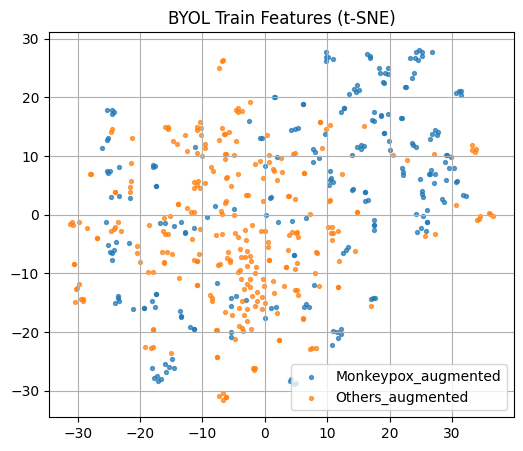

UMAP (train features)...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


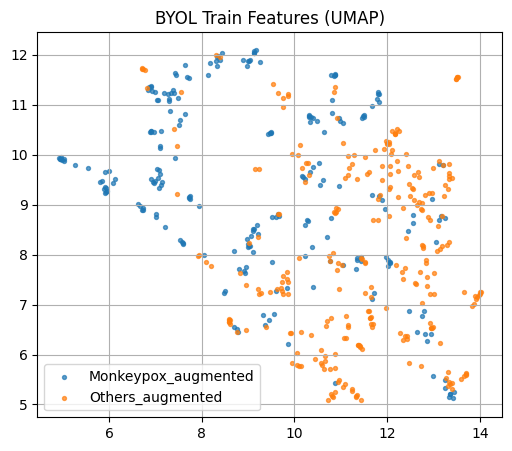

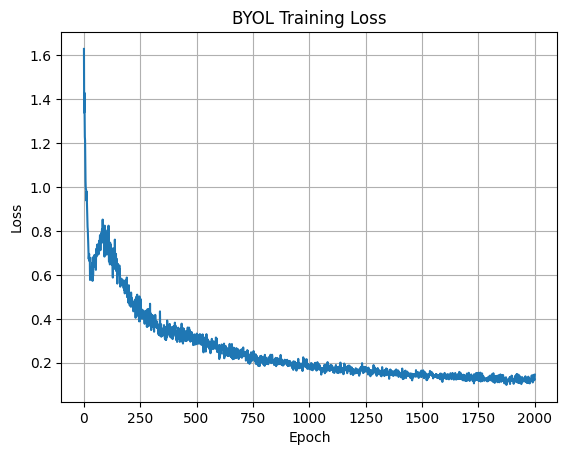

In [11]:
def extract_features(dataloader, encoder):
    encoder.eval()
    feats, labs = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            h = encoder(imgs)
            feats.append(h.cpu().numpy()); labs.append(labels.numpy())
    return np.concatenate(feats), np.concatenate(labs)

def subset_for_vis(dataloader, max_samples=1000):
    xs, ys, total = [], [], 0
    for imgs, labels in dataloader:
        if total >= max_samples: break
        take = min(imgs.size(0), max_samples - total)
        xs.append(imgs[:take]); ys.append(labels[:take]); total += take
    X = torch.cat(xs, dim=0); y = torch.cat(ys, dim=0)
    return DataLoader(list(zip(X, y)), batch_size=BATCH_SIZE_SUP, shuffle=False)

# Load encoder-only model for inference
enc_vis = models.resnet50(weights=None); enc_vis.fc = nn.Identity()
enc_vis.load_state_dict(torch.load(os.path.join(SAVE_DIR, "byol_resnet50_encoder.pth"), map_location=DEVICE))
enc_vis = enc_vis.to(DEVICE).eval()

vis_loader = subset_for_vis(train_down_loader, max_samples=1000)
vis_feats, vis_labels = extract_features(vis_loader, enc_vis)

print("t-SNE (train features)...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_2d = tsne.fit_transform(vis_feats)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(tsne_2d[idx,0], tsne_2d[idx,1], s=8, alpha=0.7, label=IDX_TO_CLASS[c])
plt.legend(); plt.title("BYOL Train Features (t-SNE)"); plt.grid(True); plt.show()

print("UMAP (train features)...")
reducer = umap.UMAP(n_components=2, random_state=SEED)
umap_2d = reducer.fit_transform(vis_feats)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(umap_2d[idx,0], umap_2d[idx,1], s=8, alpha=0.7, label=IDX_TO_CLASS[c])
plt.legend(); plt.title("BYOL Train Features (UMAP)"); plt.grid(True); plt.show()

plot_curve(ssl_loss_history, "BYOL Training Loss", "Epoch", "Loss")

# DOWNSTREAM LINEAR EVALUATION

In [12]:
# Freeze encoder, train linear classifier on train_down, validate on val_down
enc_linear = models.resnet50(weights=None); enc_linear.fc = nn.Identity()
enc_linear.load_state_dict(torch.load(os.path.join(SAVE_DIR, "byol_resnet50_encoder.pth"), map_location=DEVICE))
enc_linear = enc_linear.to(DEVICE).eval()
for p in enc_linear.parameters(): p.requires_grad = False

classifier = nn.Linear(2048, NUM_CLASSES).to(DEVICE)
opt_lin = torch.optim.Adam(classifier.parameters(), lr=LR_LINEAR)
criterion_ce = nn.CrossEntropyLoss()

lin_train_losses, lin_val_losses = [], []
lin_train_accs, lin_val_accs = [], []

print("Starting linear evaluation...")
for epoch in range(1, EPOCHS_LINEAR + 1):
    # Train
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_down_loader, desc=f"Linear Epoch {epoch}/{EPOCHS_LINEAR}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feats = enc_linear(imgs)
        logits = classifier(feats)
        loss = criterion_ce(logits, labels)
        opt_lin.zero_grad(); loss.backward(); opt_lin.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    lin_train_losses.append(train_loss); lin_train_accs.append(train_acc)

    # Validate
    classifier.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_down_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            feats = enc_linear(imgs)
            logits = classifier(feats)
            loss = criterion_ce(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss = running_loss / total
    val_acc = correct / total
    lin_val_losses.append(val_loss); lin_val_accs.append(val_acc)
    print(f"Linear Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc:.3f} | ValLoss={val_loss:.4f} Acc={val_acc:.3f}")


Starting linear evaluation...


Linear Epoch 1/2000: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Linear Epoch 1: TrainLoss=0.8082 Acc=0.455 | ValLoss=0.7109 Acc=0.570


Linear Epoch 2/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 2: TrainLoss=0.7154 Acc=0.567 | ValLoss=0.6879 Acc=0.555


Linear Epoch 3/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 3: TrainLoss=0.6532 Acc=0.580 | ValLoss=0.6223 Acc=0.617


Linear Epoch 4/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 4: TrainLoss=0.5976 Acc=0.716 | ValLoss=0.5894 Acc=0.734


Linear Epoch 5/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 5: TrainLoss=0.5553 Acc=0.763 | ValLoss=0.5556 Acc=0.734


Linear Epoch 6/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 6: TrainLoss=0.5291 Acc=0.792 | ValLoss=0.5388 Acc=0.773


Linear Epoch 7/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 7: TrainLoss=0.5112 Acc=0.771 | ValLoss=0.5292 Acc=0.758


Linear Epoch 8/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 8: TrainLoss=0.4979 Acc=0.804 | ValLoss=0.5193 Acc=0.773


Linear Epoch 9/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 9: TrainLoss=0.4879 Acc=0.776 | ValLoss=0.5075 Acc=0.773


Linear Epoch 10/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 10: TrainLoss=0.4743 Acc=0.806 | ValLoss=0.5017 Acc=0.758


Linear Epoch 11/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 11: TrainLoss=0.4648 Acc=0.794 | ValLoss=0.4939 Acc=0.781


Linear Epoch 12/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 12: TrainLoss=0.4546 Acc=0.806 | ValLoss=0.4872 Acc=0.781


Linear Epoch 13/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 13: TrainLoss=0.4495 Acc=0.816 | ValLoss=0.4802 Acc=0.789


Linear Epoch 14/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 14: TrainLoss=0.4406 Acc=0.824 | ValLoss=0.4751 Acc=0.789


Linear Epoch 15/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 15: TrainLoss=0.4365 Acc=0.829 | ValLoss=0.4734 Acc=0.805


Linear Epoch 16/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 16: TrainLoss=0.4333 Acc=0.818 | ValLoss=0.4690 Acc=0.812


Linear Epoch 17/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 17: TrainLoss=0.4302 Acc=0.825 | ValLoss=0.4722 Acc=0.789


Linear Epoch 18/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 18: TrainLoss=0.4211 Acc=0.822 | ValLoss=0.4677 Acc=0.820


Linear Epoch 19/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 19: TrainLoss=0.4183 Acc=0.825 | ValLoss=0.4619 Acc=0.805


Linear Epoch 20/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 20: TrainLoss=0.4126 Acc=0.833 | ValLoss=0.4484 Acc=0.805


Linear Epoch 21/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 21: TrainLoss=0.4037 Acc=0.841 | ValLoss=0.4459 Acc=0.797


Linear Epoch 22/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 22: TrainLoss=0.4043 Acc=0.833 | ValLoss=0.4414 Acc=0.812


Linear Epoch 23/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 23: TrainLoss=0.3986 Acc=0.841 | ValLoss=0.4376 Acc=0.820


Linear Epoch 24/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 24: TrainLoss=0.3953 Acc=0.835 | ValLoss=0.4408 Acc=0.820


Linear Epoch 25/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 25: TrainLoss=0.3938 Acc=0.829 | ValLoss=0.4523 Acc=0.805


Linear Epoch 26/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 26: TrainLoss=0.3982 Acc=0.822 | ValLoss=0.4488 Acc=0.789


Linear Epoch 27/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 27: TrainLoss=0.3921 Acc=0.829 | ValLoss=0.4280 Acc=0.836


Linear Epoch 28/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 28: TrainLoss=0.3812 Acc=0.841 | ValLoss=0.4251 Acc=0.836


Linear Epoch 29/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 29: TrainLoss=0.3792 Acc=0.843 | ValLoss=0.4207 Acc=0.844


Linear Epoch 30/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 30: TrainLoss=0.3759 Acc=0.845 | ValLoss=0.4178 Acc=0.844


Linear Epoch 31/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 31: TrainLoss=0.3699 Acc=0.847 | ValLoss=0.4170 Acc=0.828


Linear Epoch 32/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 32: TrainLoss=0.3691 Acc=0.853 | ValLoss=0.4149 Acc=0.828


Linear Epoch 33/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 33: TrainLoss=0.3712 Acc=0.831 | ValLoss=0.4105 Acc=0.844


Linear Epoch 34/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 34: TrainLoss=0.3614 Acc=0.855 | ValLoss=0.4103 Acc=0.828


Linear Epoch 35/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 35: TrainLoss=0.3582 Acc=0.859 | ValLoss=0.4075 Acc=0.844


Linear Epoch 36/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 36: TrainLoss=0.3555 Acc=0.851 | ValLoss=0.4060 Acc=0.836


Linear Epoch 37/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 37: TrainLoss=0.3574 Acc=0.849 | ValLoss=0.4032 Acc=0.836


Linear Epoch 38/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 38: TrainLoss=0.3524 Acc=0.853 | ValLoss=0.4015 Acc=0.844


Linear Epoch 39/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 39: TrainLoss=0.3500 Acc=0.855 | ValLoss=0.4006 Acc=0.844


Linear Epoch 40/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 40: TrainLoss=0.3477 Acc=0.863 | ValLoss=0.3986 Acc=0.836


Linear Epoch 41/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 41: TrainLoss=0.3441 Acc=0.861 | ValLoss=0.3966 Acc=0.844


Linear Epoch 42/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 42: TrainLoss=0.3433 Acc=0.859 | ValLoss=0.3986 Acc=0.828


Linear Epoch 43/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 43: TrainLoss=0.3414 Acc=0.861 | ValLoss=0.3936 Acc=0.844


Linear Epoch 44/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 44: TrainLoss=0.3404 Acc=0.863 | ValLoss=0.3922 Acc=0.836


Linear Epoch 45/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 45: TrainLoss=0.3363 Acc=0.859 | ValLoss=0.3907 Acc=0.844


Linear Epoch 46/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 46: TrainLoss=0.3418 Acc=0.855 | ValLoss=0.3972 Acc=0.867


Linear Epoch 47/2000: 100%|██████████| 8/8 [00:01<00:00,  5.33it/s]


Linear Epoch 47: TrainLoss=0.3334 Acc=0.861 | ValLoss=0.3965 Acc=0.828


Linear Epoch 48/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 48: TrainLoss=0.3381 Acc=0.859 | ValLoss=0.3874 Acc=0.844


Linear Epoch 49/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 49: TrainLoss=0.3284 Acc=0.861 | ValLoss=0.3868 Acc=0.852


Linear Epoch 50/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 50: TrainLoss=0.3259 Acc=0.867 | ValLoss=0.3858 Acc=0.836


Linear Epoch 51/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 51: TrainLoss=0.3252 Acc=0.871 | ValLoss=0.3882 Acc=0.828


Linear Epoch 52/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 52: TrainLoss=0.3276 Acc=0.863 | ValLoss=0.3839 Acc=0.836


Linear Epoch 53/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 53: TrainLoss=0.3226 Acc=0.863 | ValLoss=0.3824 Acc=0.844


Linear Epoch 54/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 54: TrainLoss=0.3212 Acc=0.867 | ValLoss=0.3822 Acc=0.852


Linear Epoch 55/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 55: TrainLoss=0.3179 Acc=0.871 | ValLoss=0.3819 Acc=0.828


Linear Epoch 56/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 56: TrainLoss=0.3213 Acc=0.859 | ValLoss=0.3896 Acc=0.867


Linear Epoch 57/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 57: TrainLoss=0.3247 Acc=0.871 | ValLoss=0.3787 Acc=0.852


Linear Epoch 58/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 58: TrainLoss=0.3192 Acc=0.869 | ValLoss=0.3867 Acc=0.820


Linear Epoch 59/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 59: TrainLoss=0.3137 Acc=0.871 | ValLoss=0.3772 Acc=0.852


Linear Epoch 60/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 60: TrainLoss=0.3101 Acc=0.880 | ValLoss=0.3760 Acc=0.852


Linear Epoch 61/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 61: TrainLoss=0.3149 Acc=0.867 | ValLoss=0.3833 Acc=0.867


Linear Epoch 62/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 62: TrainLoss=0.3145 Acc=0.859 | ValLoss=0.3752 Acc=0.844


Linear Epoch 63/2000: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Linear Epoch 63: TrainLoss=0.3116 Acc=0.884 | ValLoss=0.3846 Acc=0.820


Linear Epoch 64/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 64: TrainLoss=0.3130 Acc=0.873 | ValLoss=0.3889 Acc=0.867


Linear Epoch 65/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 65: TrainLoss=0.3038 Acc=0.873 | ValLoss=0.3831 Acc=0.820


Linear Epoch 66/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 66: TrainLoss=0.3110 Acc=0.875 | ValLoss=0.3885 Acc=0.867


Linear Epoch 67/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 67: TrainLoss=0.3082 Acc=0.878 | ValLoss=0.3745 Acc=0.828


Linear Epoch 68/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 68: TrainLoss=0.3011 Acc=0.880 | ValLoss=0.3742 Acc=0.828


Linear Epoch 69/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 69: TrainLoss=0.2997 Acc=0.882 | ValLoss=0.3729 Acc=0.867


Linear Epoch 70/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 70: TrainLoss=0.2958 Acc=0.884 | ValLoss=0.3744 Acc=0.828


Linear Epoch 71/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 71: TrainLoss=0.2938 Acc=0.884 | ValLoss=0.3706 Acc=0.867


Linear Epoch 72/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 72: TrainLoss=0.2927 Acc=0.884 | ValLoss=0.3699 Acc=0.852


Linear Epoch 73/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 73: TrainLoss=0.2922 Acc=0.882 | ValLoss=0.3708 Acc=0.875


Linear Epoch 74/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 74: TrainLoss=0.2928 Acc=0.882 | ValLoss=0.3693 Acc=0.852


Linear Epoch 75/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 75: TrainLoss=0.2922 Acc=0.886 | ValLoss=0.3685 Acc=0.852


Linear Epoch 76/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 76: TrainLoss=0.2893 Acc=0.888 | ValLoss=0.3692 Acc=0.828


Linear Epoch 77/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 77: TrainLoss=0.2873 Acc=0.888 | ValLoss=0.3669 Acc=0.859


Linear Epoch 78/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 78: TrainLoss=0.2857 Acc=0.884 | ValLoss=0.3665 Acc=0.875


Linear Epoch 79/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 79: TrainLoss=0.2872 Acc=0.890 | ValLoss=0.3727 Acc=0.797


Linear Epoch 80/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 80: TrainLoss=0.2931 Acc=0.873 | ValLoss=0.3692 Acc=0.820


Linear Epoch 81/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 81: TrainLoss=0.2856 Acc=0.876 | ValLoss=0.3694 Acc=0.875


Linear Epoch 82/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 82: TrainLoss=0.2836 Acc=0.890 | ValLoss=0.3686 Acc=0.805


Linear Epoch 83/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 83: TrainLoss=0.2808 Acc=0.886 | ValLoss=0.3746 Acc=0.875


Linear Epoch 84/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 84: TrainLoss=0.2836 Acc=0.884 | ValLoss=0.3670 Acc=0.820


Linear Epoch 85/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 85: TrainLoss=0.2781 Acc=0.888 | ValLoss=0.3639 Acc=0.859


Linear Epoch 86/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 86: TrainLoss=0.2774 Acc=0.886 | ValLoss=0.3626 Acc=0.867


Linear Epoch 87/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 87: TrainLoss=0.2782 Acc=0.888 | ValLoss=0.3645 Acc=0.891


Linear Epoch 88/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 88: TrainLoss=0.2728 Acc=0.898 | ValLoss=0.3772 Acc=0.805


Linear Epoch 89/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 89: TrainLoss=0.2786 Acc=0.875 | ValLoss=0.3740 Acc=0.875


Linear Epoch 90/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 90: TrainLoss=0.2824 Acc=0.886 | ValLoss=0.3712 Acc=0.797


Linear Epoch 91/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 91: TrainLoss=0.2736 Acc=0.892 | ValLoss=0.3624 Acc=0.875


Linear Epoch 92/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 92: TrainLoss=0.2698 Acc=0.890 | ValLoss=0.3658 Acc=0.805


Linear Epoch 93/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 93: TrainLoss=0.2716 Acc=0.894 | ValLoss=0.3636 Acc=0.891


Linear Epoch 94/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 94: TrainLoss=0.2689 Acc=0.896 | ValLoss=0.3633 Acc=0.812


Linear Epoch 95/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 95: TrainLoss=0.2691 Acc=0.896 | ValLoss=0.3601 Acc=0.875


Linear Epoch 96/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 96: TrainLoss=0.2711 Acc=0.892 | ValLoss=0.3631 Acc=0.883


Linear Epoch 97/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 97: TrainLoss=0.2668 Acc=0.900 | ValLoss=0.3780 Acc=0.805


Linear Epoch 98/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 98: TrainLoss=0.2765 Acc=0.886 | ValLoss=0.3621 Acc=0.883


Linear Epoch 99/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 99: TrainLoss=0.2612 Acc=0.902 | ValLoss=0.3607 Acc=0.828


Linear Epoch 100/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 100: TrainLoss=0.2627 Acc=0.896 | ValLoss=0.3590 Acc=0.883


Linear Epoch 101/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 101: TrainLoss=0.2609 Acc=0.902 | ValLoss=0.3618 Acc=0.812


Linear Epoch 102/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 102: TrainLoss=0.2627 Acc=0.892 | ValLoss=0.3589 Acc=0.852


Linear Epoch 103/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 103: TrainLoss=0.2579 Acc=0.900 | ValLoss=0.3583 Acc=0.883


Linear Epoch 104/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 104: TrainLoss=0.2592 Acc=0.906 | ValLoss=0.3673 Acc=0.797


Linear Epoch 105/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 105: TrainLoss=0.2724 Acc=0.892 | ValLoss=0.3667 Acc=0.875


Linear Epoch 106/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 106: TrainLoss=0.2607 Acc=0.902 | ValLoss=0.3575 Acc=0.852


Linear Epoch 107/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 107: TrainLoss=0.2569 Acc=0.894 | ValLoss=0.3607 Acc=0.812


Linear Epoch 108/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 108: TrainLoss=0.2562 Acc=0.906 | ValLoss=0.3629 Acc=0.883


Linear Epoch 109/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 109: TrainLoss=0.2521 Acc=0.902 | ValLoss=0.3732 Acc=0.797


Linear Epoch 110/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 110: TrainLoss=0.2693 Acc=0.884 | ValLoss=0.3756 Acc=0.883


Linear Epoch 111/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 111: TrainLoss=0.2692 Acc=0.882 | ValLoss=0.3566 Acc=0.859


Linear Epoch 112/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 112: TrainLoss=0.2510 Acc=0.902 | ValLoss=0.3564 Acc=0.883


Linear Epoch 113/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 113: TrainLoss=0.2501 Acc=0.908 | ValLoss=0.3568 Acc=0.859


Linear Epoch 114/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 114: TrainLoss=0.2529 Acc=0.900 | ValLoss=0.3603 Acc=0.812


Linear Epoch 115/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 115: TrainLoss=0.2560 Acc=0.900 | ValLoss=0.3602 Acc=0.883


Linear Epoch 116/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 116: TrainLoss=0.2606 Acc=0.902 | ValLoss=0.3650 Acc=0.797


Linear Epoch 117/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 117: TrainLoss=0.2667 Acc=0.894 | ValLoss=0.3621 Acc=0.805


Linear Epoch 118/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 118: TrainLoss=0.2586 Acc=0.888 | ValLoss=0.3648 Acc=0.883


Linear Epoch 119/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 119: TrainLoss=0.2501 Acc=0.912 | ValLoss=0.3572 Acc=0.852


Linear Epoch 120/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 120: TrainLoss=0.2437 Acc=0.906 | ValLoss=0.3556 Acc=0.875


Linear Epoch 121/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 121: TrainLoss=0.2442 Acc=0.902 | ValLoss=0.3565 Acc=0.891


Linear Epoch 122/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 122: TrainLoss=0.2454 Acc=0.910 | ValLoss=0.3656 Acc=0.797


Linear Epoch 123/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 123: TrainLoss=0.2516 Acc=0.890 | ValLoss=0.3721 Acc=0.883


Linear Epoch 124/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 124: TrainLoss=0.2435 Acc=0.914 | ValLoss=0.3711 Acc=0.797


Linear Epoch 125/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 125: TrainLoss=0.2447 Acc=0.902 | ValLoss=0.3579 Acc=0.883


Linear Epoch 126/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 126: TrainLoss=0.2433 Acc=0.896 | ValLoss=0.3548 Acc=0.852


Linear Epoch 127/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 127: TrainLoss=0.2390 Acc=0.910 | ValLoss=0.3535 Acc=0.875


Linear Epoch 128/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 128: TrainLoss=0.2376 Acc=0.916 | ValLoss=0.3532 Acc=0.867


Linear Epoch 129/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 129: TrainLoss=0.2367 Acc=0.918 | ValLoss=0.3529 Acc=0.875


Linear Epoch 130/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 130: TrainLoss=0.2365 Acc=0.916 | ValLoss=0.3528 Acc=0.867


Linear Epoch 131/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 131: TrainLoss=0.2349 Acc=0.918 | ValLoss=0.3541 Acc=0.844


Linear Epoch 132/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 132: TrainLoss=0.2359 Acc=0.914 | ValLoss=0.3527 Acc=0.883


Linear Epoch 133/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 133: TrainLoss=0.2345 Acc=0.906 | ValLoss=0.3552 Acc=0.836


Linear Epoch 134/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 134: TrainLoss=0.2377 Acc=0.916 | ValLoss=0.3516 Acc=0.867


Linear Epoch 135/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 135: TrainLoss=0.2313 Acc=0.916 | ValLoss=0.3530 Acc=0.852


Linear Epoch 136/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 136: TrainLoss=0.2320 Acc=0.918 | ValLoss=0.3523 Acc=0.867


Linear Epoch 137/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 137: TrainLoss=0.2317 Acc=0.918 | ValLoss=0.3540 Acc=0.844


Linear Epoch 138/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 138: TrainLoss=0.2344 Acc=0.910 | ValLoss=0.3532 Acc=0.844


Linear Epoch 139/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 139: TrainLoss=0.2381 Acc=0.904 | ValLoss=0.3586 Acc=0.883


Linear Epoch 140/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 140: TrainLoss=0.2312 Acc=0.918 | ValLoss=0.3612 Acc=0.812


Linear Epoch 141/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 141: TrainLoss=0.2322 Acc=0.908 | ValLoss=0.3570 Acc=0.883


Linear Epoch 142/2000: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Linear Epoch 142: TrainLoss=0.2298 Acc=0.904 | ValLoss=0.3521 Acc=0.859


Linear Epoch 143/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 143: TrainLoss=0.2276 Acc=0.918 | ValLoss=0.3510 Acc=0.875


Linear Epoch 144/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 144: TrainLoss=0.2272 Acc=0.922 | ValLoss=0.3539 Acc=0.844


Linear Epoch 145/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 145: TrainLoss=0.2251 Acc=0.920 | ValLoss=0.3523 Acc=0.875


Linear Epoch 146/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 146: TrainLoss=0.2301 Acc=0.910 | ValLoss=0.3514 Acc=0.859


Linear Epoch 147/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 147: TrainLoss=0.2232 Acc=0.920 | ValLoss=0.3559 Acc=0.883


Linear Epoch 148/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 148: TrainLoss=0.2241 Acc=0.918 | ValLoss=0.3541 Acc=0.836


Linear Epoch 149/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 149: TrainLoss=0.2264 Acc=0.910 | ValLoss=0.3503 Acc=0.875


Linear Epoch 150/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 150: TrainLoss=0.2238 Acc=0.916 | ValLoss=0.3503 Acc=0.867


Linear Epoch 151/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 151: TrainLoss=0.2223 Acc=0.918 | ValLoss=0.3493 Acc=0.875


Linear Epoch 152/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 152: TrainLoss=0.2211 Acc=0.920 | ValLoss=0.3499 Acc=0.867


Linear Epoch 153/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 153: TrainLoss=0.2214 Acc=0.924 | ValLoss=0.3498 Acc=0.859


Linear Epoch 154/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 154: TrainLoss=0.2207 Acc=0.920 | ValLoss=0.3495 Acc=0.867


Linear Epoch 155/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 155: TrainLoss=0.2202 Acc=0.924 | ValLoss=0.3522 Acc=0.875


Linear Epoch 156/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 156: TrainLoss=0.2350 Acc=0.916 | ValLoss=0.3642 Acc=0.812


Linear Epoch 157/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 157: TrainLoss=0.2341 Acc=0.912 | ValLoss=0.3492 Acc=0.875


Linear Epoch 158/2000: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]


Linear Epoch 158: TrainLoss=0.2158 Acc=0.925 | ValLoss=0.3497 Acc=0.859


Linear Epoch 159/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 159: TrainLoss=0.2162 Acc=0.925 | ValLoss=0.3543 Acc=0.883


Linear Epoch 160/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 160: TrainLoss=0.2176 Acc=0.924 | ValLoss=0.3493 Acc=0.859


Linear Epoch 161/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 161: TrainLoss=0.2156 Acc=0.929 | ValLoss=0.3476 Acc=0.875


Linear Epoch 162/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 162: TrainLoss=0.2140 Acc=0.922 | ValLoss=0.3480 Acc=0.867


Linear Epoch 163/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 163: TrainLoss=0.2138 Acc=0.925 | ValLoss=0.3484 Acc=0.852


Linear Epoch 164/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 164: TrainLoss=0.2131 Acc=0.929 | ValLoss=0.3482 Acc=0.867


Linear Epoch 165/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 165: TrainLoss=0.2128 Acc=0.922 | ValLoss=0.3475 Acc=0.875


Linear Epoch 166/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 166: TrainLoss=0.2120 Acc=0.925 | ValLoss=0.3473 Acc=0.875


Linear Epoch 167/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 167: TrainLoss=0.2129 Acc=0.927 | ValLoss=0.3489 Acc=0.859


Linear Epoch 168/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 168: TrainLoss=0.2155 Acc=0.918 | ValLoss=0.3484 Acc=0.867


Linear Epoch 169/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 169: TrainLoss=0.2097 Acc=0.924 | ValLoss=0.3477 Acc=0.852


Linear Epoch 170/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 170: TrainLoss=0.2107 Acc=0.924 | ValLoss=0.3470 Acc=0.867


Linear Epoch 171/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 171: TrainLoss=0.2114 Acc=0.925 | ValLoss=0.3479 Acc=0.852


Linear Epoch 172/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 172: TrainLoss=0.2080 Acc=0.924 | ValLoss=0.3466 Acc=0.875


Linear Epoch 173/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 173: TrainLoss=0.2093 Acc=0.920 | ValLoss=0.3474 Acc=0.867


Linear Epoch 174/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 174: TrainLoss=0.2101 Acc=0.922 | ValLoss=0.3487 Acc=0.852


Linear Epoch 175/2000: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Linear Epoch 175: TrainLoss=0.2070 Acc=0.929 | ValLoss=0.3463 Acc=0.875


Linear Epoch 176/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 176: TrainLoss=0.2059 Acc=0.927 | ValLoss=0.3468 Acc=0.852


Linear Epoch 177/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 177: TrainLoss=0.2057 Acc=0.927 | ValLoss=0.3463 Acc=0.875


Linear Epoch 178/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 178: TrainLoss=0.2067 Acc=0.927 | ValLoss=0.3528 Acc=0.836


Linear Epoch 179/2000: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Linear Epoch 179: TrainLoss=0.2079 Acc=0.924 | ValLoss=0.3541 Acc=0.891


Linear Epoch 180/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 180: TrainLoss=0.2068 Acc=0.931 | ValLoss=0.3627 Acc=0.820


Linear Epoch 181/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 181: TrainLoss=0.2149 Acc=0.924 | ValLoss=0.3501 Acc=0.875


Linear Epoch 182/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 182: TrainLoss=0.2032 Acc=0.924 | ValLoss=0.3475 Acc=0.852


Linear Epoch 183/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 183: TrainLoss=0.2035 Acc=0.933 | ValLoss=0.3486 Acc=0.875


Linear Epoch 184/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 184: TrainLoss=0.2025 Acc=0.931 | ValLoss=0.3467 Acc=0.852


Linear Epoch 185/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 185: TrainLoss=0.2054 Acc=0.939 | ValLoss=0.3473 Acc=0.859


Linear Epoch 186/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 186: TrainLoss=0.2049 Acc=0.920 | ValLoss=0.3479 Acc=0.867


Linear Epoch 187/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 187: TrainLoss=0.2004 Acc=0.929 | ValLoss=0.3450 Acc=0.875


Linear Epoch 188/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 188: TrainLoss=0.2002 Acc=0.931 | ValLoss=0.3471 Acc=0.867


Linear Epoch 189/2000: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


Linear Epoch 189: TrainLoss=0.2010 Acc=0.933 | ValLoss=0.3493 Acc=0.836


Linear Epoch 190/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 190: TrainLoss=0.2001 Acc=0.935 | ValLoss=0.3495 Acc=0.883


Linear Epoch 191/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 191: TrainLoss=0.2025 Acc=0.933 | ValLoss=0.3446 Acc=0.867


Linear Epoch 192/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 192: TrainLoss=0.1999 Acc=0.925 | ValLoss=0.3441 Acc=0.875


Linear Epoch 193/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 193: TrainLoss=0.2033 Acc=0.937 | ValLoss=0.3553 Acc=0.828


Linear Epoch 194/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 194: TrainLoss=0.2074 Acc=0.927 | ValLoss=0.3438 Acc=0.867


Linear Epoch 195/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 195: TrainLoss=0.1971 Acc=0.925 | ValLoss=0.3435 Acc=0.867


Linear Epoch 196/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 196: TrainLoss=0.2029 Acc=0.931 | ValLoss=0.3520 Acc=0.828


Linear Epoch 197/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 197: TrainLoss=0.2043 Acc=0.920 | ValLoss=0.3519 Acc=0.883


Linear Epoch 198/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 198: TrainLoss=0.1991 Acc=0.941 | ValLoss=0.3428 Acc=0.859


Linear Epoch 199/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 199: TrainLoss=0.1954 Acc=0.935 | ValLoss=0.3453 Acc=0.859


Linear Epoch 200/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 200: TrainLoss=0.1960 Acc=0.933 | ValLoss=0.3477 Acc=0.875


Linear Epoch 201/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 201: TrainLoss=0.1943 Acc=0.939 | ValLoss=0.3469 Acc=0.859


Linear Epoch 202/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 202: TrainLoss=0.1933 Acc=0.931 | ValLoss=0.3485 Acc=0.883


Linear Epoch 203/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 203: TrainLoss=0.1935 Acc=0.939 | ValLoss=0.3463 Acc=0.859


Linear Epoch 204/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 204: TrainLoss=0.1932 Acc=0.929 | ValLoss=0.3502 Acc=0.883


Linear Epoch 205/2000: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


Linear Epoch 205: TrainLoss=0.1948 Acc=0.937 | ValLoss=0.3445 Acc=0.852


Linear Epoch 206/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 206: TrainLoss=0.1913 Acc=0.933 | ValLoss=0.3427 Acc=0.867


Linear Epoch 207/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 207: TrainLoss=0.1896 Acc=0.933 | ValLoss=0.3427 Acc=0.875


Linear Epoch 208/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 208: TrainLoss=0.1885 Acc=0.933 | ValLoss=0.3430 Acc=0.859


Linear Epoch 209/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 209: TrainLoss=0.1924 Acc=0.929 | ValLoss=0.3431 Acc=0.859


Linear Epoch 210/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 210: TrainLoss=0.1889 Acc=0.933 | ValLoss=0.3426 Acc=0.859


Linear Epoch 211/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 211: TrainLoss=0.1882 Acc=0.935 | ValLoss=0.3415 Acc=0.875


Linear Epoch 212/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 212: TrainLoss=0.1876 Acc=0.933 | ValLoss=0.3414 Acc=0.859


Linear Epoch 213/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 213: TrainLoss=0.1880 Acc=0.931 | ValLoss=0.3426 Acc=0.867


Linear Epoch 214/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 214: TrainLoss=0.1856 Acc=0.935 | ValLoss=0.3428 Acc=0.859


Linear Epoch 215/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 215: TrainLoss=0.1857 Acc=0.935 | ValLoss=0.3416 Acc=0.875


Linear Epoch 216/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 216: TrainLoss=0.1854 Acc=0.939 | ValLoss=0.3427 Acc=0.867


Linear Epoch 217/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 217: TrainLoss=0.1877 Acc=0.927 | ValLoss=0.3420 Acc=0.875


Linear Epoch 218/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 218: TrainLoss=0.1904 Acc=0.949 | ValLoss=0.3497 Acc=0.828


Linear Epoch 219/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 219: TrainLoss=0.1906 Acc=0.935 | ValLoss=0.3408 Acc=0.875


Linear Epoch 220/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 220: TrainLoss=0.1861 Acc=0.937 | ValLoss=0.3443 Acc=0.859


Linear Epoch 221/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 221: TrainLoss=0.1823 Acc=0.937 | ValLoss=0.3425 Acc=0.867


Linear Epoch 222/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 222: TrainLoss=0.1818 Acc=0.943 | ValLoss=0.3441 Acc=0.859


Linear Epoch 223/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 223: TrainLoss=0.1817 Acc=0.937 | ValLoss=0.3450 Acc=0.867


Linear Epoch 224/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 224: TrainLoss=0.1821 Acc=0.955 | ValLoss=0.3458 Acc=0.852


Linear Epoch 225/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 225: TrainLoss=0.1880 Acc=0.943 | ValLoss=0.3423 Acc=0.867


Linear Epoch 226/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 226: TrainLoss=0.1856 Acc=0.927 | ValLoss=0.3430 Acc=0.867


Linear Epoch 227/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 227: TrainLoss=0.1817 Acc=0.951 | ValLoss=0.3437 Acc=0.859


Linear Epoch 228/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 228: TrainLoss=0.1808 Acc=0.935 | ValLoss=0.3410 Acc=0.875


Linear Epoch 229/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 229: TrainLoss=0.1793 Acc=0.943 | ValLoss=0.3411 Acc=0.875


Linear Epoch 230/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 230: TrainLoss=0.1828 Acc=0.943 | ValLoss=0.3446 Acc=0.883


Linear Epoch 231/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 231: TrainLoss=0.1795 Acc=0.939 | ValLoss=0.3409 Acc=0.859


Linear Epoch 232/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 232: TrainLoss=0.1780 Acc=0.945 | ValLoss=0.3404 Acc=0.859


Linear Epoch 233/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 233: TrainLoss=0.1794 Acc=0.943 | ValLoss=0.3401 Acc=0.867


Linear Epoch 234/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 234: TrainLoss=0.1787 Acc=0.933 | ValLoss=0.3411 Acc=0.867


Linear Epoch 235/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 235: TrainLoss=0.1795 Acc=0.941 | ValLoss=0.3401 Acc=0.859


Linear Epoch 236/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 236: TrainLoss=0.1762 Acc=0.949 | ValLoss=0.3393 Acc=0.875


Linear Epoch 237/2000: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


Linear Epoch 237: TrainLoss=0.1766 Acc=0.947 | ValLoss=0.3391 Acc=0.859


Linear Epoch 238/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 238: TrainLoss=0.1775 Acc=0.943 | ValLoss=0.3434 Acc=0.875


Linear Epoch 239/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 239: TrainLoss=0.1770 Acc=0.943 | ValLoss=0.3426 Acc=0.859


Linear Epoch 240/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 240: TrainLoss=0.1780 Acc=0.949 | ValLoss=0.3392 Acc=0.867


Linear Epoch 241/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 241: TrainLoss=0.1779 Acc=0.943 | ValLoss=0.3410 Acc=0.867


Linear Epoch 242/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 242: TrainLoss=0.1734 Acc=0.947 | ValLoss=0.3382 Acc=0.859


Linear Epoch 243/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 243: TrainLoss=0.1743 Acc=0.945 | ValLoss=0.3389 Acc=0.859


Linear Epoch 244/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 244: TrainLoss=0.1741 Acc=0.937 | ValLoss=0.3446 Acc=0.883


Linear Epoch 245/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 245: TrainLoss=0.1775 Acc=0.947 | ValLoss=0.3442 Acc=0.852


Linear Epoch 246/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 246: TrainLoss=0.1795 Acc=0.947 | ValLoss=0.3402 Acc=0.867


Linear Epoch 247/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 247: TrainLoss=0.1760 Acc=0.937 | ValLoss=0.3395 Acc=0.867


Linear Epoch 248/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 248: TrainLoss=0.1748 Acc=0.949 | ValLoss=0.3394 Acc=0.859


Linear Epoch 249/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 249: TrainLoss=0.1725 Acc=0.941 | ValLoss=0.3387 Acc=0.867


Linear Epoch 250/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 250: TrainLoss=0.1704 Acc=0.949 | ValLoss=0.3424 Acc=0.852


Linear Epoch 251/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 251: TrainLoss=0.1724 Acc=0.945 | ValLoss=0.3426 Acc=0.883


Linear Epoch 252/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 252: TrainLoss=0.1718 Acc=0.943 | ValLoss=0.3367 Acc=0.859


Linear Epoch 253/2000: 100%|██████████| 8/8 [00:01<00:00,  5.36it/s]


Linear Epoch 253: TrainLoss=0.1712 Acc=0.953 | ValLoss=0.3387 Acc=0.859


Linear Epoch 254/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 254: TrainLoss=0.1698 Acc=0.937 | ValLoss=0.3385 Acc=0.867


Linear Epoch 255/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 255: TrainLoss=0.1711 Acc=0.953 | ValLoss=0.3372 Acc=0.859


Linear Epoch 256/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 256: TrainLoss=0.1714 Acc=0.959 | ValLoss=0.3384 Acc=0.859


Linear Epoch 257/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 257: TrainLoss=0.1891 Acc=0.937 | ValLoss=0.3554 Acc=0.898


Linear Epoch 258/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 258: TrainLoss=0.1783 Acc=0.945 | ValLoss=0.3374 Acc=0.859


Linear Epoch 259/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 259: TrainLoss=0.1713 Acc=0.959 | ValLoss=0.3362 Acc=0.875


Linear Epoch 260/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 260: TrainLoss=0.1714 Acc=0.941 | ValLoss=0.3408 Acc=0.875


Linear Epoch 261/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 261: TrainLoss=0.1750 Acc=0.947 | ValLoss=0.3423 Acc=0.852


Linear Epoch 262/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 262: TrainLoss=0.1653 Acc=0.957 | ValLoss=0.3402 Acc=0.875


Linear Epoch 263/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 263: TrainLoss=0.1665 Acc=0.947 | ValLoss=0.3392 Acc=0.859


Linear Epoch 264/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 264: TrainLoss=0.1646 Acc=0.949 | ValLoss=0.3401 Acc=0.875


Linear Epoch 265/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 265: TrainLoss=0.1651 Acc=0.951 | ValLoss=0.3361 Acc=0.859


Linear Epoch 266/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 266: TrainLoss=0.1648 Acc=0.953 | ValLoss=0.3363 Acc=0.859


Linear Epoch 267/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 267: TrainLoss=0.1664 Acc=0.947 | ValLoss=0.3368 Acc=0.867


Linear Epoch 268/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 268: TrainLoss=0.1654 Acc=0.945 | ValLoss=0.3371 Acc=0.867


Linear Epoch 269/2000: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


Linear Epoch 269: TrainLoss=0.1678 Acc=0.965 | ValLoss=0.3386 Acc=0.859


Linear Epoch 270/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 270: TrainLoss=0.1636 Acc=0.945 | ValLoss=0.3394 Acc=0.883


Linear Epoch 271/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 271: TrainLoss=0.1636 Acc=0.959 | ValLoss=0.3402 Acc=0.859


Linear Epoch 272/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 272: TrainLoss=0.1644 Acc=0.951 | ValLoss=0.3363 Acc=0.867


Linear Epoch 273/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 273: TrainLoss=0.1598 Acc=0.957 | ValLoss=0.3355 Acc=0.859


Linear Epoch 274/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 274: TrainLoss=0.1614 Acc=0.953 | ValLoss=0.3357 Acc=0.867


Linear Epoch 275/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 275: TrainLoss=0.1604 Acc=0.957 | ValLoss=0.3359 Acc=0.859


Linear Epoch 276/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 276: TrainLoss=0.1653 Acc=0.951 | ValLoss=0.3365 Acc=0.875


Linear Epoch 277/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 277: TrainLoss=0.1619 Acc=0.953 | ValLoss=0.3346 Acc=0.867


Linear Epoch 278/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 278: TrainLoss=0.1608 Acc=0.959 | ValLoss=0.3355 Acc=0.859


Linear Epoch 279/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 279: TrainLoss=0.1600 Acc=0.955 | ValLoss=0.3345 Acc=0.867


Linear Epoch 280/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 280: TrainLoss=0.1585 Acc=0.953 | ValLoss=0.3341 Acc=0.867


Linear Epoch 281/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 281: TrainLoss=0.1613 Acc=0.955 | ValLoss=0.3383 Acc=0.875


Linear Epoch 282/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 282: TrainLoss=0.1598 Acc=0.955 | ValLoss=0.3348 Acc=0.859


Linear Epoch 283/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 283: TrainLoss=0.1653 Acc=0.959 | ValLoss=0.3367 Acc=0.859


Linear Epoch 284/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 284: TrainLoss=0.1584 Acc=0.947 | ValLoss=0.3386 Acc=0.875


Linear Epoch 285/2000: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Linear Epoch 285: TrainLoss=0.1610 Acc=0.949 | ValLoss=0.3352 Acc=0.859


Linear Epoch 286/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 286: TrainLoss=0.1564 Acc=0.959 | ValLoss=0.3366 Acc=0.875


Linear Epoch 287/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 287: TrainLoss=0.1581 Acc=0.949 | ValLoss=0.3330 Acc=0.859


Linear Epoch 288/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 288: TrainLoss=0.1568 Acc=0.957 | ValLoss=0.3327 Acc=0.859


Linear Epoch 289/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 289: TrainLoss=0.1584 Acc=0.953 | ValLoss=0.3357 Acc=0.875


Linear Epoch 290/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 290: TrainLoss=0.1562 Acc=0.963 | ValLoss=0.3331 Acc=0.859


Linear Epoch 291/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 291: TrainLoss=0.1561 Acc=0.957 | ValLoss=0.3367 Acc=0.875


Linear Epoch 292/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 292: TrainLoss=0.1547 Acc=0.957 | ValLoss=0.3392 Acc=0.859


Linear Epoch 293/2000: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Linear Epoch 293: TrainLoss=0.1679 Acc=0.945 | ValLoss=0.3342 Acc=0.875


Linear Epoch 294/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 294: TrainLoss=0.1621 Acc=0.947 | ValLoss=0.3364 Acc=0.875


Linear Epoch 295/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 295: TrainLoss=0.1643 Acc=0.953 | ValLoss=0.3397 Acc=0.859


Linear Epoch 296/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 296: TrainLoss=0.1600 Acc=0.955 | ValLoss=0.3359 Acc=0.875


Linear Epoch 297/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 297: TrainLoss=0.1558 Acc=0.961 | ValLoss=0.3330 Acc=0.867


Linear Epoch 298/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 298: TrainLoss=0.1527 Acc=0.965 | ValLoss=0.3325 Acc=0.859


Linear Epoch 299/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 299: TrainLoss=0.1518 Acc=0.965 | ValLoss=0.3335 Acc=0.867


Linear Epoch 300/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 300: TrainLoss=0.1519 Acc=0.959 | ValLoss=0.3317 Acc=0.859


Linear Epoch 301/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 301: TrainLoss=0.1510 Acc=0.959 | ValLoss=0.3319 Acc=0.867


Linear Epoch 302/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 302: TrainLoss=0.1511 Acc=0.959 | ValLoss=0.3316 Acc=0.859


Linear Epoch 303/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 303: TrainLoss=0.1509 Acc=0.963 | ValLoss=0.3339 Acc=0.875


Linear Epoch 304/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 304: TrainLoss=0.1514 Acc=0.963 | ValLoss=0.3349 Acc=0.859


Linear Epoch 305/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 305: TrainLoss=0.1571 Acc=0.957 | ValLoss=0.3320 Acc=0.852


Linear Epoch 306/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 306: TrainLoss=0.1635 Acc=0.927 | ValLoss=0.3501 Acc=0.891


Linear Epoch 307/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 307: TrainLoss=0.1708 Acc=0.941 | ValLoss=0.3643 Acc=0.820


Linear Epoch 308/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 308: TrainLoss=0.1799 Acc=0.925 | ValLoss=0.3585 Acc=0.898


Linear Epoch 309/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 309: TrainLoss=0.1614 Acc=0.941 | ValLoss=0.3360 Acc=0.859


Linear Epoch 310/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 310: TrainLoss=0.1655 Acc=0.953 | ValLoss=0.3363 Acc=0.867


Linear Epoch 311/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 311: TrainLoss=0.1553 Acc=0.945 | ValLoss=0.3380 Acc=0.891


Linear Epoch 312/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 312: TrainLoss=0.1506 Acc=0.961 | ValLoss=0.3351 Acc=0.859


Linear Epoch 313/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 313: TrainLoss=0.1513 Acc=0.961 | ValLoss=0.3312 Acc=0.859


Linear Epoch 314/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 314: TrainLoss=0.1473 Acc=0.959 | ValLoss=0.3324 Acc=0.867


Linear Epoch 315/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 315: TrainLoss=0.1470 Acc=0.963 | ValLoss=0.3313 Acc=0.867


Linear Epoch 316/2000: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


Linear Epoch 316: TrainLoss=0.1501 Acc=0.963 | ValLoss=0.3311 Acc=0.859


Linear Epoch 317/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 317: TrainLoss=0.1497 Acc=0.967 | ValLoss=0.3320 Acc=0.859


Linear Epoch 318/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 318: TrainLoss=0.1530 Acc=0.947 | ValLoss=0.3505 Acc=0.891


Linear Epoch 319/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 319: TrainLoss=0.1602 Acc=0.953 | ValLoss=0.3416 Acc=0.852


Linear Epoch 320/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 320: TrainLoss=0.1548 Acc=0.953 | ValLoss=0.3311 Acc=0.867


Linear Epoch 321/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 321: TrainLoss=0.1451 Acc=0.963 | ValLoss=0.3302 Acc=0.859


Linear Epoch 322/2000: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


Linear Epoch 322: TrainLoss=0.1440 Acc=0.965 | ValLoss=0.3306 Acc=0.867


Linear Epoch 323/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 323: TrainLoss=0.1452 Acc=0.963 | ValLoss=0.3303 Acc=0.859


Linear Epoch 324/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 324: TrainLoss=0.1441 Acc=0.967 | ValLoss=0.3346 Acc=0.875


Linear Epoch 325/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 325: TrainLoss=0.1446 Acc=0.963 | ValLoss=0.3334 Acc=0.859


Linear Epoch 326/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 326: TrainLoss=0.1465 Acc=0.963 | ValLoss=0.3324 Acc=0.875


Linear Epoch 327/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 327: TrainLoss=0.1437 Acc=0.965 | ValLoss=0.3294 Acc=0.859


Linear Epoch 328/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 328: TrainLoss=0.1450 Acc=0.963 | ValLoss=0.3294 Acc=0.859


Linear Epoch 329/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 329: TrainLoss=0.1472 Acc=0.961 | ValLoss=0.3357 Acc=0.883


Linear Epoch 330/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 330: TrainLoss=0.1484 Acc=0.953 | ValLoss=0.3289 Acc=0.859


Linear Epoch 331/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 331: TrainLoss=0.1414 Acc=0.969 | ValLoss=0.3300 Acc=0.867


Linear Epoch 332/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 332: TrainLoss=0.1441 Acc=0.961 | ValLoss=0.3286 Acc=0.859


Linear Epoch 333/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 333: TrainLoss=0.1442 Acc=0.971 | ValLoss=0.3285 Acc=0.859


Linear Epoch 334/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 334: TrainLoss=0.1468 Acc=0.965 | ValLoss=0.3333 Acc=0.867


Linear Epoch 335/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 335: TrainLoss=0.1452 Acc=0.951 | ValLoss=0.3391 Acc=0.891


Linear Epoch 336/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 336: TrainLoss=0.1463 Acc=0.965 | ValLoss=0.3325 Acc=0.859


Linear Epoch 337/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 337: TrainLoss=0.1480 Acc=0.967 | ValLoss=0.3288 Acc=0.859


Linear Epoch 338/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 338: TrainLoss=0.1426 Acc=0.951 | ValLoss=0.3361 Acc=0.891


Linear Epoch 339/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 339: TrainLoss=0.1423 Acc=0.971 | ValLoss=0.3287 Acc=0.859


Linear Epoch 340/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 340: TrainLoss=0.1408 Acc=0.969 | ValLoss=0.3309 Acc=0.875


Linear Epoch 341/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 341: TrainLoss=0.1421 Acc=0.963 | ValLoss=0.3280 Acc=0.859


Linear Epoch 342/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 342: TrainLoss=0.1413 Acc=0.973 | ValLoss=0.3278 Acc=0.859


Linear Epoch 343/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 343: TrainLoss=0.1457 Acc=0.961 | ValLoss=0.3352 Acc=0.891


Linear Epoch 344/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 344: TrainLoss=0.1380 Acc=0.965 | ValLoss=0.3308 Acc=0.859


Linear Epoch 345/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 345: TrainLoss=0.1381 Acc=0.969 | ValLoss=0.3334 Acc=0.875


Linear Epoch 346/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 346: TrainLoss=0.1404 Acc=0.967 | ValLoss=0.3282 Acc=0.859


Linear Epoch 347/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 347: TrainLoss=0.1377 Acc=0.971 | ValLoss=0.3297 Acc=0.875


Linear Epoch 348/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 348: TrainLoss=0.1369 Acc=0.971 | ValLoss=0.3278 Acc=0.859


Linear Epoch 349/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 349: TrainLoss=0.1378 Acc=0.967 | ValLoss=0.3318 Acc=0.875


Linear Epoch 350/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 350: TrainLoss=0.1423 Acc=0.967 | ValLoss=0.3278 Acc=0.867


Linear Epoch 351/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 351: TrainLoss=0.1372 Acc=0.965 | ValLoss=0.3278 Acc=0.867


Linear Epoch 352/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 352: TrainLoss=0.1377 Acc=0.967 | ValLoss=0.3281 Acc=0.859


Linear Epoch 353/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 353: TrainLoss=0.1403 Acc=0.969 | ValLoss=0.3277 Acc=0.859


Linear Epoch 354/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 354: TrainLoss=0.1371 Acc=0.969 | ValLoss=0.3273 Acc=0.859


Linear Epoch 355/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 355: TrainLoss=0.1403 Acc=0.961 | ValLoss=0.3341 Acc=0.891


Linear Epoch 356/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 356: TrainLoss=0.1406 Acc=0.963 | ValLoss=0.3288 Acc=0.859


Linear Epoch 357/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 357: TrainLoss=0.1352 Acc=0.967 | ValLoss=0.3289 Acc=0.875


Linear Epoch 358/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 358: TrainLoss=0.1330 Acc=0.975 | ValLoss=0.3278 Acc=0.859


Linear Epoch 359/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 359: TrainLoss=0.1361 Acc=0.965 | ValLoss=0.3333 Acc=0.891


Linear Epoch 360/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 360: TrainLoss=0.1363 Acc=0.973 | ValLoss=0.3305 Acc=0.859


Linear Epoch 361/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 361: TrainLoss=0.1357 Acc=0.971 | ValLoss=0.3291 Acc=0.875


Linear Epoch 362/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 362: TrainLoss=0.1372 Acc=0.959 | ValLoss=0.3324 Acc=0.859


Linear Epoch 363/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 363: TrainLoss=0.1373 Acc=0.961 | ValLoss=0.3420 Acc=0.891


Linear Epoch 364/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 364: TrainLoss=0.1387 Acc=0.971 | ValLoss=0.3337 Acc=0.859


Linear Epoch 365/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 365: TrainLoss=0.1367 Acc=0.961 | ValLoss=0.3309 Acc=0.875


Linear Epoch 366/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 366: TrainLoss=0.1330 Acc=0.973 | ValLoss=0.3260 Acc=0.859


Linear Epoch 367/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 367: TrainLoss=0.1330 Acc=0.971 | ValLoss=0.3261 Acc=0.859


Linear Epoch 368/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 368: TrainLoss=0.1326 Acc=0.975 | ValLoss=0.3265 Acc=0.859


Linear Epoch 369/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 369: TrainLoss=0.1328 Acc=0.973 | ValLoss=0.3261 Acc=0.859


Linear Epoch 370/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 370: TrainLoss=0.1322 Acc=0.969 | ValLoss=0.3260 Acc=0.859


Linear Epoch 371/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 371: TrainLoss=0.1318 Acc=0.971 | ValLoss=0.3258 Acc=0.852


Linear Epoch 372/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 372: TrainLoss=0.1304 Acc=0.976 | ValLoss=0.3254 Acc=0.859


Linear Epoch 373/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 373: TrainLoss=0.1327 Acc=0.976 | ValLoss=0.3261 Acc=0.867


Linear Epoch 374/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 374: TrainLoss=0.1309 Acc=0.975 | ValLoss=0.3267 Acc=0.875


Linear Epoch 375/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 375: TrainLoss=0.1303 Acc=0.976 | ValLoss=0.3255 Acc=0.859


Linear Epoch 376/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 376: TrainLoss=0.1301 Acc=0.975 | ValLoss=0.3257 Acc=0.859


Linear Epoch 377/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 377: TrainLoss=0.1301 Acc=0.976 | ValLoss=0.3301 Acc=0.883


Linear Epoch 378/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 378: TrainLoss=0.1314 Acc=0.975 | ValLoss=0.3260 Acc=0.859


Linear Epoch 379/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 379: TrainLoss=0.1309 Acc=0.973 | ValLoss=0.3267 Acc=0.859


Linear Epoch 380/2000: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


Linear Epoch 380: TrainLoss=0.1320 Acc=0.965 | ValLoss=0.3308 Acc=0.891


Linear Epoch 381/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 381: TrainLoss=0.1308 Acc=0.973 | ValLoss=0.3246 Acc=0.859


Linear Epoch 382/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 382: TrainLoss=0.1292 Acc=0.971 | ValLoss=0.3272 Acc=0.875


Linear Epoch 383/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 383: TrainLoss=0.1287 Acc=0.976 | ValLoss=0.3247 Acc=0.859


Linear Epoch 384/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 384: TrainLoss=0.1275 Acc=0.976 | ValLoss=0.3251 Acc=0.875


Linear Epoch 385/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 385: TrainLoss=0.1287 Acc=0.975 | ValLoss=0.3253 Acc=0.859


Linear Epoch 386/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 386: TrainLoss=0.1305 Acc=0.965 | ValLoss=0.3331 Acc=0.891


Linear Epoch 387/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 387: TrainLoss=0.1316 Acc=0.963 | ValLoss=0.3244 Acc=0.859


Linear Epoch 388/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 388: TrainLoss=0.1294 Acc=0.973 | ValLoss=0.3243 Acc=0.859


Linear Epoch 389/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 389: TrainLoss=0.1271 Acc=0.969 | ValLoss=0.3241 Acc=0.859


Linear Epoch 390/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 390: TrainLoss=0.1281 Acc=0.975 | ValLoss=0.3304 Acc=0.891


Linear Epoch 391/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 391: TrainLoss=0.1325 Acc=0.963 | ValLoss=0.3240 Acc=0.859


Linear Epoch 392/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 392: TrainLoss=0.1329 Acc=0.973 | ValLoss=0.3240 Acc=0.859


Linear Epoch 393/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 393: TrainLoss=0.1253 Acc=0.975 | ValLoss=0.3246 Acc=0.875


Linear Epoch 394/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 394: TrainLoss=0.1278 Acc=0.971 | ValLoss=0.3279 Acc=0.883


Linear Epoch 395/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 395: TrainLoss=0.1289 Acc=0.973 | ValLoss=0.3238 Acc=0.859


Linear Epoch 396/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 396: TrainLoss=0.1241 Acc=0.973 | ValLoss=0.3249 Acc=0.875


Linear Epoch 397/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 397: TrainLoss=0.1273 Acc=0.978 | ValLoss=0.3239 Acc=0.875


Linear Epoch 398/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 398: TrainLoss=0.1290 Acc=0.969 | ValLoss=0.3288 Acc=0.891


Linear Epoch 399/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 399: TrainLoss=0.1298 Acc=0.976 | ValLoss=0.3279 Acc=0.859


Linear Epoch 400/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 400: TrainLoss=0.1269 Acc=0.973 | ValLoss=0.3267 Acc=0.875


Linear Epoch 401/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 401: TrainLoss=0.1236 Acc=0.976 | ValLoss=0.3231 Acc=0.859


Linear Epoch 402/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 402: TrainLoss=0.1260 Acc=0.971 | ValLoss=0.3306 Acc=0.891


Linear Epoch 403/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 403: TrainLoss=0.1219 Acc=0.976 | ValLoss=0.3290 Acc=0.859


Linear Epoch 404/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 404: TrainLoss=0.1286 Acc=0.965 | ValLoss=0.3306 Acc=0.891


Linear Epoch 405/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 405: TrainLoss=0.1252 Acc=0.971 | ValLoss=0.3254 Acc=0.859


Linear Epoch 406/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 406: TrainLoss=0.1242 Acc=0.973 | ValLoss=0.3245 Acc=0.867


Linear Epoch 407/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 407: TrainLoss=0.1215 Acc=0.978 | ValLoss=0.3256 Acc=0.859


Linear Epoch 408/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 408: TrainLoss=0.1244 Acc=0.975 | ValLoss=0.3365 Acc=0.891


Linear Epoch 409/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 409: TrainLoss=0.1228 Acc=0.975 | ValLoss=0.3237 Acc=0.859


Linear Epoch 410/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 410: TrainLoss=0.1224 Acc=0.973 | ValLoss=0.3292 Acc=0.891


Linear Epoch 411/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 411: TrainLoss=0.1250 Acc=0.971 | ValLoss=0.3248 Acc=0.875


Linear Epoch 412/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 412: TrainLoss=0.1214 Acc=0.978 | ValLoss=0.3227 Acc=0.859


Linear Epoch 413/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 413: TrainLoss=0.1210 Acc=0.975 | ValLoss=0.3304 Acc=0.891


Linear Epoch 414/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 414: TrainLoss=0.1252 Acc=0.973 | ValLoss=0.3224 Acc=0.859


Linear Epoch 415/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 415: TrainLoss=0.1208 Acc=0.975 | ValLoss=0.3219 Acc=0.859


Linear Epoch 416/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 416: TrainLoss=0.1217 Acc=0.973 | ValLoss=0.3288 Acc=0.891


Linear Epoch 417/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 417: TrainLoss=0.1246 Acc=0.967 | ValLoss=0.3281 Acc=0.867


Linear Epoch 418/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 418: TrainLoss=0.1251 Acc=0.975 | ValLoss=0.3230 Acc=0.867


Linear Epoch 419/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 419: TrainLoss=0.1220 Acc=0.978 | ValLoss=0.3260 Acc=0.883


Linear Epoch 420/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 420: TrainLoss=0.1194 Acc=0.978 | ValLoss=0.3230 Acc=0.859


Linear Epoch 421/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 421: TrainLoss=0.1195 Acc=0.971 | ValLoss=0.3248 Acc=0.875


Linear Epoch 422/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 422: TrainLoss=0.1188 Acc=0.978 | ValLoss=0.3218 Acc=0.859


Linear Epoch 423/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 423: TrainLoss=0.1197 Acc=0.978 | ValLoss=0.3227 Acc=0.859


Linear Epoch 424/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 424: TrainLoss=0.1204 Acc=0.976 | ValLoss=0.3310 Acc=0.891


Linear Epoch 425/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 425: TrainLoss=0.1210 Acc=0.975 | ValLoss=0.3261 Acc=0.867


Linear Epoch 426/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 426: TrainLoss=0.1230 Acc=0.963 | ValLoss=0.3355 Acc=0.891


Linear Epoch 427/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 427: TrainLoss=0.1266 Acc=0.971 | ValLoss=0.3257 Acc=0.859


Linear Epoch 428/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 428: TrainLoss=0.1255 Acc=0.975 | ValLoss=0.3219 Acc=0.859


Linear Epoch 429/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 429: TrainLoss=0.1198 Acc=0.975 | ValLoss=0.3250 Acc=0.875


Linear Epoch 430/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 430: TrainLoss=0.1218 Acc=0.980 | ValLoss=0.3310 Acc=0.859


Linear Epoch 431/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 431: TrainLoss=0.1289 Acc=0.961 | ValLoss=0.3336 Acc=0.891


Linear Epoch 432/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 432: TrainLoss=0.1193 Acc=0.969 | ValLoss=0.3214 Acc=0.859


Linear Epoch 433/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 433: TrainLoss=0.1194 Acc=0.971 | ValLoss=0.3211 Acc=0.859


Linear Epoch 434/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 434: TrainLoss=0.1194 Acc=0.969 | ValLoss=0.3238 Acc=0.875


Linear Epoch 435/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 435: TrainLoss=0.1185 Acc=0.975 | ValLoss=0.3226 Acc=0.875


Linear Epoch 436/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 436: TrainLoss=0.1174 Acc=0.975 | ValLoss=0.3200 Acc=0.859


Linear Epoch 437/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 437: TrainLoss=0.1154 Acc=0.980 | ValLoss=0.3212 Acc=0.867


Linear Epoch 438/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 438: TrainLoss=0.1145 Acc=0.978 | ValLoss=0.3202 Acc=0.867


Linear Epoch 439/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 439: TrainLoss=0.1150 Acc=0.982 | ValLoss=0.3203 Acc=0.859


Linear Epoch 440/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 440: TrainLoss=0.1153 Acc=0.973 | ValLoss=0.3209 Acc=0.867


Linear Epoch 441/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 441: TrainLoss=0.1185 Acc=0.971 | ValLoss=0.3248 Acc=0.867


Linear Epoch 442/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 442: TrainLoss=0.1203 Acc=0.973 | ValLoss=0.3298 Acc=0.891


Linear Epoch 443/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 443: TrainLoss=0.1221 Acc=0.976 | ValLoss=0.3212 Acc=0.859


Linear Epoch 444/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 444: TrainLoss=0.1157 Acc=0.976 | ValLoss=0.3205 Acc=0.867


Linear Epoch 445/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 445: TrainLoss=0.1148 Acc=0.976 | ValLoss=0.3227 Acc=0.875


Linear Epoch 446/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 446: TrainLoss=0.1214 Acc=0.971 | ValLoss=0.3264 Acc=0.859


Linear Epoch 447/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 447: TrainLoss=0.1210 Acc=0.969 | ValLoss=0.3410 Acc=0.906


Linear Epoch 448/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 448: TrainLoss=0.1166 Acc=0.980 | ValLoss=0.3202 Acc=0.859


Linear Epoch 449/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 449: TrainLoss=0.1138 Acc=0.978 | ValLoss=0.3261 Acc=0.891


Linear Epoch 450/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 450: TrainLoss=0.1131 Acc=0.976 | ValLoss=0.3199 Acc=0.859


Linear Epoch 451/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 451: TrainLoss=0.1139 Acc=0.978 | ValLoss=0.3195 Acc=0.859


Linear Epoch 452/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 452: TrainLoss=0.1140 Acc=0.976 | ValLoss=0.3235 Acc=0.883


Linear Epoch 453/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 453: TrainLoss=0.1125 Acc=0.984 | ValLoss=0.3195 Acc=0.867


Linear Epoch 454/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 454: TrainLoss=0.1116 Acc=0.982 | ValLoss=0.3212 Acc=0.875


Linear Epoch 455/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 455: TrainLoss=0.1143 Acc=0.980 | ValLoss=0.3221 Acc=0.875


Linear Epoch 456/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 456: TrainLoss=0.1117 Acc=0.982 | ValLoss=0.3198 Acc=0.867


Linear Epoch 457/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 457: TrainLoss=0.1113 Acc=0.984 | ValLoss=0.3198 Acc=0.859


Linear Epoch 458/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 458: TrainLoss=0.1126 Acc=0.975 | ValLoss=0.3272 Acc=0.891


Linear Epoch 459/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 459: TrainLoss=0.1119 Acc=0.978 | ValLoss=0.3191 Acc=0.859


Linear Epoch 460/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 460: TrainLoss=0.1138 Acc=0.973 | ValLoss=0.3208 Acc=0.875


Linear Epoch 461/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 461: TrainLoss=0.1131 Acc=0.982 | ValLoss=0.3183 Acc=0.859


Linear Epoch 462/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 462: TrainLoss=0.1088 Acc=0.980 | ValLoss=0.3304 Acc=0.891


Linear Epoch 463/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 463: TrainLoss=0.1111 Acc=0.976 | ValLoss=0.3244 Acc=0.859


Linear Epoch 464/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 464: TrainLoss=0.1126 Acc=0.975 | ValLoss=0.3307 Acc=0.891


Linear Epoch 465/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 465: TrainLoss=0.1141 Acc=0.973 | ValLoss=0.3201 Acc=0.859


Linear Epoch 466/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 466: TrainLoss=0.1092 Acc=0.982 | ValLoss=0.3212 Acc=0.883


Linear Epoch 467/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 467: TrainLoss=0.1098 Acc=0.980 | ValLoss=0.3195 Acc=0.867


Linear Epoch 468/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 468: TrainLoss=0.1087 Acc=0.982 | ValLoss=0.3180 Acc=0.867


Linear Epoch 469/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 469: TrainLoss=0.1105 Acc=0.978 | ValLoss=0.3179 Acc=0.859


Linear Epoch 470/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 470: TrainLoss=0.1099 Acc=0.980 | ValLoss=0.3184 Acc=0.867


Linear Epoch 471/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 471: TrainLoss=0.1089 Acc=0.982 | ValLoss=0.3176 Acc=0.867


Linear Epoch 472/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 472: TrainLoss=0.1092 Acc=0.978 | ValLoss=0.3223 Acc=0.891


Linear Epoch 473/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 473: TrainLoss=0.1088 Acc=0.980 | ValLoss=0.3200 Acc=0.859


Linear Epoch 474/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 474: TrainLoss=0.1114 Acc=0.978 | ValLoss=0.3260 Acc=0.891


Linear Epoch 475/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 475: TrainLoss=0.1102 Acc=0.978 | ValLoss=0.3169 Acc=0.859


Linear Epoch 476/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 476: TrainLoss=0.1086 Acc=0.986 | ValLoss=0.3173 Acc=0.867


Linear Epoch 477/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 477: TrainLoss=0.1077 Acc=0.980 | ValLoss=0.3173 Acc=0.867


Linear Epoch 478/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 478: TrainLoss=0.1071 Acc=0.980 | ValLoss=0.3201 Acc=0.875


Linear Epoch 479/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 479: TrainLoss=0.1075 Acc=0.984 | ValLoss=0.3174 Acc=0.867


Linear Epoch 480/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 480: TrainLoss=0.1068 Acc=0.980 | ValLoss=0.3215 Acc=0.891


Linear Epoch 481/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 481: TrainLoss=0.1065 Acc=0.984 | ValLoss=0.3172 Acc=0.859


Linear Epoch 482/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 482: TrainLoss=0.1077 Acc=0.971 | ValLoss=0.3242 Acc=0.891


Linear Epoch 483/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 483: TrainLoss=0.1070 Acc=0.978 | ValLoss=0.3168 Acc=0.859


Linear Epoch 484/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 484: TrainLoss=0.1063 Acc=0.982 | ValLoss=0.3216 Acc=0.891


Linear Epoch 485/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 485: TrainLoss=0.1077 Acc=0.982 | ValLoss=0.3189 Acc=0.883


Linear Epoch 486/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 486: TrainLoss=0.1053 Acc=0.984 | ValLoss=0.3159 Acc=0.867


Linear Epoch 487/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 487: TrainLoss=0.1065 Acc=0.986 | ValLoss=0.3162 Acc=0.859


Linear Epoch 488/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 488: TrainLoss=0.1055 Acc=0.982 | ValLoss=0.3176 Acc=0.867


Linear Epoch 489/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 489: TrainLoss=0.1043 Acc=0.982 | ValLoss=0.3169 Acc=0.867


Linear Epoch 490/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 490: TrainLoss=0.1041 Acc=0.982 | ValLoss=0.3161 Acc=0.867


Linear Epoch 491/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 491: TrainLoss=0.1054 Acc=0.980 | ValLoss=0.3194 Acc=0.883


Linear Epoch 492/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 492: TrainLoss=0.1055 Acc=0.980 | ValLoss=0.3160 Acc=0.867


Linear Epoch 493/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 493: TrainLoss=0.1041 Acc=0.984 | ValLoss=0.3160 Acc=0.859


Linear Epoch 494/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 494: TrainLoss=0.1051 Acc=0.980 | ValLoss=0.3166 Acc=0.867


Linear Epoch 495/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 495: TrainLoss=0.1034 Acc=0.984 | ValLoss=0.3175 Acc=0.867


Linear Epoch 496/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 496: TrainLoss=0.1034 Acc=0.982 | ValLoss=0.3162 Acc=0.867


Linear Epoch 497/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 497: TrainLoss=0.1037 Acc=0.986 | ValLoss=0.3155 Acc=0.859


Linear Epoch 498/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 498: TrainLoss=0.1080 Acc=0.975 | ValLoss=0.3243 Acc=0.891


Linear Epoch 499/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 499: TrainLoss=0.1059 Acc=0.982 | ValLoss=0.3161 Acc=0.867


Linear Epoch 500/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 500: TrainLoss=0.1028 Acc=0.984 | ValLoss=0.3166 Acc=0.867


Linear Epoch 501/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 501: TrainLoss=0.1038 Acc=0.982 | ValLoss=0.3223 Acc=0.891


Linear Epoch 502/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 502: TrainLoss=0.1054 Acc=0.984 | ValLoss=0.3157 Acc=0.867


Linear Epoch 503/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 503: TrainLoss=0.1032 Acc=0.982 | ValLoss=0.3153 Acc=0.859


Linear Epoch 504/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 504: TrainLoss=0.1032 Acc=0.980 | ValLoss=0.3155 Acc=0.867


Linear Epoch 505/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 505: TrainLoss=0.1019 Acc=0.984 | ValLoss=0.3165 Acc=0.867


Linear Epoch 506/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 506: TrainLoss=0.1010 Acc=0.984 | ValLoss=0.3148 Acc=0.867


Linear Epoch 507/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 507: TrainLoss=0.1019 Acc=0.984 | ValLoss=0.3145 Acc=0.867


Linear Epoch 508/2000: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Linear Epoch 508: TrainLoss=0.1015 Acc=0.982 | ValLoss=0.3184 Acc=0.891


Linear Epoch 509/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 509: TrainLoss=0.1017 Acc=0.982 | ValLoss=0.3146 Acc=0.859


Linear Epoch 510/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 510: TrainLoss=0.1008 Acc=0.984 | ValLoss=0.3220 Acc=0.891


Linear Epoch 511/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 511: TrainLoss=0.1049 Acc=0.980 | ValLoss=0.3159 Acc=0.867


Linear Epoch 512/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 512: TrainLoss=0.1034 Acc=0.984 | ValLoss=0.3146 Acc=0.859


Linear Epoch 513/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 513: TrainLoss=0.1012 Acc=0.984 | ValLoss=0.3160 Acc=0.867


Linear Epoch 514/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 514: TrainLoss=0.1021 Acc=0.978 | ValLoss=0.3198 Acc=0.891


Linear Epoch 515/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 515: TrainLoss=0.1041 Acc=0.982 | ValLoss=0.3177 Acc=0.859


Linear Epoch 516/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 516: TrainLoss=0.1029 Acc=0.980 | ValLoss=0.3216 Acc=0.898


Linear Epoch 517/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 517: TrainLoss=0.1002 Acc=0.982 | ValLoss=0.3136 Acc=0.859


Linear Epoch 518/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 518: TrainLoss=0.1006 Acc=0.984 | ValLoss=0.3146 Acc=0.867


Linear Epoch 519/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 519: TrainLoss=0.0981 Acc=0.984 | ValLoss=0.3142 Acc=0.859


Linear Epoch 520/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 520: TrainLoss=0.0995 Acc=0.988 | ValLoss=0.3163 Acc=0.875


Linear Epoch 521/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 521: TrainLoss=0.0995 Acc=0.990 | ValLoss=0.3157 Acc=0.867


Linear Epoch 522/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 522: TrainLoss=0.0998 Acc=0.984 | ValLoss=0.3149 Acc=0.859


Linear Epoch 523/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 523: TrainLoss=0.1024 Acc=0.984 | ValLoss=0.3165 Acc=0.875


Linear Epoch 524/2000: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Linear Epoch 524: TrainLoss=0.0995 Acc=0.984 | ValLoss=0.3142 Acc=0.867


Linear Epoch 525/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 525: TrainLoss=0.1002 Acc=0.984 | ValLoss=0.3142 Acc=0.859


Linear Epoch 526/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 526: TrainLoss=0.0984 Acc=0.984 | ValLoss=0.3156 Acc=0.875


Linear Epoch 527/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 527: TrainLoss=0.0991 Acc=0.984 | ValLoss=0.3147 Acc=0.859


Linear Epoch 528/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 528: TrainLoss=0.0985 Acc=0.986 | ValLoss=0.3161 Acc=0.875


Linear Epoch 529/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 529: TrainLoss=0.0979 Acc=0.984 | ValLoss=0.3171 Acc=0.875


Linear Epoch 530/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 530: TrainLoss=0.0984 Acc=0.982 | ValLoss=0.3155 Acc=0.875


Linear Epoch 531/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 531: TrainLoss=0.0986 Acc=0.984 | ValLoss=0.3239 Acc=0.898


Linear Epoch 532/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 532: TrainLoss=0.0995 Acc=0.984 | ValLoss=0.3151 Acc=0.859


Linear Epoch 533/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 533: TrainLoss=0.0991 Acc=0.986 | ValLoss=0.3217 Acc=0.898


Linear Epoch 534/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 534: TrainLoss=0.0960 Acc=0.984 | ValLoss=0.3143 Acc=0.859


Linear Epoch 535/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 535: TrainLoss=0.0977 Acc=0.984 | ValLoss=0.3231 Acc=0.898


Linear Epoch 536/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 536: TrainLoss=0.0971 Acc=0.988 | ValLoss=0.3135 Acc=0.859


Linear Epoch 537/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 537: TrainLoss=0.0985 Acc=0.984 | ValLoss=0.3137 Acc=0.875


Linear Epoch 538/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 538: TrainLoss=0.0993 Acc=0.982 | ValLoss=0.3133 Acc=0.867


Linear Epoch 539/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 539: TrainLoss=0.0986 Acc=0.988 | ValLoss=0.3197 Acc=0.898


Linear Epoch 540/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 540: TrainLoss=0.0948 Acc=0.986 | ValLoss=0.3145 Acc=0.859


Linear Epoch 541/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 541: TrainLoss=0.0966 Acc=0.986 | ValLoss=0.3212 Acc=0.898


Linear Epoch 542/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 542: TrainLoss=0.0957 Acc=0.984 | ValLoss=0.3155 Acc=0.859


Linear Epoch 543/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 543: TrainLoss=0.0962 Acc=0.976 | ValLoss=0.3225 Acc=0.898


Linear Epoch 544/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 544: TrainLoss=0.0975 Acc=0.980 | ValLoss=0.3138 Acc=0.859


Linear Epoch 545/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 545: TrainLoss=0.0947 Acc=0.984 | ValLoss=0.3179 Acc=0.898


Linear Epoch 546/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 546: TrainLoss=0.0952 Acc=0.984 | ValLoss=0.3136 Acc=0.867


Linear Epoch 547/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 547: TrainLoss=0.0942 Acc=0.986 | ValLoss=0.3139 Acc=0.875


Linear Epoch 548/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 548: TrainLoss=0.0935 Acc=0.986 | ValLoss=0.3115 Acc=0.867


Linear Epoch 549/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 549: TrainLoss=0.0949 Acc=0.986 | ValLoss=0.3181 Acc=0.898


Linear Epoch 550/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 550: TrainLoss=0.0956 Acc=0.984 | ValLoss=0.3123 Acc=0.867


Linear Epoch 551/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 551: TrainLoss=0.0939 Acc=0.986 | ValLoss=0.3125 Acc=0.867


Linear Epoch 552/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 552: TrainLoss=0.0933 Acc=0.984 | ValLoss=0.3150 Acc=0.875


Linear Epoch 553/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 553: TrainLoss=0.0946 Acc=0.988 | ValLoss=0.3121 Acc=0.867


Linear Epoch 554/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 554: TrainLoss=0.0944 Acc=0.986 | ValLoss=0.3120 Acc=0.867


Linear Epoch 555/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 555: TrainLoss=0.0927 Acc=0.988 | ValLoss=0.3117 Acc=0.867


Linear Epoch 556/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 556: TrainLoss=0.0928 Acc=0.986 | ValLoss=0.3113 Acc=0.867


Linear Epoch 557/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 557: TrainLoss=0.0924 Acc=0.988 | ValLoss=0.3142 Acc=0.875


Linear Epoch 558/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 558: TrainLoss=0.0923 Acc=0.986 | ValLoss=0.3118 Acc=0.867


Linear Epoch 559/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 559: TrainLoss=0.0945 Acc=0.988 | ValLoss=0.3136 Acc=0.875


Linear Epoch 560/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 560: TrainLoss=0.0920 Acc=0.986 | ValLoss=0.3119 Acc=0.867


Linear Epoch 561/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 561: TrainLoss=0.0915 Acc=0.986 | ValLoss=0.3122 Acc=0.867


Linear Epoch 562/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 562: TrainLoss=0.0925 Acc=0.986 | ValLoss=0.3150 Acc=0.891


Linear Epoch 563/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 563: TrainLoss=0.0919 Acc=0.988 | ValLoss=0.3112 Acc=0.867


Linear Epoch 564/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 564: TrainLoss=0.0950 Acc=0.984 | ValLoss=0.3219 Acc=0.906


Linear Epoch 565/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 565: TrainLoss=0.0931 Acc=0.990 | ValLoss=0.3110 Acc=0.867


Linear Epoch 566/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 566: TrainLoss=0.0909 Acc=0.988 | ValLoss=0.3124 Acc=0.875


Linear Epoch 567/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 567: TrainLoss=0.0904 Acc=0.988 | ValLoss=0.3118 Acc=0.875


Linear Epoch 568/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 568: TrainLoss=0.0904 Acc=0.988 | ValLoss=0.3151 Acc=0.891


Linear Epoch 569/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 569: TrainLoss=0.0914 Acc=0.986 | ValLoss=0.3109 Acc=0.867


Linear Epoch 570/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 570: TrainLoss=0.0900 Acc=0.988 | ValLoss=0.3128 Acc=0.875


Linear Epoch 571/2000: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]


Linear Epoch 571: TrainLoss=0.0910 Acc=0.990 | ValLoss=0.3124 Acc=0.875


Linear Epoch 572/2000: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Linear Epoch 572: TrainLoss=0.0927 Acc=0.986 | ValLoss=0.3108 Acc=0.867


Linear Epoch 573/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 573: TrainLoss=0.0917 Acc=0.986 | ValLoss=0.3152 Acc=0.891


Linear Epoch 574/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 574: TrainLoss=0.0884 Acc=0.990 | ValLoss=0.3111 Acc=0.859


Linear Epoch 575/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 575: TrainLoss=0.0944 Acc=0.982 | ValLoss=0.3232 Acc=0.906


Linear Epoch 576/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 576: TrainLoss=0.0930 Acc=0.986 | ValLoss=0.3109 Acc=0.859


Linear Epoch 577/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 577: TrainLoss=0.0953 Acc=0.986 | ValLoss=0.3116 Acc=0.859


Linear Epoch 578/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 578: TrainLoss=0.0907 Acc=0.988 | ValLoss=0.3219 Acc=0.906


Linear Epoch 579/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 579: TrainLoss=0.0944 Acc=0.982 | ValLoss=0.3113 Acc=0.867


Linear Epoch 580/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 580: TrainLoss=0.0901 Acc=0.986 | ValLoss=0.3107 Acc=0.867


Linear Epoch 581/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 581: TrainLoss=0.0896 Acc=0.990 | ValLoss=0.3115 Acc=0.883


Linear Epoch 582/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 582: TrainLoss=0.0882 Acc=0.990 | ValLoss=0.3104 Acc=0.867


Linear Epoch 583/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 583: TrainLoss=0.0884 Acc=0.990 | ValLoss=0.3127 Acc=0.875


Linear Epoch 584/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 584: TrainLoss=0.0888 Acc=0.990 | ValLoss=0.3107 Acc=0.867


Linear Epoch 585/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 585: TrainLoss=0.0889 Acc=0.990 | ValLoss=0.3099 Acc=0.867


Linear Epoch 586/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 586: TrainLoss=0.0878 Acc=0.990 | ValLoss=0.3129 Acc=0.883


Linear Epoch 587/2000: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


Linear Epoch 587: TrainLoss=0.0901 Acc=0.984 | ValLoss=0.3119 Acc=0.859


Linear Epoch 588/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 588: TrainLoss=0.0879 Acc=0.986 | ValLoss=0.3143 Acc=0.891


Linear Epoch 589/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 589: TrainLoss=0.0881 Acc=0.988 | ValLoss=0.3094 Acc=0.867


Linear Epoch 590/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 590: TrainLoss=0.0888 Acc=0.986 | ValLoss=0.3160 Acc=0.898


Linear Epoch 591/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 591: TrainLoss=0.0888 Acc=0.986 | ValLoss=0.3105 Acc=0.859


Linear Epoch 592/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 592: TrainLoss=0.0882 Acc=0.986 | ValLoss=0.3114 Acc=0.883


Linear Epoch 593/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 593: TrainLoss=0.0883 Acc=0.990 | ValLoss=0.3162 Acc=0.898


Linear Epoch 594/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 594: TrainLoss=0.0871 Acc=0.984 | ValLoss=0.3097 Acc=0.867


Linear Epoch 595/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 595: TrainLoss=0.0858 Acc=0.990 | ValLoss=0.3166 Acc=0.906


Linear Epoch 596/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 596: TrainLoss=0.0866 Acc=0.990 | ValLoss=0.3105 Acc=0.867


Linear Epoch 597/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 597: TrainLoss=0.0860 Acc=0.990 | ValLoss=0.3130 Acc=0.891


Linear Epoch 598/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 598: TrainLoss=0.0868 Acc=0.992 | ValLoss=0.3089 Acc=0.867


Linear Epoch 599/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 599: TrainLoss=0.0885 Acc=0.986 | ValLoss=0.3163 Acc=0.906


Linear Epoch 600/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 600: TrainLoss=0.0880 Acc=0.990 | ValLoss=0.3104 Acc=0.883


Linear Epoch 601/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 601: TrainLoss=0.0861 Acc=0.990 | ValLoss=0.3086 Acc=0.867


Linear Epoch 602/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 602: TrainLoss=0.0862 Acc=0.988 | ValLoss=0.3172 Acc=0.906


Linear Epoch 603/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 603: TrainLoss=0.0867 Acc=0.990 | ValLoss=0.3085 Acc=0.859


Linear Epoch 604/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 604: TrainLoss=0.0855 Acc=0.988 | ValLoss=0.3102 Acc=0.883


Linear Epoch 605/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 605: TrainLoss=0.0847 Acc=0.988 | ValLoss=0.3085 Acc=0.867


Linear Epoch 606/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 606: TrainLoss=0.0858 Acc=0.986 | ValLoss=0.3106 Acc=0.883


Linear Epoch 607/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 607: TrainLoss=0.0844 Acc=0.990 | ValLoss=0.3092 Acc=0.883


Linear Epoch 608/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 608: TrainLoss=0.0844 Acc=0.992 | ValLoss=0.3077 Acc=0.867


Linear Epoch 609/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 609: TrainLoss=0.0845 Acc=0.990 | ValLoss=0.3122 Acc=0.898


Linear Epoch 610/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 610: TrainLoss=0.0842 Acc=0.988 | ValLoss=0.3085 Acc=0.867


Linear Epoch 611/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 611: TrainLoss=0.0839 Acc=0.988 | ValLoss=0.3110 Acc=0.891


Linear Epoch 612/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 612: TrainLoss=0.0826 Acc=0.990 | ValLoss=0.3075 Acc=0.867


Linear Epoch 613/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 613: TrainLoss=0.0839 Acc=0.988 | ValLoss=0.3114 Acc=0.891


Linear Epoch 614/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 614: TrainLoss=0.0826 Acc=0.990 | ValLoss=0.3078 Acc=0.867


Linear Epoch 615/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 615: TrainLoss=0.0840 Acc=0.990 | ValLoss=0.3145 Acc=0.906


Linear Epoch 616/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 616: TrainLoss=0.0855 Acc=0.990 | ValLoss=0.3120 Acc=0.898


Linear Epoch 617/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 617: TrainLoss=0.0829 Acc=0.990 | ValLoss=0.3078 Acc=0.859


Linear Epoch 618/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 618: TrainLoss=0.0903 Acc=0.984 | ValLoss=0.3275 Acc=0.906


Linear Epoch 619/2000: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]


Linear Epoch 619: TrainLoss=0.0884 Acc=0.986 | ValLoss=0.3068 Acc=0.867


Linear Epoch 620/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 620: TrainLoss=0.0837 Acc=0.992 | ValLoss=0.3075 Acc=0.883


Linear Epoch 621/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 621: TrainLoss=0.0834 Acc=0.986 | ValLoss=0.3105 Acc=0.891


Linear Epoch 622/2000: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Linear Epoch 622: TrainLoss=0.0823 Acc=0.992 | ValLoss=0.3073 Acc=0.867


Linear Epoch 623/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 623: TrainLoss=0.0814 Acc=0.992 | ValLoss=0.3105 Acc=0.891


Linear Epoch 624/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 624: TrainLoss=0.0828 Acc=0.990 | ValLoss=0.3091 Acc=0.859


Linear Epoch 625/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 625: TrainLoss=0.0866 Acc=0.984 | ValLoss=0.3269 Acc=0.906


Linear Epoch 626/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 626: TrainLoss=0.0870 Acc=0.988 | ValLoss=0.3122 Acc=0.867


Linear Epoch 627/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 627: TrainLoss=0.0869 Acc=0.986 | ValLoss=0.3272 Acc=0.906


Linear Epoch 628/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 628: TrainLoss=0.0863 Acc=0.990 | ValLoss=0.3079 Acc=0.875


Linear Epoch 629/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 629: TrainLoss=0.0813 Acc=0.992 | ValLoss=0.3078 Acc=0.875


Linear Epoch 630/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 630: TrainLoss=0.0808 Acc=0.992 | ValLoss=0.3074 Acc=0.867


Linear Epoch 631/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 631: TrainLoss=0.0800 Acc=0.992 | ValLoss=0.3125 Acc=0.906


Linear Epoch 632/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 632: TrainLoss=0.0826 Acc=0.992 | ValLoss=0.3100 Acc=0.898


Linear Epoch 633/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 633: TrainLoss=0.0814 Acc=0.992 | ValLoss=0.3071 Acc=0.867


Linear Epoch 634/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 634: TrainLoss=0.0804 Acc=0.990 | ValLoss=0.3163 Acc=0.906


Linear Epoch 635/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 635: TrainLoss=0.0823 Acc=0.992 | ValLoss=0.3078 Acc=0.859


Linear Epoch 636/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 636: TrainLoss=0.0803 Acc=0.992 | ValLoss=0.3126 Acc=0.906


Linear Epoch 637/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 637: TrainLoss=0.0812 Acc=0.992 | ValLoss=0.3095 Acc=0.891


Linear Epoch 638/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 638: TrainLoss=0.0818 Acc=0.988 | ValLoss=0.3066 Acc=0.867


Linear Epoch 639/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 639: TrainLoss=0.0808 Acc=0.992 | ValLoss=0.3064 Acc=0.867


Linear Epoch 640/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 640: TrainLoss=0.0829 Acc=0.988 | ValLoss=0.3074 Acc=0.859


Linear Epoch 641/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 641: TrainLoss=0.0848 Acc=0.990 | ValLoss=0.3212 Acc=0.906


Linear Epoch 642/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 642: TrainLoss=0.0817 Acc=0.988 | ValLoss=0.3064 Acc=0.867


Linear Epoch 643/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 643: TrainLoss=0.0823 Acc=0.994 | ValLoss=0.3069 Acc=0.883


Linear Epoch 644/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 644: TrainLoss=0.0815 Acc=0.990 | ValLoss=0.3061 Acc=0.867


Linear Epoch 645/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 645: TrainLoss=0.0808 Acc=0.994 | ValLoss=0.3195 Acc=0.906


Linear Epoch 646/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 646: TrainLoss=0.0840 Acc=0.986 | ValLoss=0.3127 Acc=0.859


Linear Epoch 647/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 647: TrainLoss=0.0853 Acc=0.988 | ValLoss=0.3332 Acc=0.906


Linear Epoch 648/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 648: TrainLoss=0.0906 Acc=0.984 | ValLoss=0.3052 Acc=0.867


Linear Epoch 649/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 649: TrainLoss=0.0762 Acc=0.992 | ValLoss=0.3151 Acc=0.906


Linear Epoch 650/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 650: TrainLoss=0.0778 Acc=0.990 | ValLoss=0.3051 Acc=0.867


Linear Epoch 651/2000: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


Linear Epoch 651: TrainLoss=0.0793 Acc=0.988 | ValLoss=0.3178 Acc=0.906


Linear Epoch 652/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 652: TrainLoss=0.0806 Acc=0.992 | ValLoss=0.3062 Acc=0.875


Linear Epoch 653/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 653: TrainLoss=0.0778 Acc=0.994 | ValLoss=0.3162 Acc=0.906


Linear Epoch 654/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 654: TrainLoss=0.0809 Acc=0.990 | ValLoss=0.3071 Acc=0.898


Linear Epoch 655/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 655: TrainLoss=0.0815 Acc=0.992 | ValLoss=0.3058 Acc=0.867


Linear Epoch 656/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 656: TrainLoss=0.0786 Acc=0.990 | ValLoss=0.3084 Acc=0.898


Linear Epoch 657/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 657: TrainLoss=0.0774 Acc=0.992 | ValLoss=0.3070 Acc=0.891


Linear Epoch 658/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 658: TrainLoss=0.0775 Acc=0.990 | ValLoss=0.3083 Acc=0.891


Linear Epoch 659/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 659: TrainLoss=0.0803 Acc=0.988 | ValLoss=0.3075 Acc=0.898


Linear Epoch 660/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 660: TrainLoss=0.0797 Acc=0.990 | ValLoss=0.3052 Acc=0.867


Linear Epoch 661/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 661: TrainLoss=0.0766 Acc=0.994 | ValLoss=0.3102 Acc=0.906


Linear Epoch 662/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 662: TrainLoss=0.0781 Acc=0.992 | ValLoss=0.3054 Acc=0.867


Linear Epoch 663/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 663: TrainLoss=0.0769 Acc=0.992 | ValLoss=0.3080 Acc=0.898


Linear Epoch 664/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 664: TrainLoss=0.0759 Acc=0.992 | ValLoss=0.3065 Acc=0.891


Linear Epoch 665/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 665: TrainLoss=0.0763 Acc=0.992 | ValLoss=0.3051 Acc=0.867


Linear Epoch 666/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 666: TrainLoss=0.0770 Acc=0.990 | ValLoss=0.3055 Acc=0.875


Linear Epoch 667/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 667: TrainLoss=0.0757 Acc=0.992 | ValLoss=0.3080 Acc=0.898


Linear Epoch 668/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 668: TrainLoss=0.0753 Acc=0.992 | ValLoss=0.3062 Acc=0.891


Linear Epoch 669/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 669: TrainLoss=0.0763 Acc=0.994 | ValLoss=0.3072 Acc=0.898


Linear Epoch 670/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 670: TrainLoss=0.0768 Acc=0.990 | ValLoss=0.3116 Acc=0.906


Linear Epoch 671/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 671: TrainLoss=0.0757 Acc=0.994 | ValLoss=0.3048 Acc=0.867


Linear Epoch 672/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 672: TrainLoss=0.0778 Acc=0.990 | ValLoss=0.3107 Acc=0.906


Linear Epoch 673/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 673: TrainLoss=0.0754 Acc=0.992 | ValLoss=0.3048 Acc=0.883


Linear Epoch 674/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 674: TrainLoss=0.0752 Acc=0.992 | ValLoss=0.3059 Acc=0.891


Linear Epoch 675/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 675: TrainLoss=0.0748 Acc=0.992 | ValLoss=0.3064 Acc=0.898


Linear Epoch 676/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 676: TrainLoss=0.0759 Acc=0.992 | ValLoss=0.3050 Acc=0.867


Linear Epoch 677/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 677: TrainLoss=0.0764 Acc=0.996 | ValLoss=0.3165 Acc=0.906


Linear Epoch 678/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 678: TrainLoss=0.0805 Acc=0.986 | ValLoss=0.3064 Acc=0.859


Linear Epoch 679/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 679: TrainLoss=0.0804 Acc=0.988 | ValLoss=0.3050 Acc=0.875


Linear Epoch 680/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 680: TrainLoss=0.0750 Acc=0.992 | ValLoss=0.3055 Acc=0.875


Linear Epoch 681/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 681: TrainLoss=0.0758 Acc=0.996 | ValLoss=0.3050 Acc=0.867


Linear Epoch 682/2000: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Linear Epoch 682: TrainLoss=0.0743 Acc=0.990 | ValLoss=0.3079 Acc=0.898


Linear Epoch 683/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 683: TrainLoss=0.0739 Acc=0.994 | ValLoss=0.3061 Acc=0.891


Linear Epoch 684/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 684: TrainLoss=0.0744 Acc=0.994 | ValLoss=0.3055 Acc=0.875


Linear Epoch 685/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 685: TrainLoss=0.0741 Acc=0.992 | ValLoss=0.3111 Acc=0.906


Linear Epoch 686/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 686: TrainLoss=0.0724 Acc=0.992 | ValLoss=0.3046 Acc=0.867


Linear Epoch 687/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 687: TrainLoss=0.0748 Acc=0.996 | ValLoss=0.3073 Acc=0.898


Linear Epoch 688/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 688: TrainLoss=0.0726 Acc=0.992 | ValLoss=0.3051 Acc=0.875


Linear Epoch 689/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 689: TrainLoss=0.0762 Acc=0.992 | ValLoss=0.3053 Acc=0.867


Linear Epoch 690/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 690: TrainLoss=0.0764 Acc=0.994 | ValLoss=0.3140 Acc=0.906


Linear Epoch 691/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 691: TrainLoss=0.0748 Acc=0.994 | ValLoss=0.3046 Acc=0.867


Linear Epoch 692/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 692: TrainLoss=0.0736 Acc=0.992 | ValLoss=0.3061 Acc=0.898


Linear Epoch 693/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 693: TrainLoss=0.0747 Acc=0.990 | ValLoss=0.3150 Acc=0.906


Linear Epoch 694/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 694: TrainLoss=0.0734 Acc=0.994 | ValLoss=0.3036 Acc=0.875


Linear Epoch 695/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 695: TrainLoss=0.0719 Acc=0.994 | ValLoss=0.3115 Acc=0.906


Linear Epoch 696/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 696: TrainLoss=0.0750 Acc=0.996 | ValLoss=0.3045 Acc=0.867


Linear Epoch 697/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 697: TrainLoss=0.0742 Acc=0.994 | ValLoss=0.3076 Acc=0.898


Linear Epoch 698/2000: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]


Linear Epoch 698: TrainLoss=0.0725 Acc=0.992 | ValLoss=0.3072 Acc=0.898


Linear Epoch 699/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 699: TrainLoss=0.0718 Acc=0.994 | ValLoss=0.3026 Acc=0.875


Linear Epoch 700/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 700: TrainLoss=0.0716 Acc=0.994 | ValLoss=0.3073 Acc=0.898


Linear Epoch 701/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 701: TrainLoss=0.0716 Acc=0.994 | ValLoss=0.3028 Acc=0.875


Linear Epoch 702/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 702: TrainLoss=0.0726 Acc=0.992 | ValLoss=0.3044 Acc=0.906


Linear Epoch 703/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 703: TrainLoss=0.0709 Acc=0.992 | ValLoss=0.3041 Acc=0.898


Linear Epoch 704/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 704: TrainLoss=0.0707 Acc=0.994 | ValLoss=0.3051 Acc=0.906


Linear Epoch 705/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 705: TrainLoss=0.0725 Acc=0.994 | ValLoss=0.3054 Acc=0.906


Linear Epoch 706/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 706: TrainLoss=0.0726 Acc=0.994 | ValLoss=0.3025 Acc=0.867


Linear Epoch 707/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 707: TrainLoss=0.0731 Acc=0.990 | ValLoss=0.3183 Acc=0.906


Linear Epoch 708/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 708: TrainLoss=0.0752 Acc=0.994 | ValLoss=0.3028 Acc=0.867


Linear Epoch 709/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 709: TrainLoss=0.0784 Acc=0.986 | ValLoss=0.3045 Acc=0.867


Linear Epoch 710/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 710: TrainLoss=0.0735 Acc=0.992 | ValLoss=0.3267 Acc=0.906


Linear Epoch 711/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 711: TrainLoss=0.0826 Acc=0.986 | ValLoss=0.3095 Acc=0.867


Linear Epoch 712/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 712: TrainLoss=0.0716 Acc=0.994 | ValLoss=0.3196 Acc=0.906


Linear Epoch 713/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 713: TrainLoss=0.0742 Acc=0.996 | ValLoss=0.3034 Acc=0.867


Linear Epoch 714/2000: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]


Linear Epoch 714: TrainLoss=0.0716 Acc=0.994 | ValLoss=0.3054 Acc=0.891


Linear Epoch 715/2000: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


Linear Epoch 715: TrainLoss=0.0695 Acc=0.994 | ValLoss=0.3054 Acc=0.898


Linear Epoch 716/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 716: TrainLoss=0.0710 Acc=0.996 | ValLoss=0.3037 Acc=0.867


Linear Epoch 717/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 717: TrainLoss=0.0745 Acc=0.988 | ValLoss=0.3116 Acc=0.906


Linear Epoch 718/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 718: TrainLoss=0.0680 Acc=0.996 | ValLoss=0.3036 Acc=0.867


Linear Epoch 719/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 719: TrainLoss=0.0701 Acc=0.992 | ValLoss=0.3124 Acc=0.906


Linear Epoch 720/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 720: TrainLoss=0.0701 Acc=0.992 | ValLoss=0.3046 Acc=0.891


Linear Epoch 721/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 721: TrainLoss=0.0691 Acc=0.994 | ValLoss=0.3047 Acc=0.891


Linear Epoch 722/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 722: TrainLoss=0.0699 Acc=0.994 | ValLoss=0.3075 Acc=0.906


Linear Epoch 723/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 723: TrainLoss=0.0692 Acc=0.992 | ValLoss=0.3036 Acc=0.883


Linear Epoch 724/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 724: TrainLoss=0.0694 Acc=0.996 | ValLoss=0.3042 Acc=0.891


Linear Epoch 725/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 725: TrainLoss=0.0690 Acc=0.994 | ValLoss=0.3038 Acc=0.883


Linear Epoch 726/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 726: TrainLoss=0.0698 Acc=0.992 | ValLoss=0.3040 Acc=0.891


Linear Epoch 727/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 727: TrainLoss=0.0681 Acc=0.996 | ValLoss=0.3056 Acc=0.906


Linear Epoch 728/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 728: TrainLoss=0.0688 Acc=0.996 | ValLoss=0.3036 Acc=0.867


Linear Epoch 729/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 729: TrainLoss=0.0696 Acc=0.994 | ValLoss=0.3151 Acc=0.906


Linear Epoch 730/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 730: TrainLoss=0.0711 Acc=0.990 | ValLoss=0.3027 Acc=0.867


Linear Epoch 731/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 731: TrainLoss=0.0698 Acc=0.992 | ValLoss=0.3050 Acc=0.906


Linear Epoch 732/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 732: TrainLoss=0.0683 Acc=0.996 | ValLoss=0.3058 Acc=0.906


Linear Epoch 733/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 733: TrainLoss=0.0709 Acc=0.990 | ValLoss=0.3031 Acc=0.883


Linear Epoch 734/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 734: TrainLoss=0.0700 Acc=0.996 | ValLoss=0.3023 Acc=0.875


Linear Epoch 735/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 735: TrainLoss=0.0684 Acc=0.994 | ValLoss=0.3107 Acc=0.906


Linear Epoch 736/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 736: TrainLoss=0.0680 Acc=0.998 | ValLoss=0.3020 Acc=0.867


Linear Epoch 737/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 737: TrainLoss=0.0674 Acc=0.992 | ValLoss=0.3089 Acc=0.906


Linear Epoch 738/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 738: TrainLoss=0.0692 Acc=0.994 | ValLoss=0.3022 Acc=0.883


Linear Epoch 739/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 739: TrainLoss=0.0690 Acc=0.994 | ValLoss=0.3027 Acc=0.883


Linear Epoch 740/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 740: TrainLoss=0.0673 Acc=0.994 | ValLoss=0.3018 Acc=0.883


Linear Epoch 741/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 741: TrainLoss=0.0681 Acc=0.994 | ValLoss=0.3102 Acc=0.906


Linear Epoch 742/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 742: TrainLoss=0.0671 Acc=0.994 | ValLoss=0.3027 Acc=0.867


Linear Epoch 743/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 743: TrainLoss=0.0692 Acc=0.992 | ValLoss=0.3095 Acc=0.906


Linear Epoch 744/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 744: TrainLoss=0.0701 Acc=0.994 | ValLoss=0.3112 Acc=0.906


Linear Epoch 745/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 745: TrainLoss=0.0675 Acc=0.994 | ValLoss=0.3027 Acc=0.883


Linear Epoch 746/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 746: TrainLoss=0.0670 Acc=0.996 | ValLoss=0.3053 Acc=0.906


Linear Epoch 747/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 747: TrainLoss=0.0679 Acc=0.994 | ValLoss=0.3069 Acc=0.898


Linear Epoch 748/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 748: TrainLoss=0.0752 Acc=0.988 | ValLoss=0.3045 Acc=0.867


Linear Epoch 749/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 749: TrainLoss=0.0707 Acc=0.996 | ValLoss=0.3058 Acc=0.906


Linear Epoch 750/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 750: TrainLoss=0.0671 Acc=0.994 | ValLoss=0.3056 Acc=0.898


Linear Epoch 751/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 751: TrainLoss=0.0655 Acc=0.996 | ValLoss=0.3019 Acc=0.891


Linear Epoch 752/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 752: TrainLoss=0.0655 Acc=0.994 | ValLoss=0.3065 Acc=0.898


Linear Epoch 753/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 753: TrainLoss=0.0659 Acc=0.996 | ValLoss=0.3018 Acc=0.867


Linear Epoch 754/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 754: TrainLoss=0.0661 Acc=0.994 | ValLoss=0.3136 Acc=0.906


Linear Epoch 755/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 755: TrainLoss=0.0671 Acc=0.996 | ValLoss=0.3025 Acc=0.867


Linear Epoch 756/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 756: TrainLoss=0.0676 Acc=0.992 | ValLoss=0.3086 Acc=0.906


Linear Epoch 757/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 757: TrainLoss=0.0646 Acc=0.998 | ValLoss=0.3011 Acc=0.875


Linear Epoch 758/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 758: TrainLoss=0.0652 Acc=0.996 | ValLoss=0.3050 Acc=0.898


Linear Epoch 759/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 759: TrainLoss=0.0658 Acc=0.996 | ValLoss=0.3068 Acc=0.898


Linear Epoch 760/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 760: TrainLoss=0.0656 Acc=0.996 | ValLoss=0.3011 Acc=0.867


Linear Epoch 761/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 761: TrainLoss=0.0671 Acc=0.996 | ValLoss=0.3033 Acc=0.906


Linear Epoch 762/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 762: TrainLoss=0.0653 Acc=0.992 | ValLoss=0.3062 Acc=0.898


Linear Epoch 763/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 763: TrainLoss=0.0653 Acc=0.998 | ValLoss=0.3009 Acc=0.875


Linear Epoch 764/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 764: TrainLoss=0.0697 Acc=0.994 | ValLoss=0.3055 Acc=0.898


Linear Epoch 765/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 765: TrainLoss=0.0658 Acc=0.992 | ValLoss=0.3042 Acc=0.906


Linear Epoch 766/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 766: TrainLoss=0.0665 Acc=0.994 | ValLoss=0.3012 Acc=0.875


Linear Epoch 767/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 767: TrainLoss=0.0647 Acc=0.992 | ValLoss=0.3067 Acc=0.898


Linear Epoch 768/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 768: TrainLoss=0.0655 Acc=0.992 | ValLoss=0.3064 Acc=0.898


Linear Epoch 769/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 769: TrainLoss=0.0653 Acc=0.996 | ValLoss=0.3019 Acc=0.867


Linear Epoch 770/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 770: TrainLoss=0.0677 Acc=0.994 | ValLoss=0.3258 Acc=0.906


Linear Epoch 771/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 771: TrainLoss=0.0703 Acc=0.994 | ValLoss=0.3003 Acc=0.875


Linear Epoch 772/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 772: TrainLoss=0.0653 Acc=0.994 | ValLoss=0.3030 Acc=0.906


Linear Epoch 773/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 773: TrainLoss=0.0657 Acc=0.994 | ValLoss=0.3100 Acc=0.906


Linear Epoch 774/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 774: TrainLoss=0.0635 Acc=0.996 | ValLoss=0.2997 Acc=0.875


Linear Epoch 775/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 775: TrainLoss=0.0657 Acc=0.996 | ValLoss=0.3063 Acc=0.898


Linear Epoch 776/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 776: TrainLoss=0.0629 Acc=0.996 | ValLoss=0.3018 Acc=0.906


Linear Epoch 777/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 777: TrainLoss=0.0627 Acc=0.996 | ValLoss=0.3022 Acc=0.906


Linear Epoch 778/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 778: TrainLoss=0.0624 Acc=0.996 | ValLoss=0.3048 Acc=0.906


Linear Epoch 779/2000: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


Linear Epoch 779: TrainLoss=0.0628 Acc=0.996 | ValLoss=0.3036 Acc=0.906


Linear Epoch 780/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 780: TrainLoss=0.0625 Acc=0.996 | ValLoss=0.3003 Acc=0.883


Linear Epoch 781/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 781: TrainLoss=0.0636 Acc=0.992 | ValLoss=0.3063 Acc=0.898


Linear Epoch 782/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 782: TrainLoss=0.0627 Acc=0.998 | ValLoss=0.3016 Acc=0.906


Linear Epoch 783/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 783: TrainLoss=0.0620 Acc=0.996 | ValLoss=0.3043 Acc=0.906


Linear Epoch 784/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 784: TrainLoss=0.0627 Acc=0.998 | ValLoss=0.3005 Acc=0.898


Linear Epoch 785/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 785: TrainLoss=0.0619 Acc=0.996 | ValLoss=0.3089 Acc=0.906


Linear Epoch 786/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 786: TrainLoss=0.0647 Acc=0.994 | ValLoss=0.3000 Acc=0.875


Linear Epoch 787/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 787: TrainLoss=0.0624 Acc=0.998 | ValLoss=0.3098 Acc=0.906


Linear Epoch 788/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 788: TrainLoss=0.0643 Acc=0.996 | ValLoss=0.3056 Acc=0.906


Linear Epoch 789/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 789: TrainLoss=0.0641 Acc=0.996 | ValLoss=0.3010 Acc=0.891


Linear Epoch 790/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 790: TrainLoss=0.0636 Acc=0.994 | ValLoss=0.3004 Acc=0.883


Linear Epoch 791/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 791: TrainLoss=0.0620 Acc=0.996 | ValLoss=0.3025 Acc=0.906


Linear Epoch 792/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 792: TrainLoss=0.0616 Acc=0.996 | ValLoss=0.2997 Acc=0.883


Linear Epoch 793/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 793: TrainLoss=0.0622 Acc=0.998 | ValLoss=0.3031 Acc=0.906


Linear Epoch 794/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 794: TrainLoss=0.0618 Acc=0.994 | ValLoss=0.3039 Acc=0.906


Linear Epoch 795/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 795: TrainLoss=0.0618 Acc=0.998 | ValLoss=0.3000 Acc=0.883


Linear Epoch 796/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 796: TrainLoss=0.0614 Acc=0.994 | ValLoss=0.3104 Acc=0.906


Linear Epoch 797/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 797: TrainLoss=0.0649 Acc=0.994 | ValLoss=0.3004 Acc=0.875


Linear Epoch 798/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 798: TrainLoss=0.0626 Acc=0.994 | ValLoss=0.3057 Acc=0.898


Linear Epoch 799/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 799: TrainLoss=0.0599 Acc=0.998 | ValLoss=0.3003 Acc=0.883


Linear Epoch 800/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 800: TrainLoss=0.0615 Acc=0.996 | ValLoss=0.3082 Acc=0.906


Linear Epoch 801/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 801: TrainLoss=0.0624 Acc=0.996 | ValLoss=0.2997 Acc=0.883


Linear Epoch 802/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 802: TrainLoss=0.0611 Acc=0.998 | ValLoss=0.3023 Acc=0.906


Linear Epoch 803/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 803: TrainLoss=0.0601 Acc=0.998 | ValLoss=0.3034 Acc=0.906


Linear Epoch 804/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 804: TrainLoss=0.0602 Acc=0.996 | ValLoss=0.3028 Acc=0.906


Linear Epoch 805/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 805: TrainLoss=0.0615 Acc=0.998 | ValLoss=0.2991 Acc=0.875


Linear Epoch 806/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 806: TrainLoss=0.0603 Acc=0.998 | ValLoss=0.3032 Acc=0.906


Linear Epoch 807/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 807: TrainLoss=0.0598 Acc=0.998 | ValLoss=0.2995 Acc=0.891


Linear Epoch 808/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 808: TrainLoss=0.0593 Acc=0.996 | ValLoss=0.3034 Acc=0.906


Linear Epoch 809/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 809: TrainLoss=0.0597 Acc=0.996 | ValLoss=0.2991 Acc=0.883


Linear Epoch 810/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 810: TrainLoss=0.0605 Acc=0.996 | ValLoss=0.3005 Acc=0.906


Linear Epoch 811/2000: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Linear Epoch 811: TrainLoss=0.0593 Acc=0.996 | ValLoss=0.3012 Acc=0.906


Linear Epoch 812/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 812: TrainLoss=0.0592 Acc=0.998 | ValLoss=0.3012 Acc=0.906


Linear Epoch 813/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 813: TrainLoss=0.0602 Acc=0.996 | ValLoss=0.3094 Acc=0.906


Linear Epoch 814/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 814: TrainLoss=0.0632 Acc=0.996 | ValLoss=0.3038 Acc=0.875


Linear Epoch 815/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 815: TrainLoss=0.0705 Acc=0.990 | ValLoss=0.3388 Acc=0.906


Linear Epoch 816/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 816: TrainLoss=0.0685 Acc=0.994 | ValLoss=0.2993 Acc=0.875


Linear Epoch 817/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 817: TrainLoss=0.0605 Acc=0.996 | ValLoss=0.3056 Acc=0.898


Linear Epoch 818/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 818: TrainLoss=0.0589 Acc=0.996 | ValLoss=0.3014 Acc=0.906


Linear Epoch 819/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 819: TrainLoss=0.0605 Acc=0.998 | ValLoss=0.2993 Acc=0.875


Linear Epoch 820/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 820: TrainLoss=0.0633 Acc=0.998 | ValLoss=0.3056 Acc=0.898


Linear Epoch 821/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 821: TrainLoss=0.0582 Acc=0.998 | ValLoss=0.2999 Acc=0.891


Linear Epoch 822/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 822: TrainLoss=0.0585 Acc=0.998 | ValLoss=0.3004 Acc=0.906


Linear Epoch 823/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 823: TrainLoss=0.0583 Acc=0.998 | ValLoss=0.3045 Acc=0.906


Linear Epoch 824/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 824: TrainLoss=0.0584 Acc=0.998 | ValLoss=0.3018 Acc=0.906


Linear Epoch 825/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 825: TrainLoss=0.0580 Acc=0.998 | ValLoss=0.3031 Acc=0.906


Linear Epoch 826/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 826: TrainLoss=0.0582 Acc=0.998 | ValLoss=0.3027 Acc=0.906


Linear Epoch 827/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 827: TrainLoss=0.0577 Acc=0.998 | ValLoss=0.3001 Acc=0.906


Linear Epoch 828/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 828: TrainLoss=0.0577 Acc=0.998 | ValLoss=0.3048 Acc=0.898


Linear Epoch 829/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 829: TrainLoss=0.0585 Acc=0.998 | ValLoss=0.2985 Acc=0.891


Linear Epoch 830/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 830: TrainLoss=0.0574 Acc=0.998 | ValLoss=0.3031 Acc=0.906


Linear Epoch 831/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 831: TrainLoss=0.0575 Acc=0.996 | ValLoss=0.2984 Acc=0.891


Linear Epoch 832/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 832: TrainLoss=0.0573 Acc=0.998 | ValLoss=0.3035 Acc=0.898


Linear Epoch 833/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 833: TrainLoss=0.0574 Acc=0.998 | ValLoss=0.2993 Acc=0.906


Linear Epoch 834/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 834: TrainLoss=0.0570 Acc=0.998 | ValLoss=0.3016 Acc=0.906


Linear Epoch 835/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 835: TrainLoss=0.0578 Acc=0.996 | ValLoss=0.3084 Acc=0.906


Linear Epoch 836/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 836: TrainLoss=0.0591 Acc=0.996 | ValLoss=0.2979 Acc=0.883


Linear Epoch 837/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 837: TrainLoss=0.0569 Acc=0.998 | ValLoss=0.3042 Acc=0.898


Linear Epoch 838/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 838: TrainLoss=0.0575 Acc=0.998 | ValLoss=0.2989 Acc=0.906


Linear Epoch 839/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 839: TrainLoss=0.0585 Acc=0.998 | ValLoss=0.2979 Acc=0.891


Linear Epoch 840/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 840: TrainLoss=0.0575 Acc=0.996 | ValLoss=0.3092 Acc=0.906


Linear Epoch 841/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 841: TrainLoss=0.0581 Acc=0.998 | ValLoss=0.3012 Acc=0.906


Linear Epoch 842/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 842: TrainLoss=0.0586 Acc=1.000 | ValLoss=0.2984 Acc=0.875


Linear Epoch 843/2000: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]


Linear Epoch 843: TrainLoss=0.0584 Acc=0.996 | ValLoss=0.3200 Acc=0.906


Linear Epoch 844/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 844: TrainLoss=0.0583 Acc=0.998 | ValLoss=0.3005 Acc=0.883


Linear Epoch 845/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 845: TrainLoss=0.0617 Acc=0.998 | ValLoss=0.3070 Acc=0.898


Linear Epoch 846/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 846: TrainLoss=0.0569 Acc=0.996 | ValLoss=0.3004 Acc=0.906


Linear Epoch 847/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 847: TrainLoss=0.0581 Acc=0.998 | ValLoss=0.2975 Acc=0.883


Linear Epoch 848/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 848: TrainLoss=0.0586 Acc=0.996 | ValLoss=0.3035 Acc=0.898


Linear Epoch 849/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 849: TrainLoss=0.0560 Acc=1.000 | ValLoss=0.2989 Acc=0.906


Linear Epoch 850/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 850: TrainLoss=0.0569 Acc=1.000 | ValLoss=0.2989 Acc=0.898


Linear Epoch 851/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 851: TrainLoss=0.0575 Acc=0.994 | ValLoss=0.3125 Acc=0.906


Linear Epoch 852/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 852: TrainLoss=0.0614 Acc=0.998 | ValLoss=0.2976 Acc=0.891


Linear Epoch 853/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 853: TrainLoss=0.0590 Acc=0.998 | ValLoss=0.2972 Acc=0.883


Linear Epoch 854/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 854: TrainLoss=0.0571 Acc=0.996 | ValLoss=0.3061 Acc=0.898


Linear Epoch 855/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 855: TrainLoss=0.0555 Acc=1.000 | ValLoss=0.2998 Acc=0.906


Linear Epoch 856/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 856: TrainLoss=0.0554 Acc=0.998 | ValLoss=0.3005 Acc=0.906


Linear Epoch 857/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 857: TrainLoss=0.0559 Acc=1.000 | ValLoss=0.2982 Acc=0.891


Linear Epoch 858/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 858: TrainLoss=0.0568 Acc=0.996 | ValLoss=0.3068 Acc=0.906


Linear Epoch 859/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 859: TrainLoss=0.0559 Acc=0.998 | ValLoss=0.3018 Acc=0.906


Linear Epoch 860/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 860: TrainLoss=0.0551 Acc=1.000 | ValLoss=0.3002 Acc=0.906


Linear Epoch 861/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 861: TrainLoss=0.0558 Acc=0.998 | ValLoss=0.3062 Acc=0.906


Linear Epoch 862/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 862: TrainLoss=0.0558 Acc=0.998 | ValLoss=0.2977 Acc=0.875


Linear Epoch 863/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 863: TrainLoss=0.0562 Acc=0.994 | ValLoss=0.3078 Acc=0.906


Linear Epoch 864/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 864: TrainLoss=0.0544 Acc=0.998 | ValLoss=0.2976 Acc=0.875


Linear Epoch 865/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 865: TrainLoss=0.0540 Acc=1.000 | ValLoss=0.3091 Acc=0.906


Linear Epoch 866/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 866: TrainLoss=0.0546 Acc=1.000 | ValLoss=0.2975 Acc=0.875


Linear Epoch 867/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 867: TrainLoss=0.0557 Acc=0.998 | ValLoss=0.3056 Acc=0.898


Linear Epoch 868/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 868: TrainLoss=0.0540 Acc=1.000 | ValLoss=0.2985 Acc=0.906


Linear Epoch 869/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 869: TrainLoss=0.0541 Acc=1.000 | ValLoss=0.3004 Acc=0.906


Linear Epoch 870/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 870: TrainLoss=0.0545 Acc=0.998 | ValLoss=0.3053 Acc=0.898


Linear Epoch 871/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 871: TrainLoss=0.0541 Acc=1.000 | ValLoss=0.2981 Acc=0.891


Linear Epoch 872/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 872: TrainLoss=0.0534 Acc=0.998 | ValLoss=0.3051 Acc=0.898


Linear Epoch 873/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 873: TrainLoss=0.0538 Acc=1.000 | ValLoss=0.2970 Acc=0.891


Linear Epoch 874/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 874: TrainLoss=0.0558 Acc=0.996 | ValLoss=0.3146 Acc=0.906


Linear Epoch 875/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 875: TrainLoss=0.0552 Acc=0.998 | ValLoss=0.2980 Acc=0.883


Linear Epoch 876/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 876: TrainLoss=0.0556 Acc=0.998 | ValLoss=0.3121 Acc=0.906


Linear Epoch 877/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 877: TrainLoss=0.0533 Acc=0.996 | ValLoss=0.2971 Acc=0.875


Linear Epoch 878/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 878: TrainLoss=0.0599 Acc=0.998 | ValLoss=0.2981 Acc=0.906


Linear Epoch 879/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 879: TrainLoss=0.0588 Acc=0.996 | ValLoss=0.3181 Acc=0.906


Linear Epoch 880/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 880: TrainLoss=0.0601 Acc=0.998 | ValLoss=0.2966 Acc=0.875


Linear Epoch 881/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 881: TrainLoss=0.0549 Acc=1.000 | ValLoss=0.3050 Acc=0.898


Linear Epoch 882/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 882: TrainLoss=0.0549 Acc=0.996 | ValLoss=0.2995 Acc=0.906


Linear Epoch 883/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 883: TrainLoss=0.0539 Acc=1.000 | ValLoss=0.2984 Acc=0.906


Linear Epoch 884/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 884: TrainLoss=0.0528 Acc=0.998 | ValLoss=0.2990 Acc=0.906


Linear Epoch 885/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 885: TrainLoss=0.0537 Acc=0.998 | ValLoss=0.2995 Acc=0.906


Linear Epoch 886/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 886: TrainLoss=0.0523 Acc=0.998 | ValLoss=0.2993 Acc=0.906


Linear Epoch 887/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 887: TrainLoss=0.0525 Acc=0.998 | ValLoss=0.2980 Acc=0.906


Linear Epoch 888/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 888: TrainLoss=0.0537 Acc=0.998 | ValLoss=0.2964 Acc=0.875


Linear Epoch 889/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 889: TrainLoss=0.0539 Acc=0.996 | ValLoss=0.3031 Acc=0.898


Linear Epoch 890/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 890: TrainLoss=0.0537 Acc=0.996 | ValLoss=0.3013 Acc=0.906


Linear Epoch 891/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 891: TrainLoss=0.0559 Acc=0.998 | ValLoss=0.2966 Acc=0.875


Linear Epoch 892/2000: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]


Linear Epoch 892: TrainLoss=0.0549 Acc=0.994 | ValLoss=0.3154 Acc=0.906


Linear Epoch 893/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 893: TrainLoss=0.0523 Acc=0.998 | ValLoss=0.2967 Acc=0.875


Linear Epoch 894/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 894: TrainLoss=0.0528 Acc=0.996 | ValLoss=0.3036 Acc=0.898


Linear Epoch 895/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 895: TrainLoss=0.0520 Acc=0.998 | ValLoss=0.3002 Acc=0.906


Linear Epoch 896/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 896: TrainLoss=0.0515 Acc=1.000 | ValLoss=0.2982 Acc=0.906


Linear Epoch 897/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 897: TrainLoss=0.0527 Acc=0.998 | ValLoss=0.3035 Acc=0.898


Linear Epoch 898/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 898: TrainLoss=0.0512 Acc=1.000 | ValLoss=0.2960 Acc=0.891


Linear Epoch 899/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 899: TrainLoss=0.0512 Acc=1.000 | ValLoss=0.3079 Acc=0.906


Linear Epoch 900/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 900: TrainLoss=0.0523 Acc=1.000 | ValLoss=0.2964 Acc=0.891


Linear Epoch 901/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 901: TrainLoss=0.0512 Acc=0.998 | ValLoss=0.3047 Acc=0.898


Linear Epoch 902/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 902: TrainLoss=0.0515 Acc=1.000 | ValLoss=0.2972 Acc=0.906


Linear Epoch 903/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 903: TrainLoss=0.0519 Acc=0.998 | ValLoss=0.3096 Acc=0.906


Linear Epoch 904/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 904: TrainLoss=0.0514 Acc=1.000 | ValLoss=0.2956 Acc=0.883


Linear Epoch 905/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 905: TrainLoss=0.0546 Acc=0.998 | ValLoss=0.3121 Acc=0.906


Linear Epoch 906/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 906: TrainLoss=0.0525 Acc=1.000 | ValLoss=0.2965 Acc=0.906


Linear Epoch 907/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 907: TrainLoss=0.0503 Acc=1.000 | ValLoss=0.3018 Acc=0.906


Linear Epoch 908/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 908: TrainLoss=0.0502 Acc=0.998 | ValLoss=0.2960 Acc=0.906


Linear Epoch 909/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 909: TrainLoss=0.0524 Acc=1.000 | ValLoss=0.3003 Acc=0.906


Linear Epoch 910/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 910: TrainLoss=0.0503 Acc=1.000 | ValLoss=0.2958 Acc=0.898


Linear Epoch 911/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 911: TrainLoss=0.0509 Acc=0.998 | ValLoss=0.3030 Acc=0.898


Linear Epoch 912/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 912: TrainLoss=0.0505 Acc=0.998 | ValLoss=0.2959 Acc=0.891


Linear Epoch 913/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 913: TrainLoss=0.0528 Acc=1.000 | ValLoss=0.2983 Acc=0.906


Linear Epoch 914/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 914: TrainLoss=0.0528 Acc=0.998 | ValLoss=0.3096 Acc=0.906


Linear Epoch 915/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 915: TrainLoss=0.0514 Acc=1.000 | ValLoss=0.2954 Acc=0.891


Linear Epoch 916/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 916: TrainLoss=0.0504 Acc=1.000 | ValLoss=0.3066 Acc=0.906


Linear Epoch 917/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 917: TrainLoss=0.0517 Acc=0.998 | ValLoss=0.2994 Acc=0.906


Linear Epoch 918/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 918: TrainLoss=0.0501 Acc=1.000 | ValLoss=0.2972 Acc=0.906


Linear Epoch 919/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 919: TrainLoss=0.0525 Acc=0.996 | ValLoss=0.3133 Acc=0.906


Linear Epoch 920/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 920: TrainLoss=0.0524 Acc=0.998 | ValLoss=0.2955 Acc=0.875


Linear Epoch 921/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 921: TrainLoss=0.0500 Acc=0.998 | ValLoss=0.3082 Acc=0.906


Linear Epoch 922/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 922: TrainLoss=0.0495 Acc=1.000 | ValLoss=0.2960 Acc=0.891


Linear Epoch 923/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 923: TrainLoss=0.0497 Acc=0.998 | ValLoss=0.2990 Acc=0.906


Linear Epoch 924/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 924: TrainLoss=0.0492 Acc=1.000 | ValLoss=0.2992 Acc=0.906


Linear Epoch 925/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 925: TrainLoss=0.0491 Acc=0.998 | ValLoss=0.2982 Acc=0.906


Linear Epoch 926/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 926: TrainLoss=0.0490 Acc=1.000 | ValLoss=0.2987 Acc=0.906


Linear Epoch 927/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 927: TrainLoss=0.0492 Acc=0.998 | ValLoss=0.3014 Acc=0.906


Linear Epoch 928/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 928: TrainLoss=0.0492 Acc=1.000 | ValLoss=0.2955 Acc=0.891


Linear Epoch 929/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 929: TrainLoss=0.0490 Acc=1.000 | ValLoss=0.2995 Acc=0.906


Linear Epoch 930/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 930: TrainLoss=0.0490 Acc=1.000 | ValLoss=0.2986 Acc=0.906


Linear Epoch 931/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 931: TrainLoss=0.0489 Acc=1.000 | ValLoss=0.2979 Acc=0.906


Linear Epoch 932/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 932: TrainLoss=0.0491 Acc=1.000 | ValLoss=0.2968 Acc=0.906


Linear Epoch 933/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 933: TrainLoss=0.0508 Acc=0.998 | ValLoss=0.3167 Acc=0.906


Linear Epoch 934/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 934: TrainLoss=0.0531 Acc=0.998 | ValLoss=0.2956 Acc=0.875


Linear Epoch 935/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 935: TrainLoss=0.0488 Acc=1.000 | ValLoss=0.3047 Acc=0.898


Linear Epoch 936/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 936: TrainLoss=0.0483 Acc=1.000 | ValLoss=0.2957 Acc=0.891


Linear Epoch 937/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 937: TrainLoss=0.0497 Acc=0.998 | ValLoss=0.3149 Acc=0.906


Linear Epoch 938/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 938: TrainLoss=0.0493 Acc=0.998 | ValLoss=0.2956 Acc=0.875


Linear Epoch 939/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 939: TrainLoss=0.0502 Acc=0.998 | ValLoss=0.3135 Acc=0.906


Linear Epoch 940/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 940: TrainLoss=0.0529 Acc=1.000 | ValLoss=0.3005 Acc=0.906


Linear Epoch 941/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 941: TrainLoss=0.0505 Acc=0.998 | ValLoss=0.2965 Acc=0.891


Linear Epoch 942/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 942: TrainLoss=0.0492 Acc=0.998 | ValLoss=0.3069 Acc=0.906


Linear Epoch 943/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 943: TrainLoss=0.0486 Acc=1.000 | ValLoss=0.2966 Acc=0.883


Linear Epoch 944/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 944: TrainLoss=0.0486 Acc=1.000 | ValLoss=0.3043 Acc=0.906


Linear Epoch 945/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 945: TrainLoss=0.0471 Acc=1.000 | ValLoss=0.2960 Acc=0.891


Linear Epoch 946/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 946: TrainLoss=0.0482 Acc=1.000 | ValLoss=0.3040 Acc=0.898


Linear Epoch 947/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 947: TrainLoss=0.0480 Acc=1.000 | ValLoss=0.3018 Acc=0.906


Linear Epoch 948/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 948: TrainLoss=0.0490 Acc=0.998 | ValLoss=0.2963 Acc=0.891


Linear Epoch 949/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 949: TrainLoss=0.0500 Acc=1.000 | ValLoss=0.2965 Acc=0.891


Linear Epoch 950/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 950: TrainLoss=0.0526 Acc=0.996 | ValLoss=0.3150 Acc=0.906


Linear Epoch 951/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 951: TrainLoss=0.0486 Acc=1.000 | ValLoss=0.2973 Acc=0.906


Linear Epoch 952/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 952: TrainLoss=0.0478 Acc=1.000 | ValLoss=0.2985 Acc=0.906


Linear Epoch 953/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 953: TrainLoss=0.0487 Acc=1.000 | ValLoss=0.3089 Acc=0.906


Linear Epoch 954/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 954: TrainLoss=0.0483 Acc=1.000 | ValLoss=0.2965 Acc=0.891


Linear Epoch 955/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 955: TrainLoss=0.0481 Acc=1.000 | ValLoss=0.2971 Acc=0.906


Linear Epoch 956/2000: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Linear Epoch 956: TrainLoss=0.0470 Acc=0.998 | ValLoss=0.3005 Acc=0.906


Linear Epoch 957/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 957: TrainLoss=0.0474 Acc=1.000 | ValLoss=0.3008 Acc=0.906


Linear Epoch 958/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 958: TrainLoss=0.0468 Acc=1.000 | ValLoss=0.2964 Acc=0.906


Linear Epoch 959/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 959: TrainLoss=0.0473 Acc=1.000 | ValLoss=0.3077 Acc=0.906


Linear Epoch 960/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 960: TrainLoss=0.0499 Acc=0.998 | ValLoss=0.2955 Acc=0.891


Linear Epoch 961/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 961: TrainLoss=0.0494 Acc=0.998 | ValLoss=0.3119 Acc=0.906


Linear Epoch 962/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 962: TrainLoss=0.0493 Acc=0.998 | ValLoss=0.2999 Acc=0.906


Linear Epoch 963/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 963: TrainLoss=0.0474 Acc=1.000 | ValLoss=0.2952 Acc=0.883


Linear Epoch 964/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 964: TrainLoss=0.0479 Acc=0.998 | ValLoss=0.3147 Acc=0.906


Linear Epoch 965/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 965: TrainLoss=0.0495 Acc=1.000 | ValLoss=0.2962 Acc=0.906


Linear Epoch 966/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 966: TrainLoss=0.0460 Acc=1.000 | ValLoss=0.3044 Acc=0.898


Linear Epoch 967/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 967: TrainLoss=0.0460 Acc=0.998 | ValLoss=0.2953 Acc=0.891


Linear Epoch 968/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 968: TrainLoss=0.0473 Acc=1.000 | ValLoss=0.2962 Acc=0.906


Linear Epoch 969/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 969: TrainLoss=0.0465 Acc=0.998 | ValLoss=0.3068 Acc=0.906


Linear Epoch 970/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 970: TrainLoss=0.0478 Acc=1.000 | ValLoss=0.2945 Acc=0.883


Linear Epoch 971/2000: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Linear Epoch 971: TrainLoss=0.0465 Acc=1.000 | ValLoss=0.3058 Acc=0.906


Linear Epoch 972/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 972: TrainLoss=0.0458 Acc=1.000 | ValLoss=0.2947 Acc=0.891


Linear Epoch 973/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 973: TrainLoss=0.0477 Acc=0.998 | ValLoss=0.3099 Acc=0.906


Linear Epoch 974/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 974: TrainLoss=0.0469 Acc=0.998 | ValLoss=0.2952 Acc=0.906


Linear Epoch 975/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 975: TrainLoss=0.0464 Acc=1.000 | ValLoss=0.2957 Acc=0.906


Linear Epoch 976/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 976: TrainLoss=0.0453 Acc=0.998 | ValLoss=0.2992 Acc=0.906


Linear Epoch 977/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 977: TrainLoss=0.0457 Acc=1.000 | ValLoss=0.2951 Acc=0.906


Linear Epoch 978/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 978: TrainLoss=0.0459 Acc=1.000 | ValLoss=0.3027 Acc=0.898


Linear Epoch 979/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 979: TrainLoss=0.0450 Acc=1.000 | ValLoss=0.2957 Acc=0.906


Linear Epoch 980/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 980: TrainLoss=0.0448 Acc=1.000 | ValLoss=0.3034 Acc=0.898


Linear Epoch 981/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 981: TrainLoss=0.0455 Acc=1.000 | ValLoss=0.2962 Acc=0.906


Linear Epoch 982/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 982: TrainLoss=0.0455 Acc=1.000 | ValLoss=0.3052 Acc=0.898


Linear Epoch 983/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 983: TrainLoss=0.0451 Acc=1.000 | ValLoss=0.2960 Acc=0.906


Linear Epoch 984/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 984: TrainLoss=0.0446 Acc=1.000 | ValLoss=0.3000 Acc=0.906


Linear Epoch 985/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 985: TrainLoss=0.0450 Acc=1.000 | ValLoss=0.2941 Acc=0.891


Linear Epoch 986/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 986: TrainLoss=0.0470 Acc=1.000 | ValLoss=0.3111 Acc=0.906


Linear Epoch 987/2000: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Linear Epoch 987: TrainLoss=0.0473 Acc=0.998 | ValLoss=0.2971 Acc=0.906


Linear Epoch 988/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 988: TrainLoss=0.0461 Acc=1.000 | ValLoss=0.2946 Acc=0.891


Linear Epoch 989/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 989: TrainLoss=0.0451 Acc=0.998 | ValLoss=0.3033 Acc=0.898


Linear Epoch 990/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 990: TrainLoss=0.0452 Acc=1.000 | ValLoss=0.2991 Acc=0.906


Linear Epoch 991/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 991: TrainLoss=0.0446 Acc=1.000 | ValLoss=0.2950 Acc=0.891


Linear Epoch 992/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 992: TrainLoss=0.0473 Acc=1.000 | ValLoss=0.2960 Acc=0.906


Linear Epoch 993/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 993: TrainLoss=0.0453 Acc=0.998 | ValLoss=0.3008 Acc=0.906


Linear Epoch 994/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 994: TrainLoss=0.0457 Acc=1.000 | ValLoss=0.3072 Acc=0.906


Linear Epoch 995/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 995: TrainLoss=0.0449 Acc=0.998 | ValLoss=0.2956 Acc=0.906


Linear Epoch 996/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 996: TrainLoss=0.0438 Acc=1.000 | ValLoss=0.3024 Acc=0.898


Linear Epoch 997/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 997: TrainLoss=0.0441 Acc=1.000 | ValLoss=0.2963 Acc=0.906


Linear Epoch 998/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 998: TrainLoss=0.0448 Acc=1.000 | ValLoss=0.3070 Acc=0.906


Linear Epoch 999/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 999: TrainLoss=0.0444 Acc=1.000 | ValLoss=0.2964 Acc=0.906


Linear Epoch 1000/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1000: TrainLoss=0.0436 Acc=1.000 | ValLoss=0.2999 Acc=0.906


Linear Epoch 1001/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1001: TrainLoss=0.0448 Acc=1.000 | ValLoss=0.3055 Acc=0.898


Linear Epoch 1002/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1002: TrainLoss=0.0446 Acc=1.000 | ValLoss=0.2974 Acc=0.906


Linear Epoch 1003/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1003: TrainLoss=0.0436 Acc=1.000 | ValLoss=0.2961 Acc=0.906


Linear Epoch 1004/2000: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]


Linear Epoch 1004: TrainLoss=0.0434 Acc=1.000 | ValLoss=0.2959 Acc=0.906


Linear Epoch 1005/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1005: TrainLoss=0.0434 Acc=1.000 | ValLoss=0.3049 Acc=0.906


Linear Epoch 1006/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1006: TrainLoss=0.0438 Acc=1.000 | ValLoss=0.2939 Acc=0.883


Linear Epoch 1007/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1007: TrainLoss=0.0436 Acc=1.000 | ValLoss=0.3058 Acc=0.906


Linear Epoch 1008/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1008: TrainLoss=0.0432 Acc=1.000 | ValLoss=0.2939 Acc=0.891


Linear Epoch 1009/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1009: TrainLoss=0.0457 Acc=1.000 | ValLoss=0.3054 Acc=0.898


Linear Epoch 1010/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1010: TrainLoss=0.0437 Acc=1.000 | ValLoss=0.2977 Acc=0.906


Linear Epoch 1011/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1011: TrainLoss=0.0427 Acc=1.000 | ValLoss=0.2992 Acc=0.906


Linear Epoch 1012/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1012: TrainLoss=0.0431 Acc=1.000 | ValLoss=0.2991 Acc=0.906


Linear Epoch 1013/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1013: TrainLoss=0.0434 Acc=1.000 | ValLoss=0.2988 Acc=0.906


Linear Epoch 1014/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1014: TrainLoss=0.0429 Acc=1.000 | ValLoss=0.2981 Acc=0.906


Linear Epoch 1015/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1015: TrainLoss=0.0428 Acc=1.000 | ValLoss=0.2982 Acc=0.906


Linear Epoch 1016/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1016: TrainLoss=0.0424 Acc=1.000 | ValLoss=0.3003 Acc=0.906


Linear Epoch 1017/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1017: TrainLoss=0.0428 Acc=1.000 | ValLoss=0.2985 Acc=0.906


Linear Epoch 1018/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1018: TrainLoss=0.0424 Acc=1.000 | ValLoss=0.3003 Acc=0.906


Linear Epoch 1019/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1019: TrainLoss=0.0424 Acc=1.000 | ValLoss=0.3013 Acc=0.906


Linear Epoch 1020/2000: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Linear Epoch 1020: TrainLoss=0.0422 Acc=1.000 | ValLoss=0.2960 Acc=0.906


Linear Epoch 1021/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1021: TrainLoss=0.0425 Acc=1.000 | ValLoss=0.2971 Acc=0.906


Linear Epoch 1022/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1022: TrainLoss=0.0426 Acc=1.000 | ValLoss=0.3021 Acc=0.898


Linear Epoch 1023/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1023: TrainLoss=0.0422 Acc=1.000 | ValLoss=0.2989 Acc=0.906


Linear Epoch 1024/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1024: TrainLoss=0.0421 Acc=1.000 | ValLoss=0.2988 Acc=0.906


Linear Epoch 1025/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1025: TrainLoss=0.0419 Acc=1.000 | ValLoss=0.2957 Acc=0.906


Linear Epoch 1026/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1026: TrainLoss=0.0432 Acc=1.000 | ValLoss=0.2992 Acc=0.906


Linear Epoch 1027/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1027: TrainLoss=0.0446 Acc=0.998 | ValLoss=0.3078 Acc=0.906


Linear Epoch 1028/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1028: TrainLoss=0.0426 Acc=1.000 | ValLoss=0.2973 Acc=0.906


Linear Epoch 1029/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1029: TrainLoss=0.0418 Acc=1.000 | ValLoss=0.3004 Acc=0.906


Linear Epoch 1030/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1030: TrainLoss=0.0415 Acc=1.000 | ValLoss=0.2980 Acc=0.906


Linear Epoch 1031/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1031: TrainLoss=0.0414 Acc=1.000 | ValLoss=0.3003 Acc=0.906


Linear Epoch 1032/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1032: TrainLoss=0.0419 Acc=1.000 | ValLoss=0.2937 Acc=0.891


Linear Epoch 1033/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1033: TrainLoss=0.0435 Acc=0.998 | ValLoss=0.3024 Acc=0.906


Linear Epoch 1034/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1034: TrainLoss=0.0411 Acc=1.000 | ValLoss=0.2958 Acc=0.906


Linear Epoch 1035/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 1035: TrainLoss=0.0417 Acc=1.000 | ValLoss=0.2971 Acc=0.906


Linear Epoch 1036/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 1036: TrainLoss=0.0418 Acc=1.000 | ValLoss=0.2963 Acc=0.906


Linear Epoch 1037/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1037: TrainLoss=0.0416 Acc=1.000 | ValLoss=0.2956 Acc=0.906


Linear Epoch 1038/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1038: TrainLoss=0.0417 Acc=1.000 | ValLoss=0.3121 Acc=0.906


Linear Epoch 1039/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1039: TrainLoss=0.0414 Acc=1.000 | ValLoss=0.2937 Acc=0.898


Linear Epoch 1040/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 1040: TrainLoss=0.0434 Acc=1.000 | ValLoss=0.3039 Acc=0.898


Linear Epoch 1041/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1041: TrainLoss=0.0412 Acc=1.000 | ValLoss=0.2978 Acc=0.906


Linear Epoch 1042/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 1042: TrainLoss=0.0408 Acc=1.000 | ValLoss=0.2969 Acc=0.906


Linear Epoch 1043/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1043: TrainLoss=0.0407 Acc=1.000 | ValLoss=0.2997 Acc=0.906


Linear Epoch 1044/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 1044: TrainLoss=0.0411 Acc=1.000 | ValLoss=0.2957 Acc=0.906


Linear Epoch 1045/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1045: TrainLoss=0.0411 Acc=1.000 | ValLoss=0.2960 Acc=0.906


Linear Epoch 1046/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1046: TrainLoss=0.0410 Acc=1.000 | ValLoss=0.2989 Acc=0.906


Linear Epoch 1047/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1047: TrainLoss=0.0409 Acc=1.000 | ValLoss=0.2999 Acc=0.906


Linear Epoch 1048/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1048: TrainLoss=0.0404 Acc=1.000 | ValLoss=0.2952 Acc=0.906


Linear Epoch 1049/2000: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Linear Epoch 1049: TrainLoss=0.0401 Acc=1.000 | ValLoss=0.3009 Acc=0.906


Linear Epoch 1050/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1050: TrainLoss=0.0402 Acc=1.000 | ValLoss=0.2968 Acc=0.906


Linear Epoch 1051/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1051: TrainLoss=0.0402 Acc=1.000 | ValLoss=0.2949 Acc=0.906


Linear Epoch 1052/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 1052: TrainLoss=0.0404 Acc=1.000 | ValLoss=0.2967 Acc=0.906


Linear Epoch 1053/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1053: TrainLoss=0.0402 Acc=1.000 | ValLoss=0.3003 Acc=0.906


Linear Epoch 1054/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1054: TrainLoss=0.0399 Acc=1.000 | ValLoss=0.2965 Acc=0.906


Linear Epoch 1055/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1055: TrainLoss=0.0403 Acc=1.000 | ValLoss=0.2947 Acc=0.906


Linear Epoch 1056/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1056: TrainLoss=0.0401 Acc=1.000 | ValLoss=0.3042 Acc=0.898


Linear Epoch 1057/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1057: TrainLoss=0.0398 Acc=1.000 | ValLoss=0.2932 Acc=0.898


Linear Epoch 1058/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1058: TrainLoss=0.0420 Acc=0.998 | ValLoss=0.3015 Acc=0.906


Linear Epoch 1059/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1059: TrainLoss=0.0404 Acc=1.000 | ValLoss=0.2970 Acc=0.906


Linear Epoch 1060/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1060: TrainLoss=0.0398 Acc=1.000 | ValLoss=0.2949 Acc=0.906


Linear Epoch 1061/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1061: TrainLoss=0.0410 Acc=1.000 | ValLoss=0.2980 Acc=0.906


Linear Epoch 1062/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1062: TrainLoss=0.0396 Acc=1.000 | ValLoss=0.2974 Acc=0.906


Linear Epoch 1063/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1063: TrainLoss=0.0396 Acc=1.000 | ValLoss=0.2950 Acc=0.906


Linear Epoch 1064/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1064: TrainLoss=0.0402 Acc=1.000 | ValLoss=0.2974 Acc=0.906


Linear Epoch 1065/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1065: TrainLoss=0.0399 Acc=1.000 | ValLoss=0.3014 Acc=0.906


Linear Epoch 1066/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1066: TrainLoss=0.0396 Acc=1.000 | ValLoss=0.2995 Acc=0.906


Linear Epoch 1067/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1067: TrainLoss=0.0400 Acc=1.000 | ValLoss=0.3008 Acc=0.906


Linear Epoch 1068/2000: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Linear Epoch 1068: TrainLoss=0.0428 Acc=1.000 | ValLoss=0.2932 Acc=0.898


Linear Epoch 1069/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1069: TrainLoss=0.0399 Acc=1.000 | ValLoss=0.3083 Acc=0.906


Linear Epoch 1070/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1070: TrainLoss=0.0397 Acc=1.000 | ValLoss=0.2963 Acc=0.906


Linear Epoch 1071/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1071: TrainLoss=0.0400 Acc=1.000 | ValLoss=0.2965 Acc=0.906


Linear Epoch 1072/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1072: TrainLoss=0.0417 Acc=1.000 | ValLoss=0.3170 Acc=0.906


Linear Epoch 1073/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1073: TrainLoss=0.0403 Acc=1.000 | ValLoss=0.2943 Acc=0.891


Linear Epoch 1074/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1074: TrainLoss=0.0423 Acc=1.000 | ValLoss=0.3019 Acc=0.906


Linear Epoch 1075/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1075: TrainLoss=0.0402 Acc=1.000 | ValLoss=0.3059 Acc=0.898


Linear Epoch 1076/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1076: TrainLoss=0.0395 Acc=1.000 | ValLoss=0.2951 Acc=0.898


Linear Epoch 1077/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1077: TrainLoss=0.0415 Acc=1.000 | ValLoss=0.3069 Acc=0.906


Linear Epoch 1078/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1078: TrainLoss=0.0393 Acc=1.000 | ValLoss=0.2954 Acc=0.906


Linear Epoch 1079/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1079: TrainLoss=0.0379 Acc=1.000 | ValLoss=0.3034 Acc=0.906


Linear Epoch 1080/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1080: TrainLoss=0.0384 Acc=1.000 | ValLoss=0.2963 Acc=0.906


Linear Epoch 1081/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1081: TrainLoss=0.0382 Acc=1.000 | ValLoss=0.2982 Acc=0.906


Linear Epoch 1082/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1082: TrainLoss=0.0380 Acc=1.000 | ValLoss=0.2979 Acc=0.906


Linear Epoch 1083/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1083: TrainLoss=0.0384 Acc=1.000 | ValLoss=0.3034 Acc=0.906


Linear Epoch 1084/2000: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


Linear Epoch 1084: TrainLoss=0.0395 Acc=1.000 | ValLoss=0.2947 Acc=0.906


Linear Epoch 1085/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1085: TrainLoss=0.0379 Acc=1.000 | ValLoss=0.3094 Acc=0.906


Linear Epoch 1086/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1086: TrainLoss=0.0397 Acc=1.000 | ValLoss=0.2941 Acc=0.891


Linear Epoch 1087/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1087: TrainLoss=0.0381 Acc=1.000 | ValLoss=0.3059 Acc=0.906


Linear Epoch 1088/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1088: TrainLoss=0.0382 Acc=1.000 | ValLoss=0.2972 Acc=0.906


Linear Epoch 1089/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1089: TrainLoss=0.0376 Acc=1.000 | ValLoss=0.3043 Acc=0.898


Linear Epoch 1090/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1090: TrainLoss=0.0378 Acc=1.000 | ValLoss=0.2939 Acc=0.898


Linear Epoch 1091/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1091: TrainLoss=0.0382 Acc=1.000 | ValLoss=0.2985 Acc=0.906


Linear Epoch 1092/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1092: TrainLoss=0.0379 Acc=1.000 | ValLoss=0.3002 Acc=0.906


Linear Epoch 1093/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1093: TrainLoss=0.0385 Acc=1.000 | ValLoss=0.2953 Acc=0.906


Linear Epoch 1094/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1094: TrainLoss=0.0377 Acc=1.000 | ValLoss=0.2977 Acc=0.906


Linear Epoch 1095/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1095: TrainLoss=0.0373 Acc=1.000 | ValLoss=0.3040 Acc=0.898


Linear Epoch 1096/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1096: TrainLoss=0.0377 Acc=1.000 | ValLoss=0.2956 Acc=0.906


Linear Epoch 1097/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1097: TrainLoss=0.0376 Acc=1.000 | ValLoss=0.3012 Acc=0.906


Linear Epoch 1098/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1098: TrainLoss=0.0370 Acc=1.000 | ValLoss=0.2946 Acc=0.906


Linear Epoch 1099/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1099: TrainLoss=0.0378 Acc=1.000 | ValLoss=0.3020 Acc=0.898


Linear Epoch 1100/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 1100: TrainLoss=0.0377 Acc=1.000 | ValLoss=0.2981 Acc=0.906


Linear Epoch 1101/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1101: TrainLoss=0.0372 Acc=1.000 | ValLoss=0.2945 Acc=0.906


Linear Epoch 1102/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1102: TrainLoss=0.0374 Acc=1.000 | ValLoss=0.2991 Acc=0.906


Linear Epoch 1103/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1103: TrainLoss=0.0373 Acc=1.000 | ValLoss=0.2956 Acc=0.906


Linear Epoch 1104/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1104: TrainLoss=0.0373 Acc=1.000 | ValLoss=0.3002 Acc=0.906


Linear Epoch 1105/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1105: TrainLoss=0.0374 Acc=1.000 | ValLoss=0.2994 Acc=0.906


Linear Epoch 1106/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1106: TrainLoss=0.0385 Acc=1.000 | ValLoss=0.2923 Acc=0.898


Linear Epoch 1107/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1107: TrainLoss=0.0399 Acc=1.000 | ValLoss=0.3121 Acc=0.906


Linear Epoch 1108/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1108: TrainLoss=0.0372 Acc=1.000 | ValLoss=0.2955 Acc=0.906


Linear Epoch 1109/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1109: TrainLoss=0.0363 Acc=1.000 | ValLoss=0.3000 Acc=0.906


Linear Epoch 1110/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1110: TrainLoss=0.0368 Acc=1.000 | ValLoss=0.3017 Acc=0.906


Linear Epoch 1111/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1111: TrainLoss=0.0363 Acc=1.000 | ValLoss=0.2962 Acc=0.906


Linear Epoch 1112/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1112: TrainLoss=0.0365 Acc=1.000 | ValLoss=0.2967 Acc=0.906


Linear Epoch 1113/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1113: TrainLoss=0.0376 Acc=1.000 | ValLoss=0.2925 Acc=0.898


Linear Epoch 1114/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1114: TrainLoss=0.0379 Acc=1.000 | ValLoss=0.3056 Acc=0.906


Linear Epoch 1115/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1115: TrainLoss=0.0377 Acc=1.000 | ValLoss=0.2928 Acc=0.898


Linear Epoch 1116/2000: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]


Linear Epoch 1116: TrainLoss=0.0382 Acc=1.000 | ValLoss=0.2979 Acc=0.906


Linear Epoch 1117/2000: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Linear Epoch 1117: TrainLoss=0.0370 Acc=1.000 | ValLoss=0.2997 Acc=0.906


Linear Epoch 1118/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1118: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.2986 Acc=0.906


Linear Epoch 1119/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1119: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.2990 Acc=0.906


Linear Epoch 1120/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1120: TrainLoss=0.0358 Acc=1.000 | ValLoss=0.2956 Acc=0.906


Linear Epoch 1121/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1121: TrainLoss=0.0363 Acc=1.000 | ValLoss=0.3047 Acc=0.898


Linear Epoch 1122/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1122: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.2952 Acc=0.906


Linear Epoch 1123/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1123: TrainLoss=0.0369 Acc=1.000 | ValLoss=0.2933 Acc=0.906


Linear Epoch 1124/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1124: TrainLoss=0.0360 Acc=1.000 | ValLoss=0.3026 Acc=0.906


Linear Epoch 1125/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1125: TrainLoss=0.0354 Acc=1.000 | ValLoss=0.2942 Acc=0.906


Linear Epoch 1126/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1126: TrainLoss=0.0373 Acc=1.000 | ValLoss=0.2999 Acc=0.906


Linear Epoch 1127/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1127: TrainLoss=0.0372 Acc=1.000 | ValLoss=0.3062 Acc=0.906


Linear Epoch 1128/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1128: TrainLoss=0.0364 Acc=1.000 | ValLoss=0.2926 Acc=0.898


Linear Epoch 1129/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1129: TrainLoss=0.0398 Acc=1.000 | ValLoss=0.3023 Acc=0.898


Linear Epoch 1130/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1130: TrainLoss=0.0358 Acc=1.000 | ValLoss=0.2961 Acc=0.906


Linear Epoch 1131/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1131: TrainLoss=0.0349 Acc=1.000 | ValLoss=0.3006 Acc=0.906


Linear Epoch 1132/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1132: TrainLoss=0.0357 Acc=1.000 | ValLoss=0.2984 Acc=0.906


Linear Epoch 1133/2000: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


Linear Epoch 1133: TrainLoss=0.0351 Acc=1.000 | ValLoss=0.2974 Acc=0.906


Linear Epoch 1134/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1134: TrainLoss=0.0352 Acc=1.000 | ValLoss=0.3016 Acc=0.906


Linear Epoch 1135/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1135: TrainLoss=0.0351 Acc=1.000 | ValLoss=0.2955 Acc=0.906


Linear Epoch 1136/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1136: TrainLoss=0.0355 Acc=1.000 | ValLoss=0.3081 Acc=0.906


Linear Epoch 1137/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1137: TrainLoss=0.0368 Acc=1.000 | ValLoss=0.2941 Acc=0.906


Linear Epoch 1138/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1138: TrainLoss=0.0348 Acc=1.000 | ValLoss=0.3000 Acc=0.906


Linear Epoch 1139/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1139: TrainLoss=0.0351 Acc=1.000 | ValLoss=0.2993 Acc=0.906


Linear Epoch 1140/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1140: TrainLoss=0.0351 Acc=1.000 | ValLoss=0.2963 Acc=0.906


Linear Epoch 1141/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1141: TrainLoss=0.0347 Acc=1.000 | ValLoss=0.2969 Acc=0.906


Linear Epoch 1142/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1142: TrainLoss=0.0349 Acc=1.000 | ValLoss=0.3012 Acc=0.906


Linear Epoch 1143/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1143: TrainLoss=0.0349 Acc=1.000 | ValLoss=0.2974 Acc=0.906


Linear Epoch 1144/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1144: TrainLoss=0.0344 Acc=1.000 | ValLoss=0.2960 Acc=0.906


Linear Epoch 1145/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1145: TrainLoss=0.0343 Acc=1.000 | ValLoss=0.2974 Acc=0.906


Linear Epoch 1146/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1146: TrainLoss=0.0343 Acc=1.000 | ValLoss=0.2948 Acc=0.906


Linear Epoch 1147/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1147: TrainLoss=0.0358 Acc=1.000 | ValLoss=0.2988 Acc=0.906


Linear Epoch 1148/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1148: TrainLoss=0.0351 Acc=1.000 | ValLoss=0.2951 Acc=0.906


Linear Epoch 1149/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 1149: TrainLoss=0.0344 Acc=1.000 | ValLoss=0.2962 Acc=0.906


Linear Epoch 1150/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1150: TrainLoss=0.0341 Acc=1.000 | ValLoss=0.2975 Acc=0.906


Linear Epoch 1151/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1151: TrainLoss=0.0350 Acc=1.000 | ValLoss=0.3084 Acc=0.906


Linear Epoch 1152/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1152: TrainLoss=0.0349 Acc=1.000 | ValLoss=0.2926 Acc=0.906


Linear Epoch 1153/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1153: TrainLoss=0.0343 Acc=1.000 | ValLoss=0.2989 Acc=0.906


Linear Epoch 1154/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1154: TrainLoss=0.0340 Acc=1.000 | ValLoss=0.2957 Acc=0.906


Linear Epoch 1155/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1155: TrainLoss=0.0338 Acc=1.000 | ValLoss=0.3006 Acc=0.906


Linear Epoch 1156/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1156: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.2925 Acc=0.898


Linear Epoch 1157/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1157: TrainLoss=0.0356 Acc=1.000 | ValLoss=0.3029 Acc=0.906


Linear Epoch 1158/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1158: TrainLoss=0.0349 Acc=1.000 | ValLoss=0.3040 Acc=0.898


Linear Epoch 1159/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1159: TrainLoss=0.0348 Acc=1.000 | ValLoss=0.2915 Acc=0.898


Linear Epoch 1160/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1160: TrainLoss=0.0360 Acc=1.000 | ValLoss=0.3317 Acc=0.906


Linear Epoch 1161/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1161: TrainLoss=0.0435 Acc=0.998 | ValLoss=0.2918 Acc=0.898


Linear Epoch 1162/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1162: TrainLoss=0.0379 Acc=1.000 | ValLoss=0.2929 Acc=0.906


Linear Epoch 1163/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1163: TrainLoss=0.0364 Acc=1.000 | ValLoss=0.3035 Acc=0.898


Linear Epoch 1164/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1164: TrainLoss=0.0344 Acc=1.000 | ValLoss=0.2966 Acc=0.906


Linear Epoch 1165/2000: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Linear Epoch 1165: TrainLoss=0.0340 Acc=1.000 | ValLoss=0.2941 Acc=0.906


Linear Epoch 1166/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1166: TrainLoss=0.0344 Acc=1.000 | ValLoss=0.3133 Acc=0.906


Linear Epoch 1167/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1167: TrainLoss=0.0351 Acc=1.000 | ValLoss=0.2921 Acc=0.898


Linear Epoch 1168/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1168: TrainLoss=0.0339 Acc=1.000 | ValLoss=0.3051 Acc=0.906


Linear Epoch 1169/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1169: TrainLoss=0.0339 Acc=1.000 | ValLoss=0.2984 Acc=0.906


Linear Epoch 1170/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1170: TrainLoss=0.0333 Acc=1.000 | ValLoss=0.2950 Acc=0.906


Linear Epoch 1171/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1171: TrainLoss=0.0336 Acc=1.000 | ValLoss=0.2996 Acc=0.906


Linear Epoch 1172/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1172: TrainLoss=0.0338 Acc=1.000 | ValLoss=0.2940 Acc=0.906


Linear Epoch 1173/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 1173: TrainLoss=0.0329 Acc=1.000 | ValLoss=0.3003 Acc=0.906


Linear Epoch 1174/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1174: TrainLoss=0.0334 Acc=1.000 | ValLoss=0.2913 Acc=0.898


Linear Epoch 1175/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1175: TrainLoss=0.0343 Acc=1.000 | ValLoss=0.2975 Acc=0.906


Linear Epoch 1176/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1176: TrainLoss=0.0330 Acc=1.000 | ValLoss=0.2984 Acc=0.906


Linear Epoch 1177/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1177: TrainLoss=0.0331 Acc=1.000 | ValLoss=0.3022 Acc=0.906


Linear Epoch 1178/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 1178: TrainLoss=0.0351 Acc=1.000 | ValLoss=0.2919 Acc=0.898


Linear Epoch 1179/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1179: TrainLoss=0.0341 Acc=1.000 | ValLoss=0.2994 Acc=0.906


Linear Epoch 1180/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1180: TrainLoss=0.0332 Acc=1.000 | ValLoss=0.3034 Acc=0.906


Linear Epoch 1181/2000: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Linear Epoch 1181: TrainLoss=0.0340 Acc=1.000 | ValLoss=0.2945 Acc=0.906


Linear Epoch 1182/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1182: TrainLoss=0.0322 Acc=1.000 | ValLoss=0.3010 Acc=0.906


Linear Epoch 1183/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1183: TrainLoss=0.0323 Acc=1.000 | ValLoss=0.2989 Acc=0.906


Linear Epoch 1184/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1184: TrainLoss=0.0323 Acc=1.000 | ValLoss=0.2985 Acc=0.906


Linear Epoch 1185/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1185: TrainLoss=0.0324 Acc=1.000 | ValLoss=0.2960 Acc=0.906


Linear Epoch 1186/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1186: TrainLoss=0.0326 Acc=1.000 | ValLoss=0.2964 Acc=0.906


Linear Epoch 1187/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1187: TrainLoss=0.0321 Acc=1.000 | ValLoss=0.2959 Acc=0.906


Linear Epoch 1188/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1188: TrainLoss=0.0331 Acc=1.000 | ValLoss=0.2936 Acc=0.906


Linear Epoch 1189/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1189: TrainLoss=0.0335 Acc=1.000 | ValLoss=0.2964 Acc=0.906


Linear Epoch 1190/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1190: TrainLoss=0.0322 Acc=1.000 | ValLoss=0.3034 Acc=0.906


Linear Epoch 1191/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1191: TrainLoss=0.0342 Acc=1.000 | ValLoss=0.2927 Acc=0.898


Linear Epoch 1192/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1192: TrainLoss=0.0361 Acc=1.000 | ValLoss=0.3169 Acc=0.906


Linear Epoch 1193/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1193: TrainLoss=0.0325 Acc=1.000 | ValLoss=0.2940 Acc=0.906


Linear Epoch 1194/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1194: TrainLoss=0.0337 Acc=1.000 | ValLoss=0.2935 Acc=0.914


Linear Epoch 1195/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1195: TrainLoss=0.0321 Acc=1.000 | ValLoss=0.3097 Acc=0.906


Linear Epoch 1196/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1196: TrainLoss=0.0356 Acc=1.000 | ValLoss=0.2964 Acc=0.906


Linear Epoch 1197/2000: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]


Linear Epoch 1197: TrainLoss=0.0338 Acc=1.000 | ValLoss=0.2935 Acc=0.906


Linear Epoch 1198/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1198: TrainLoss=0.0339 Acc=1.000 | ValLoss=0.3142 Acc=0.906


Linear Epoch 1199/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1199: TrainLoss=0.0313 Acc=1.000 | ValLoss=0.2923 Acc=0.898


Linear Epoch 1200/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1200: TrainLoss=0.0330 Acc=1.000 | ValLoss=0.3115 Acc=0.906


Linear Epoch 1201/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1201: TrainLoss=0.0312 Acc=1.000 | ValLoss=0.2922 Acc=0.898


Linear Epoch 1202/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1202: TrainLoss=0.0327 Acc=1.000 | ValLoss=0.3109 Acc=0.906


Linear Epoch 1203/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1203: TrainLoss=0.0335 Acc=1.000 | ValLoss=0.2929 Acc=0.906


Linear Epoch 1204/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1204: TrainLoss=0.0319 Acc=1.000 | ValLoss=0.3039 Acc=0.898


Linear Epoch 1205/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1205: TrainLoss=0.0323 Acc=1.000 | ValLoss=0.3015 Acc=0.906


Linear Epoch 1206/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1206: TrainLoss=0.0313 Acc=1.000 | ValLoss=0.2936 Acc=0.914


Linear Epoch 1207/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1207: TrainLoss=0.0315 Acc=1.000 | ValLoss=0.3107 Acc=0.906


Linear Epoch 1208/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1208: TrainLoss=0.0323 Acc=1.000 | ValLoss=0.2951 Acc=0.906


Linear Epoch 1209/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1209: TrainLoss=0.0311 Acc=1.000 | ValLoss=0.3042 Acc=0.906


Linear Epoch 1210/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1210: TrainLoss=0.0309 Acc=1.000 | ValLoss=0.2971 Acc=0.906


Linear Epoch 1211/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 1211: TrainLoss=0.0317 Acc=1.000 | ValLoss=0.3072 Acc=0.906


Linear Epoch 1212/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1212: TrainLoss=0.0315 Acc=1.000 | ValLoss=0.2964 Acc=0.906


Linear Epoch 1213/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1213: TrainLoss=0.0316 Acc=1.000 | ValLoss=0.3079 Acc=0.906


Linear Epoch 1214/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 1214: TrainLoss=0.0321 Acc=1.000 | ValLoss=0.2968 Acc=0.906


Linear Epoch 1215/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1215: TrainLoss=0.0318 Acc=1.000 | ValLoss=0.2943 Acc=0.906


Linear Epoch 1216/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1216: TrainLoss=0.0317 Acc=1.000 | ValLoss=0.2947 Acc=0.906


Linear Epoch 1217/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1217: TrainLoss=0.0312 Acc=1.000 | ValLoss=0.3041 Acc=0.898


Linear Epoch 1218/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1218: TrainLoss=0.0306 Acc=1.000 | ValLoss=0.2949 Acc=0.906


Linear Epoch 1219/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1219: TrainLoss=0.0306 Acc=1.000 | ValLoss=0.3080 Acc=0.906


Linear Epoch 1220/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1220: TrainLoss=0.0318 Acc=1.000 | ValLoss=0.2944 Acc=0.906


Linear Epoch 1221/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1221: TrainLoss=0.0312 Acc=1.000 | ValLoss=0.2958 Acc=0.906


Linear Epoch 1222/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1222: TrainLoss=0.0304 Acc=1.000 | ValLoss=0.3016 Acc=0.906


Linear Epoch 1223/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1223: TrainLoss=0.0305 Acc=1.000 | ValLoss=0.2943 Acc=0.906


Linear Epoch 1224/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1224: TrainLoss=0.0312 Acc=1.000 | ValLoss=0.3084 Acc=0.906


Linear Epoch 1225/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1225: TrainLoss=0.0324 Acc=1.000 | ValLoss=0.2922 Acc=0.906


Linear Epoch 1226/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1226: TrainLoss=0.0319 Acc=1.000 | ValLoss=0.3024 Acc=0.906


Linear Epoch 1227/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1227: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.2968 Acc=0.906


Linear Epoch 1228/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1228: TrainLoss=0.0304 Acc=1.000 | ValLoss=0.3067 Acc=0.906


Linear Epoch 1229/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1229: TrainLoss=0.0315 Acc=1.000 | ValLoss=0.2926 Acc=0.898


Linear Epoch 1230/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 1230: TrainLoss=0.0307 Acc=1.000 | ValLoss=0.3049 Acc=0.898


Linear Epoch 1231/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1231: TrainLoss=0.0302 Acc=1.000 | ValLoss=0.2921 Acc=0.906


Linear Epoch 1232/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1232: TrainLoss=0.0315 Acc=1.000 | ValLoss=0.3118 Acc=0.906


Linear Epoch 1233/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1233: TrainLoss=0.0309 Acc=1.000 | ValLoss=0.2942 Acc=0.914


Linear Epoch 1234/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1234: TrainLoss=0.0300 Acc=1.000 | ValLoss=0.2998 Acc=0.906


Linear Epoch 1235/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1235: TrainLoss=0.0305 Acc=1.000 | ValLoss=0.3066 Acc=0.906


Linear Epoch 1236/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1236: TrainLoss=0.0307 Acc=1.000 | ValLoss=0.2927 Acc=0.906


Linear Epoch 1237/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1237: TrainLoss=0.0311 Acc=1.000 | ValLoss=0.3158 Acc=0.906


Linear Epoch 1238/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1238: TrainLoss=0.0327 Acc=1.000 | ValLoss=0.3027 Acc=0.906


Linear Epoch 1239/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1239: TrainLoss=0.0300 Acc=1.000 | ValLoss=0.2983 Acc=0.906


Linear Epoch 1240/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1240: TrainLoss=0.0297 Acc=1.000 | ValLoss=0.3010 Acc=0.906


Linear Epoch 1241/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1241: TrainLoss=0.0297 Acc=1.000 | ValLoss=0.2951 Acc=0.906


Linear Epoch 1242/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1242: TrainLoss=0.0295 Acc=1.000 | ValLoss=0.3011 Acc=0.906


Linear Epoch 1243/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1243: TrainLoss=0.0301 Acc=1.000 | ValLoss=0.2936 Acc=0.914


Linear Epoch 1244/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1244: TrainLoss=0.0307 Acc=1.000 | ValLoss=0.2976 Acc=0.906


Linear Epoch 1245/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1245: TrainLoss=0.0309 Acc=1.000 | ValLoss=0.3070 Acc=0.906


Linear Epoch 1246/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 1246: TrainLoss=0.0299 Acc=1.000 | ValLoss=0.2916 Acc=0.898


Linear Epoch 1247/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1247: TrainLoss=0.0315 Acc=1.000 | ValLoss=0.3114 Acc=0.906


Linear Epoch 1248/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1248: TrainLoss=0.0310 Acc=1.000 | ValLoss=0.2966 Acc=0.906


Linear Epoch 1249/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1249: TrainLoss=0.0290 Acc=1.000 | ValLoss=0.2994 Acc=0.906


Linear Epoch 1250/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1250: TrainLoss=0.0293 Acc=1.000 | ValLoss=0.2943 Acc=0.906


Linear Epoch 1251/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1251: TrainLoss=0.0292 Acc=1.000 | ValLoss=0.3026 Acc=0.898


Linear Epoch 1252/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1252: TrainLoss=0.0298 Acc=1.000 | ValLoss=0.2918 Acc=0.898


Linear Epoch 1253/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1253: TrainLoss=0.0294 Acc=1.000 | ValLoss=0.3037 Acc=0.898


Linear Epoch 1254/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1254: TrainLoss=0.0294 Acc=1.000 | ValLoss=0.2952 Acc=0.906


Linear Epoch 1255/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1255: TrainLoss=0.0289 Acc=1.000 | ValLoss=0.2990 Acc=0.906


Linear Epoch 1256/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1256: TrainLoss=0.0291 Acc=1.000 | ValLoss=0.2975 Acc=0.906


Linear Epoch 1257/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1257: TrainLoss=0.0290 Acc=1.000 | ValLoss=0.3006 Acc=0.906


Linear Epoch 1258/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1258: TrainLoss=0.0287 Acc=1.000 | ValLoss=0.2958 Acc=0.906


Linear Epoch 1259/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1259: TrainLoss=0.0286 Acc=1.000 | ValLoss=0.3004 Acc=0.906


Linear Epoch 1260/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1260: TrainLoss=0.0288 Acc=1.000 | ValLoss=0.2988 Acc=0.906


Linear Epoch 1261/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1261: TrainLoss=0.0288 Acc=1.000 | ValLoss=0.3025 Acc=0.898


Linear Epoch 1262/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1262: TrainLoss=0.0295 Acc=1.000 | ValLoss=0.2972 Acc=0.906


Linear Epoch 1263/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1263: TrainLoss=0.0286 Acc=1.000 | ValLoss=0.2989 Acc=0.906


Linear Epoch 1264/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1264: TrainLoss=0.0284 Acc=1.000 | ValLoss=0.2965 Acc=0.906


Linear Epoch 1265/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1265: TrainLoss=0.0293 Acc=1.000 | ValLoss=0.3025 Acc=0.906


Linear Epoch 1266/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 1266: TrainLoss=0.0290 Acc=1.000 | ValLoss=0.3004 Acc=0.906


Linear Epoch 1267/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 1267: TrainLoss=0.0292 Acc=1.000 | ValLoss=0.2942 Acc=0.914


Linear Epoch 1268/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1268: TrainLoss=0.0287 Acc=1.000 | ValLoss=0.2983 Acc=0.906


Linear Epoch 1269/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1269: TrainLoss=0.0290 Acc=1.000 | ValLoss=0.2931 Acc=0.914


Linear Epoch 1270/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1270: TrainLoss=0.0289 Acc=1.000 | ValLoss=0.3089 Acc=0.906


Linear Epoch 1271/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1271: TrainLoss=0.0284 Acc=1.000 | ValLoss=0.2926 Acc=0.914


Linear Epoch 1272/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1272: TrainLoss=0.0285 Acc=1.000 | ValLoss=0.3009 Acc=0.906


Linear Epoch 1273/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1273: TrainLoss=0.0283 Acc=1.000 | ValLoss=0.3020 Acc=0.906


Linear Epoch 1274/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1274: TrainLoss=0.0284 Acc=1.000 | ValLoss=0.2944 Acc=0.914


Linear Epoch 1275/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1275: TrainLoss=0.0281 Acc=1.000 | ValLoss=0.2990 Acc=0.906


Linear Epoch 1276/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1276: TrainLoss=0.0283 Acc=1.000 | ValLoss=0.2942 Acc=0.914


Linear Epoch 1277/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1277: TrainLoss=0.0284 Acc=1.000 | ValLoss=0.2973 Acc=0.906


Linear Epoch 1278/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1278: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.2976 Acc=0.906


Linear Epoch 1279/2000: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


Linear Epoch 1279: TrainLoss=0.0277 Acc=1.000 | ValLoss=0.2980 Acc=0.906


Linear Epoch 1280/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1280: TrainLoss=0.0277 Acc=1.000 | ValLoss=0.2998 Acc=0.906


Linear Epoch 1281/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1281: TrainLoss=0.0278 Acc=1.000 | ValLoss=0.2965 Acc=0.906


Linear Epoch 1282/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1282: TrainLoss=0.0279 Acc=1.000 | ValLoss=0.3002 Acc=0.906


Linear Epoch 1283/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1283: TrainLoss=0.0284 Acc=1.000 | ValLoss=0.2952 Acc=0.906


Linear Epoch 1284/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1284: TrainLoss=0.0291 Acc=1.000 | ValLoss=0.2926 Acc=0.914


Linear Epoch 1285/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1285: TrainLoss=0.0279 Acc=1.000 | ValLoss=0.3068 Acc=0.898


Linear Epoch 1286/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1286: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.2961 Acc=0.906


Linear Epoch 1287/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1287: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.2945 Acc=0.914


Linear Epoch 1288/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1288: TrainLoss=0.0294 Acc=1.000 | ValLoss=0.3231 Acc=0.906


Linear Epoch 1289/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1289: TrainLoss=0.0320 Acc=1.000 | ValLoss=0.2942 Acc=0.898


Linear Epoch 1290/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1290: TrainLoss=0.0306 Acc=1.000 | ValLoss=0.3098 Acc=0.906


Linear Epoch 1291/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1291: TrainLoss=0.0281 Acc=1.000 | ValLoss=0.3002 Acc=0.906


Linear Epoch 1292/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1292: TrainLoss=0.0277 Acc=1.000 | ValLoss=0.2990 Acc=0.906


Linear Epoch 1293/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1293: TrainLoss=0.0271 Acc=1.000 | ValLoss=0.3035 Acc=0.906


Linear Epoch 1294/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1294: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.2984 Acc=0.906


Linear Epoch 1295/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1295: TrainLoss=0.0282 Acc=1.000 | ValLoss=0.2931 Acc=0.906


Linear Epoch 1296/2000: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


Linear Epoch 1296: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.3111 Acc=0.906


Linear Epoch 1297/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1297: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.2948 Acc=0.914


Linear Epoch 1298/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1298: TrainLoss=0.0269 Acc=1.000 | ValLoss=0.3129 Acc=0.906


Linear Epoch 1299/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1299: TrainLoss=0.0278 Acc=1.000 | ValLoss=0.2968 Acc=0.906


Linear Epoch 1300/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 1300: TrainLoss=0.0275 Acc=1.000 | ValLoss=0.2985 Acc=0.906


Linear Epoch 1301/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1301: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.3038 Acc=0.906


Linear Epoch 1302/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1302: TrainLoss=0.0279 Acc=1.000 | ValLoss=0.2989 Acc=0.906


Linear Epoch 1303/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1303: TrainLoss=0.0278 Acc=1.000 | ValLoss=0.2950 Acc=0.914


Linear Epoch 1304/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1304: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.3032 Acc=0.906


Linear Epoch 1305/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1305: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.3015 Acc=0.906


Linear Epoch 1306/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1306: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.2956 Acc=0.914


Linear Epoch 1307/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1307: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.3045 Acc=0.906


Linear Epoch 1308/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1308: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.2952 Acc=0.914


Linear Epoch 1309/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1309: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.2981 Acc=0.906


Linear Epoch 1310/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1310: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.3072 Acc=0.898


Linear Epoch 1311/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1311: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.2987 Acc=0.906


Linear Epoch 1312/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1312: TrainLoss=0.0264 Acc=1.000 | ValLoss=0.3018 Acc=0.906


Linear Epoch 1313/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1313: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.2952 Acc=0.914


Linear Epoch 1314/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1314: TrainLoss=0.0268 Acc=1.000 | ValLoss=0.3181 Acc=0.906


Linear Epoch 1315/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1315: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.2936 Acc=0.906


Linear Epoch 1316/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1316: TrainLoss=0.0269 Acc=1.000 | ValLoss=0.3086 Acc=0.898


Linear Epoch 1317/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1317: TrainLoss=0.0267 Acc=1.000 | ValLoss=0.3002 Acc=0.906


Linear Epoch 1318/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1318: TrainLoss=0.0263 Acc=1.000 | ValLoss=0.2977 Acc=0.906


Linear Epoch 1319/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 1319: TrainLoss=0.0266 Acc=1.000 | ValLoss=0.3074 Acc=0.898


Linear Epoch 1320/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1320: TrainLoss=0.0260 Acc=1.000 | ValLoss=0.2958 Acc=0.914


Linear Epoch 1321/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1321: TrainLoss=0.0263 Acc=1.000 | ValLoss=0.3023 Acc=0.906


Linear Epoch 1322/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1322: TrainLoss=0.0269 Acc=1.000 | ValLoss=0.2982 Acc=0.906


Linear Epoch 1323/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1323: TrainLoss=0.0264 Acc=1.000 | ValLoss=0.2969 Acc=0.906


Linear Epoch 1324/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1324: TrainLoss=0.0260 Acc=1.000 | ValLoss=0.3051 Acc=0.906


Linear Epoch 1325/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1325: TrainLoss=0.0265 Acc=1.000 | ValLoss=0.2942 Acc=0.914


Linear Epoch 1326/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1326: TrainLoss=0.0278 Acc=1.000 | ValLoss=0.2955 Acc=0.914


Linear Epoch 1327/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1327: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.3068 Acc=0.898


Linear Epoch 1328/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 1328: TrainLoss=0.0260 Acc=1.000 | ValLoss=0.2965 Acc=0.914


Linear Epoch 1329/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 1329: TrainLoss=0.0265 Acc=1.000 | ValLoss=0.2986 Acc=0.906


Linear Epoch 1330/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1330: TrainLoss=0.0265 Acc=1.000 | ValLoss=0.3037 Acc=0.906


Linear Epoch 1331/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1331: TrainLoss=0.0272 Acc=1.000 | ValLoss=0.3100 Acc=0.906


Linear Epoch 1332/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1332: TrainLoss=0.0269 Acc=1.000 | ValLoss=0.3000 Acc=0.906


Linear Epoch 1333/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1333: TrainLoss=0.0259 Acc=1.000 | ValLoss=0.2999 Acc=0.906


Linear Epoch 1334/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1334: TrainLoss=0.0256 Acc=1.000 | ValLoss=0.2997 Acc=0.906


Linear Epoch 1335/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1335: TrainLoss=0.0257 Acc=1.000 | ValLoss=0.2947 Acc=0.914


Linear Epoch 1336/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1336: TrainLoss=0.0275 Acc=1.000 | ValLoss=0.3084 Acc=0.898


Linear Epoch 1337/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1337: TrainLoss=0.0260 Acc=1.000 | ValLoss=0.3010 Acc=0.906


Linear Epoch 1338/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1338: TrainLoss=0.0265 Acc=1.000 | ValLoss=0.2935 Acc=0.906


Linear Epoch 1339/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1339: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.3129 Acc=0.906


Linear Epoch 1340/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 1340: TrainLoss=0.0257 Acc=1.000 | ValLoss=0.2970 Acc=0.906


Linear Epoch 1341/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1341: TrainLoss=0.0256 Acc=1.000 | ValLoss=0.2969 Acc=0.906


Linear Epoch 1342/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1342: TrainLoss=0.0259 Acc=1.000 | ValLoss=0.3117 Acc=0.906


Linear Epoch 1343/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 1343: TrainLoss=0.0259 Acc=1.000 | ValLoss=0.2970 Acc=0.906


Linear Epoch 1344/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1344: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.2937 Acc=0.914


Linear Epoch 1345/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1345: TrainLoss=0.0258 Acc=1.000 | ValLoss=0.3106 Acc=0.906


Linear Epoch 1346/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1346: TrainLoss=0.0265 Acc=1.000 | ValLoss=0.3033 Acc=0.906


Linear Epoch 1347/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1347: TrainLoss=0.0253 Acc=1.000 | ValLoss=0.2980 Acc=0.906


Linear Epoch 1348/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1348: TrainLoss=0.0255 Acc=1.000 | ValLoss=0.2979 Acc=0.906


Linear Epoch 1349/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1349: TrainLoss=0.0253 Acc=1.000 | ValLoss=0.3035 Acc=0.906


Linear Epoch 1350/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1350: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.2988 Acc=0.906


Linear Epoch 1351/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1351: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.2983 Acc=0.906


Linear Epoch 1352/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1352: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.2998 Acc=0.906


Linear Epoch 1353/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 1353: TrainLoss=0.0251 Acc=1.000 | ValLoss=0.2951 Acc=0.914


Linear Epoch 1354/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1354: TrainLoss=0.0257 Acc=1.000 | ValLoss=0.3078 Acc=0.898


Linear Epoch 1355/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1355: TrainLoss=0.0251 Acc=1.000 | ValLoss=0.2931 Acc=0.914


Linear Epoch 1356/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1356: TrainLoss=0.0250 Acc=1.000 | ValLoss=0.3074 Acc=0.898


Linear Epoch 1357/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1357: TrainLoss=0.0251 Acc=1.000 | ValLoss=0.2995 Acc=0.906


Linear Epoch 1358/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1358: TrainLoss=0.0250 Acc=1.000 | ValLoss=0.2966 Acc=0.914


Linear Epoch 1359/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1359: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.3050 Acc=0.906


Linear Epoch 1360/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1360: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.2981 Acc=0.906


Linear Epoch 1361/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1361: TrainLoss=0.0252 Acc=1.000 | ValLoss=0.2950 Acc=0.914


Linear Epoch 1362/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1362: TrainLoss=0.0254 Acc=1.000 | ValLoss=0.3261 Acc=0.906


Linear Epoch 1363/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1363: TrainLoss=0.0262 Acc=1.000 | ValLoss=0.2930 Acc=0.906


Linear Epoch 1364/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1364: TrainLoss=0.0268 Acc=1.000 | ValLoss=0.3086 Acc=0.898


Linear Epoch 1365/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1365: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.3001 Acc=0.906


Linear Epoch 1366/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1366: TrainLoss=0.0243 Acc=1.000 | ValLoss=0.2987 Acc=0.906


Linear Epoch 1367/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1367: TrainLoss=0.0246 Acc=1.000 | ValLoss=0.3112 Acc=0.906


Linear Epoch 1368/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1368: TrainLoss=0.0256 Acc=1.000 | ValLoss=0.3018 Acc=0.906


Linear Epoch 1369/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1369: TrainLoss=0.0242 Acc=1.000 | ValLoss=0.2970 Acc=0.914


Linear Epoch 1370/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1370: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.3023 Acc=0.906


Linear Epoch 1371/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1371: TrainLoss=0.0242 Acc=1.000 | ValLoss=0.3018 Acc=0.906


Linear Epoch 1372/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1372: TrainLoss=0.0240 Acc=1.000 | ValLoss=0.2963 Acc=0.914


Linear Epoch 1373/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1373: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.3000 Acc=0.906


Linear Epoch 1374/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1374: TrainLoss=0.0241 Acc=1.000 | ValLoss=0.3007 Acc=0.906


Linear Epoch 1375/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 1375: TrainLoss=0.0241 Acc=1.000 | ValLoss=0.2954 Acc=0.914


Linear Epoch 1376/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 1376: TrainLoss=0.0264 Acc=1.000 | ValLoss=0.3199 Acc=0.906


Linear Epoch 1377/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1377: TrainLoss=0.0259 Acc=1.000 | ValLoss=0.2941 Acc=0.914


Linear Epoch 1378/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 1378: TrainLoss=0.0252 Acc=1.000 | ValLoss=0.3014 Acc=0.906


Linear Epoch 1379/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1379: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.3071 Acc=0.898


Linear Epoch 1380/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1380: TrainLoss=0.0255 Acc=1.000 | ValLoss=0.2932 Acc=0.914


Linear Epoch 1381/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1381: TrainLoss=0.0251 Acc=1.000 | ValLoss=0.3143 Acc=0.906


Linear Epoch 1382/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1382: TrainLoss=0.0238 Acc=1.000 | ValLoss=0.2938 Acc=0.914


Linear Epoch 1383/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1383: TrainLoss=0.0241 Acc=1.000 | ValLoss=0.3152 Acc=0.906


Linear Epoch 1384/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1384: TrainLoss=0.0242 Acc=1.000 | ValLoss=0.2947 Acc=0.914


Linear Epoch 1385/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1385: TrainLoss=0.0237 Acc=1.000 | ValLoss=0.3156 Acc=0.906


Linear Epoch 1386/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1386: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.2993 Acc=0.906


Linear Epoch 1387/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1387: TrainLoss=0.0236 Acc=1.000 | ValLoss=0.3081 Acc=0.898


Linear Epoch 1388/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1388: TrainLoss=0.0237 Acc=1.000 | ValLoss=0.2980 Acc=0.906


Linear Epoch 1389/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1389: TrainLoss=0.0239 Acc=1.000 | ValLoss=0.2952 Acc=0.914


Linear Epoch 1390/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1390: TrainLoss=0.0241 Acc=1.000 | ValLoss=0.3134 Acc=0.906


Linear Epoch 1391/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1391: TrainLoss=0.0235 Acc=1.000 | ValLoss=0.2921 Acc=0.906


Linear Epoch 1392/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 1392: TrainLoss=0.0252 Acc=1.000 | ValLoss=0.3181 Acc=0.906


Linear Epoch 1393/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1393: TrainLoss=0.0247 Acc=1.000 | ValLoss=0.2946 Acc=0.914


Linear Epoch 1394/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1394: TrainLoss=0.0234 Acc=1.000 | ValLoss=0.3024 Acc=0.906


Linear Epoch 1395/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1395: TrainLoss=0.0233 Acc=1.000 | ValLoss=0.3021 Acc=0.906


Linear Epoch 1396/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1396: TrainLoss=0.0232 Acc=1.000 | ValLoss=0.2968 Acc=0.914


Linear Epoch 1397/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1397: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.3073 Acc=0.898


Linear Epoch 1398/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1398: TrainLoss=0.0235 Acc=1.000 | ValLoss=0.3014 Acc=0.906


Linear Epoch 1399/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1399: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.3006 Acc=0.906


Linear Epoch 1400/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1400: TrainLoss=0.0232 Acc=1.000 | ValLoss=0.2932 Acc=0.914


Linear Epoch 1401/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1401: TrainLoss=0.0240 Acc=1.000 | ValLoss=0.3270 Acc=0.906


Linear Epoch 1402/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1402: TrainLoss=0.0253 Acc=1.000 | ValLoss=0.2928 Acc=0.914


Linear Epoch 1403/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1403: TrainLoss=0.0243 Acc=1.000 | ValLoss=0.2982 Acc=0.914


Linear Epoch 1404/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1404: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.3007 Acc=0.906


Linear Epoch 1405/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1405: TrainLoss=0.0236 Acc=1.000 | ValLoss=0.3075 Acc=0.898


Linear Epoch 1406/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1406: TrainLoss=0.0234 Acc=1.000 | ValLoss=0.2980 Acc=0.914


Linear Epoch 1407/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1407: TrainLoss=0.0229 Acc=1.000 | ValLoss=0.3069 Acc=0.906


Linear Epoch 1408/2000: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Linear Epoch 1408: TrainLoss=0.0242 Acc=1.000 | ValLoss=0.2962 Acc=0.914


Linear Epoch 1409/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 1409: TrainLoss=0.0230 Acc=1.000 | ValLoss=0.3022 Acc=0.906


Linear Epoch 1410/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1410: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.2959 Acc=0.914


Linear Epoch 1411/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1411: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.3059 Acc=0.906


Linear Epoch 1412/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1412: TrainLoss=0.0227 Acc=1.000 | ValLoss=0.2987 Acc=0.914


Linear Epoch 1413/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1413: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.3077 Acc=0.898


Linear Epoch 1414/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1414: TrainLoss=0.0234 Acc=1.000 | ValLoss=0.2987 Acc=0.914


Linear Epoch 1415/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1415: TrainLoss=0.0230 Acc=1.000 | ValLoss=0.2961 Acc=0.914


Linear Epoch 1416/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1416: TrainLoss=0.0238 Acc=1.000 | ValLoss=0.3186 Acc=0.906


Linear Epoch 1417/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1417: TrainLoss=0.0234 Acc=1.000 | ValLoss=0.2950 Acc=0.914


Linear Epoch 1418/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1418: TrainLoss=0.0227 Acc=1.000 | ValLoss=0.3023 Acc=0.906


Linear Epoch 1419/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1419: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.3005 Acc=0.906


Linear Epoch 1420/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1420: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.2949 Acc=0.914


Linear Epoch 1421/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1421: TrainLoss=0.0236 Acc=1.000 | ValLoss=0.3155 Acc=0.906


Linear Epoch 1422/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1422: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.2930 Acc=0.922


Linear Epoch 1423/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1423: TrainLoss=0.0243 Acc=1.000 | ValLoss=0.3088 Acc=0.898


Linear Epoch 1424/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1424: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.2972 Acc=0.914


Linear Epoch 1425/2000: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


Linear Epoch 1425: TrainLoss=0.0227 Acc=1.000 | ValLoss=0.2997 Acc=0.906


Linear Epoch 1426/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1426: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.2984 Acc=0.914


Linear Epoch 1427/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1427: TrainLoss=0.0229 Acc=1.000 | ValLoss=0.3156 Acc=0.906


Linear Epoch 1428/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1428: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.3005 Acc=0.906


Linear Epoch 1429/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1429: TrainLoss=0.0232 Acc=1.000 | ValLoss=0.2948 Acc=0.914


Linear Epoch 1430/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1430: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.3129 Acc=0.906


Linear Epoch 1431/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1431: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.2964 Acc=0.914


Linear Epoch 1432/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1432: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.3068 Acc=0.906


Linear Epoch 1433/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1433: TrainLoss=0.0232 Acc=1.000 | ValLoss=0.3079 Acc=0.906


Linear Epoch 1434/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1434: TrainLoss=0.0235 Acc=1.000 | ValLoss=0.2928 Acc=0.906


Linear Epoch 1435/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1435: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.3298 Acc=0.906


Linear Epoch 1436/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1436: TrainLoss=0.0239 Acc=1.000 | ValLoss=0.2925 Acc=0.906


Linear Epoch 1437/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1437: TrainLoss=0.0230 Acc=1.000 | ValLoss=0.3038 Acc=0.906


Linear Epoch 1438/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1438: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.3009 Acc=0.906


Linear Epoch 1439/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1439: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.2949 Acc=0.914


Linear Epoch 1440/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1440: TrainLoss=0.0227 Acc=1.000 | ValLoss=0.3195 Acc=0.906


Linear Epoch 1441/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 1441: TrainLoss=0.0232 Acc=1.000 | ValLoss=0.2962 Acc=0.914


Linear Epoch 1442/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1442: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.3015 Acc=0.906


Linear Epoch 1443/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1443: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.3052 Acc=0.906


Linear Epoch 1444/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1444: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.3014 Acc=0.906


Linear Epoch 1445/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1445: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.3044 Acc=0.906


Linear Epoch 1446/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1446: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.2987 Acc=0.914


Linear Epoch 1447/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1447: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.3003 Acc=0.906


Linear Epoch 1448/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1448: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.3023 Acc=0.906


Linear Epoch 1449/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1449: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.2975 Acc=0.914


Linear Epoch 1450/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1450: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.3038 Acc=0.906


Linear Epoch 1451/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1451: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.3052 Acc=0.906


Linear Epoch 1452/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1452: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.2940 Acc=0.914


Linear Epoch 1453/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 1453: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.3160 Acc=0.906


Linear Epoch 1454/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1454: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.2957 Acc=0.914


Linear Epoch 1455/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1455: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.3022 Acc=0.906


Linear Epoch 1456/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1456: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.2974 Acc=0.914


Linear Epoch 1457/2000: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Linear Epoch 1457: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.3128 Acc=0.906


Linear Epoch 1458/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1458: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.2946 Acc=0.914


Linear Epoch 1459/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1459: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.3141 Acc=0.906


Linear Epoch 1460/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1460: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.2952 Acc=0.914


Linear Epoch 1461/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1461: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.3076 Acc=0.906


Linear Epoch 1462/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1462: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.2992 Acc=0.914


Linear Epoch 1463/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1463: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.2939 Acc=0.914


Linear Epoch 1464/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1464: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.3178 Acc=0.906


Linear Epoch 1465/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1465: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.2960 Acc=0.914


Linear Epoch 1466/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 1466: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.3022 Acc=0.906


Linear Epoch 1467/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1467: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.3152 Acc=0.906


Linear Epoch 1468/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 1468: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.2926 Acc=0.898


Linear Epoch 1469/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1469: TrainLoss=0.0234 Acc=1.000 | ValLoss=0.3353 Acc=0.906


Linear Epoch 1470/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1470: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.2939 Acc=0.914


Linear Epoch 1471/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1471: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.3088 Acc=0.898


Linear Epoch 1472/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1472: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.2946 Acc=0.914


Linear Epoch 1473/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 1473: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.3157 Acc=0.906


Linear Epoch 1474/2000: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


Linear Epoch 1474: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.2979 Acc=0.914


Linear Epoch 1475/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1475: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.3112 Acc=0.906


Linear Epoch 1476/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 1476: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.2943 Acc=0.922


Linear Epoch 1477/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1477: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.3071 Acc=0.898


Linear Epoch 1478/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1478: TrainLoss=0.0208 Acc=1.000 | ValLoss=0.2981 Acc=0.914


Linear Epoch 1479/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1479: TrainLoss=0.0211 Acc=1.000 | ValLoss=0.2974 Acc=0.914


Linear Epoch 1480/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1480: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.3116 Acc=0.906


Linear Epoch 1481/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1481: TrainLoss=0.0211 Acc=1.000 | ValLoss=0.2987 Acc=0.914


Linear Epoch 1482/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1482: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.2951 Acc=0.914


Linear Epoch 1483/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1483: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.3126 Acc=0.906


Linear Epoch 1484/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1484: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.3078 Acc=0.906


Linear Epoch 1485/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1485: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.2947 Acc=0.914


Linear Epoch 1486/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1486: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.3124 Acc=0.906


Linear Epoch 1487/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1487: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.2986 Acc=0.914


Linear Epoch 1488/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1488: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.3010 Acc=0.914


Linear Epoch 1489/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1489: TrainLoss=0.0207 Acc=1.000 | ValLoss=0.2982 Acc=0.914


Linear Epoch 1490/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1490: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.3239 Acc=0.906


Linear Epoch 1491/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1491: TrainLoss=0.0224 Acc=1.000 | ValLoss=0.2933 Acc=0.922


Linear Epoch 1492/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1492: TrainLoss=0.0207 Acc=1.000 | ValLoss=0.3112 Acc=0.898


Linear Epoch 1493/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1493: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.3042 Acc=0.906


Linear Epoch 1494/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1494: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.2972 Acc=0.914


Linear Epoch 1495/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1495: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.3083 Acc=0.906


Linear Epoch 1496/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1496: TrainLoss=0.0200 Acc=1.000 | ValLoss=0.2999 Acc=0.914


Linear Epoch 1497/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1497: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.3062 Acc=0.906


Linear Epoch 1498/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1498: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.3038 Acc=0.906


Linear Epoch 1499/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1499: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.3093 Acc=0.898


Linear Epoch 1500/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1500: TrainLoss=0.0240 Acc=1.000 | ValLoss=0.2965 Acc=0.898


Linear Epoch 1501/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1501: TrainLoss=0.0259 Acc=1.000 | ValLoss=0.3329 Acc=0.906


Linear Epoch 1502/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1502: TrainLoss=0.0228 Acc=1.000 | ValLoss=0.2991 Acc=0.914


Linear Epoch 1503/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1503: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.3130 Acc=0.906


Linear Epoch 1504/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1504: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.3036 Acc=0.914


Linear Epoch 1505/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1505: TrainLoss=0.0196 Acc=1.000 | ValLoss=0.3061 Acc=0.906


Linear Epoch 1506/2000: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


Linear Epoch 1506: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.2983 Acc=0.914


Linear Epoch 1507/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 1507: TrainLoss=0.0196 Acc=1.000 | ValLoss=0.3114 Acc=0.898


Linear Epoch 1508/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1508: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.3079 Acc=0.906


Linear Epoch 1509/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1509: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.2960 Acc=0.914


Linear Epoch 1510/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1510: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.3036 Acc=0.906


Linear Epoch 1511/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1511: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.3079 Acc=0.906


Linear Epoch 1512/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1512: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.3021 Acc=0.914


Linear Epoch 1513/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1513: TrainLoss=0.0200 Acc=1.000 | ValLoss=0.3063 Acc=0.906


Linear Epoch 1514/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1514: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.3029 Acc=0.914


Linear Epoch 1515/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1515: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.3084 Acc=0.906


Linear Epoch 1516/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1516: TrainLoss=0.0196 Acc=1.000 | ValLoss=0.3029 Acc=0.914


Linear Epoch 1517/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1517: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.2992 Acc=0.914


Linear Epoch 1518/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1518: TrainLoss=0.0200 Acc=1.000 | ValLoss=0.3261 Acc=0.906


Linear Epoch 1519/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1519: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.2953 Acc=0.922


Linear Epoch 1520/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1520: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.3080 Acc=0.906


Linear Epoch 1521/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1521: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.3048 Acc=0.906


Linear Epoch 1522/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1522: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.3016 Acc=0.914


Linear Epoch 1523/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1523: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.3038 Acc=0.906


Linear Epoch 1524/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1524: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.3014 Acc=0.914


Linear Epoch 1525/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1525: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.3031 Acc=0.914


Linear Epoch 1526/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1526: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.3145 Acc=0.906


Linear Epoch 1527/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1527: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.2981 Acc=0.914


Linear Epoch 1528/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1528: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.3068 Acc=0.906


Linear Epoch 1529/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1529: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.2971 Acc=0.914


Linear Epoch 1530/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1530: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.3073 Acc=0.906


Linear Epoch 1531/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1531: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.3057 Acc=0.906


Linear Epoch 1532/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1532: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.3027 Acc=0.914


Linear Epoch 1533/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1533: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.2968 Acc=0.914


Linear Epoch 1534/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1534: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.3043 Acc=0.906


Linear Epoch 1535/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1535: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.3145 Acc=0.898


Linear Epoch 1536/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1536: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.2964 Acc=0.914


Linear Epoch 1537/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1537: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.3101 Acc=0.906


Linear Epoch 1538/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 1538: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.2996 Acc=0.914


Linear Epoch 1539/2000: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


Linear Epoch 1539: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.3089 Acc=0.906


Linear Epoch 1540/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1540: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.3067 Acc=0.906


Linear Epoch 1541/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1541: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.2988 Acc=0.914


Linear Epoch 1542/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1542: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.3137 Acc=0.906


Linear Epoch 1543/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1543: TrainLoss=0.0200 Acc=1.000 | ValLoss=0.3113 Acc=0.898


Linear Epoch 1544/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1544: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.3013 Acc=0.914


Linear Epoch 1545/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1545: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.3109 Acc=0.898


Linear Epoch 1546/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1546: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.3010 Acc=0.914


Linear Epoch 1547/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1547: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.3041 Acc=0.914


Linear Epoch 1548/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1548: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.3074 Acc=0.906


Linear Epoch 1549/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1549: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.3056 Acc=0.906


Linear Epoch 1550/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1550: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.2999 Acc=0.914


Linear Epoch 1551/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1551: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.3027 Acc=0.914


Linear Epoch 1552/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1552: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.3068 Acc=0.906


Linear Epoch 1553/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1553: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.2969 Acc=0.914


Linear Epoch 1554/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1554: TrainLoss=0.0200 Acc=1.000 | ValLoss=0.3188 Acc=0.906


Linear Epoch 1555/2000: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Linear Epoch 1555: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.2954 Acc=0.922


Linear Epoch 1556/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1556: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.3124 Acc=0.898


Linear Epoch 1557/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1557: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.2986 Acc=0.914


Linear Epoch 1558/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1558: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.3052 Acc=0.914


Linear Epoch 1559/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1559: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.3052 Acc=0.914


Linear Epoch 1560/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1560: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.3113 Acc=0.898


Linear Epoch 1561/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1561: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.3011 Acc=0.914


Linear Epoch 1562/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1562: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.3062 Acc=0.906


Linear Epoch 1563/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1563: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.3018 Acc=0.914


Linear Epoch 1564/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1564: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.3101 Acc=0.906


Linear Epoch 1565/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1565: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.2970 Acc=0.914


Linear Epoch 1566/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1566: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.3099 Acc=0.906


Linear Epoch 1567/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1567: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.3019 Acc=0.914


Linear Epoch 1568/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1568: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.3114 Acc=0.906


Linear Epoch 1569/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1569: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.3059 Acc=0.914


Linear Epoch 1570/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1570: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.3049 Acc=0.914


Linear Epoch 1571/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1571: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.3023 Acc=0.914


Linear Epoch 1572/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1572: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.3126 Acc=0.898


Linear Epoch 1573/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1573: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.2969 Acc=0.914


Linear Epoch 1574/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1574: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.3088 Acc=0.906


Linear Epoch 1575/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1575: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.2989 Acc=0.914


Linear Epoch 1576/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1576: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.3094 Acc=0.906


Linear Epoch 1577/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1577: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.3014 Acc=0.914


Linear Epoch 1578/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1578: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.3056 Acc=0.914


Linear Epoch 1579/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1579: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.3080 Acc=0.906


Linear Epoch 1580/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1580: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.2977 Acc=0.914


Linear Epoch 1581/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1581: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.3114 Acc=0.898


Linear Epoch 1582/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1582: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.2992 Acc=0.914


Linear Epoch 1583/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1583: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.3166 Acc=0.906


Linear Epoch 1584/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1584: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.3042 Acc=0.914


Linear Epoch 1585/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1585: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.3059 Acc=0.914


Linear Epoch 1586/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1586: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.3062 Acc=0.914


Linear Epoch 1587/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 1587: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.2976 Acc=0.914


Linear Epoch 1588/2000: 100%|██████████| 8/8 [00:01<00:00,  5.32it/s]


Linear Epoch 1588: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.3113 Acc=0.898


Linear Epoch 1589/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1589: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.2966 Acc=0.914


Linear Epoch 1590/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1590: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.3216 Acc=0.906


Linear Epoch 1591/2000: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


Linear Epoch 1591: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.2966 Acc=0.914


Linear Epoch 1592/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1592: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.3114 Acc=0.906


Linear Epoch 1593/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1593: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.3055 Acc=0.914


Linear Epoch 1594/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1594: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.3064 Acc=0.914


Linear Epoch 1595/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1595: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.3124 Acc=0.898


Linear Epoch 1596/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1596: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.2969 Acc=0.914


Linear Epoch 1597/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1597: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.3154 Acc=0.906


Linear Epoch 1598/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1598: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.3041 Acc=0.914


Linear Epoch 1599/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1599: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.3053 Acc=0.914


Linear Epoch 1600/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1600: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.3017 Acc=0.914


Linear Epoch 1601/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1601: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.3152 Acc=0.906


Linear Epoch 1602/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 1602: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.2991 Acc=0.914


Linear Epoch 1603/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1603: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.3120 Acc=0.898


Linear Epoch 1604/2000: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


Linear Epoch 1604: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.3002 Acc=0.914


Linear Epoch 1605/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1605: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.3005 Acc=0.914


Linear Epoch 1606/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1606: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.3056 Acc=0.914


Linear Epoch 1607/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1607: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.3126 Acc=0.898


Linear Epoch 1608/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1608: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.3122 Acc=0.906


Linear Epoch 1609/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1609: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.2988 Acc=0.914


Linear Epoch 1610/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1610: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.3088 Acc=0.906


Linear Epoch 1611/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1611: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.3093 Acc=0.906


Linear Epoch 1612/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1612: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.3103 Acc=0.906


Linear Epoch 1613/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1613: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.3043 Acc=0.914


Linear Epoch 1614/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1614: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.3133 Acc=0.898


Linear Epoch 1615/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1615: TrainLoss=0.0168 Acc=1.000 | ValLoss=0.3040 Acc=0.914


Linear Epoch 1616/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1616: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.3040 Acc=0.914


Linear Epoch 1617/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1617: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.3087 Acc=0.906


Linear Epoch 1618/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1618: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.3059 Acc=0.914


Linear Epoch 1619/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1619: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.2961 Acc=0.922


Linear Epoch 1620/2000: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Linear Epoch 1620: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.3214 Acc=0.906


Linear Epoch 1621/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 1621: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.3026 Acc=0.914


Linear Epoch 1622/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 1622: TrainLoss=0.0167 Acc=1.000 | ValLoss=0.3037 Acc=0.914


Linear Epoch 1623/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1623: TrainLoss=0.0166 Acc=1.000 | ValLoss=0.3087 Acc=0.906


Linear Epoch 1624/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1624: TrainLoss=0.0167 Acc=1.000 | ValLoss=0.2992 Acc=0.914


Linear Epoch 1625/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1625: TrainLoss=0.0167 Acc=1.000 | ValLoss=0.3159 Acc=0.906


Linear Epoch 1626/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1626: TrainLoss=0.0165 Acc=1.000 | ValLoss=0.2981 Acc=0.914


Linear Epoch 1627/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 1627: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.3158 Acc=0.906


Linear Epoch 1628/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1628: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.3093 Acc=0.906


Linear Epoch 1629/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1629: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.2981 Acc=0.914


Linear Epoch 1630/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 1630: TrainLoss=0.0167 Acc=1.000 | ValLoss=0.3080 Acc=0.914


Linear Epoch 1631/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1631: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.3157 Acc=0.906


Linear Epoch 1632/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1632: TrainLoss=0.0168 Acc=1.000 | ValLoss=0.2981 Acc=0.914


Linear Epoch 1633/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1633: TrainLoss=0.0166 Acc=1.000 | ValLoss=0.3080 Acc=0.914


Linear Epoch 1634/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1634: TrainLoss=0.0163 Acc=1.000 | ValLoss=0.3063 Acc=0.914


Linear Epoch 1635/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1635: TrainLoss=0.0164 Acc=1.000 | ValLoss=0.3098 Acc=0.906


Linear Epoch 1636/2000: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Linear Epoch 1636: TrainLoss=0.0166 Acc=1.000 | ValLoss=0.3026 Acc=0.914


Linear Epoch 1637/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 1637: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.3094 Acc=0.914


Linear Epoch 1638/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1638: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.3048 Acc=0.914


Linear Epoch 1639/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1639: TrainLoss=0.0163 Acc=1.000 | ValLoss=0.3008 Acc=0.914


Linear Epoch 1640/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1640: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.3159 Acc=0.906


Linear Epoch 1641/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1641: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.2981 Acc=0.914


Linear Epoch 1642/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1642: TrainLoss=0.0165 Acc=1.000 | ValLoss=0.3111 Acc=0.906


Linear Epoch 1643/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1643: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.3069 Acc=0.914


Linear Epoch 1644/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1644: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.3025 Acc=0.914


Linear Epoch 1645/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1645: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.3115 Acc=0.906


Linear Epoch 1646/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1646: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.3038 Acc=0.914


Linear Epoch 1647/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1647: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.3042 Acc=0.914


Linear Epoch 1648/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1648: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.3017 Acc=0.914


Linear Epoch 1649/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1649: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.3050 Acc=0.914


Linear Epoch 1650/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1650: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.3097 Acc=0.906


Linear Epoch 1651/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1651: TrainLoss=0.0159 Acc=1.000 | ValLoss=0.3062 Acc=0.914


Linear Epoch 1652/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1652: TrainLoss=0.0159 Acc=1.000 | ValLoss=0.3022 Acc=0.914


Linear Epoch 1653/2000: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


Linear Epoch 1653: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.3112 Acc=0.906


Linear Epoch 1654/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1654: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.3094 Acc=0.914


Linear Epoch 1655/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1655: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.3035 Acc=0.914


Linear Epoch 1656/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1656: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.3026 Acc=0.914


Linear Epoch 1657/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1657: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.3102 Acc=0.906


Linear Epoch 1658/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1658: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.3038 Acc=0.914


Linear Epoch 1659/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1659: TrainLoss=0.0158 Acc=1.000 | ValLoss=0.3056 Acc=0.914


Linear Epoch 1660/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1660: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.3022 Acc=0.914


Linear Epoch 1661/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1661: TrainLoss=0.0158 Acc=1.000 | ValLoss=0.3047 Acc=0.914


Linear Epoch 1662/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1662: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.3123 Acc=0.906


Linear Epoch 1663/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 1663: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.2987 Acc=0.914


Linear Epoch 1664/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1664: TrainLoss=0.0159 Acc=1.000 | ValLoss=0.3122 Acc=0.906


Linear Epoch 1665/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1665: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.3120 Acc=0.906


Linear Epoch 1666/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1666: TrainLoss=0.0156 Acc=1.000 | ValLoss=0.2995 Acc=0.914


Linear Epoch 1667/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1667: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.3074 Acc=0.914


Linear Epoch 1668/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1668: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3056 Acc=0.914


Linear Epoch 1669/2000: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


Linear Epoch 1669: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.3168 Acc=0.898


Linear Epoch 1670/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1670: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3024 Acc=0.914


Linear Epoch 1671/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 1671: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3075 Acc=0.914


Linear Epoch 1672/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1672: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3028 Acc=0.914


Linear Epoch 1673/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1673: TrainLoss=0.0159 Acc=1.000 | ValLoss=0.3234 Acc=0.906


Linear Epoch 1674/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1674: TrainLoss=0.0158 Acc=1.000 | ValLoss=0.2997 Acc=0.914


Linear Epoch 1675/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1675: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.3128 Acc=0.906


Linear Epoch 1676/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1676: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3016 Acc=0.914


Linear Epoch 1677/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1677: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.3070 Acc=0.914


Linear Epoch 1678/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1678: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.3082 Acc=0.914


Linear Epoch 1679/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1679: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3147 Acc=0.898


Linear Epoch 1680/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1680: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3035 Acc=0.914


Linear Epoch 1681/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1681: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.3077 Acc=0.914


Linear Epoch 1682/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1682: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.3119 Acc=0.906


Linear Epoch 1683/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1683: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.3038 Acc=0.914


Linear Epoch 1684/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1684: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.3062 Acc=0.914


Linear Epoch 1685/2000: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Linear Epoch 1685: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.3100 Acc=0.914


Linear Epoch 1686/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 1686: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.3021 Acc=0.914


Linear Epoch 1687/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1687: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.3085 Acc=0.914


Linear Epoch 1688/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1688: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3180 Acc=0.906


Linear Epoch 1689/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1689: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.3041 Acc=0.914


Linear Epoch 1690/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1690: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.3048 Acc=0.914


Linear Epoch 1691/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1691: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.3032 Acc=0.914


Linear Epoch 1692/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1692: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.3154 Acc=0.898


Linear Epoch 1693/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1693: TrainLoss=0.0156 Acc=1.000 | ValLoss=0.3035 Acc=0.914


Linear Epoch 1694/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1694: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.3068 Acc=0.914


Linear Epoch 1695/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 1695: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.3093 Acc=0.914


Linear Epoch 1696/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1696: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.3007 Acc=0.914


Linear Epoch 1697/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1697: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.3138 Acc=0.898


Linear Epoch 1698/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1698: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.3054 Acc=0.914


Linear Epoch 1699/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1699: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.3075 Acc=0.914


Linear Epoch 1700/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1700: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.3005 Acc=0.914


Linear Epoch 1701/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1701: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.3257 Acc=0.906


Linear Epoch 1702/2000: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]


Linear Epoch 1702: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.3003 Acc=0.914


Linear Epoch 1703/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1703: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.3139 Acc=0.898


Linear Epoch 1704/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1704: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.3070 Acc=0.914


Linear Epoch 1705/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1705: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.3024 Acc=0.914


Linear Epoch 1706/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1706: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.3160 Acc=0.898


Linear Epoch 1707/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1707: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.3095 Acc=0.914


Linear Epoch 1708/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1708: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.3044 Acc=0.914


Linear Epoch 1709/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1709: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.3138 Acc=0.906


Linear Epoch 1710/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1710: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.3065 Acc=0.914


Linear Epoch 1711/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1711: TrainLoss=0.0147 Acc=1.000 | ValLoss=0.3059 Acc=0.914


Linear Epoch 1712/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1712: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.3056 Acc=0.914


Linear Epoch 1713/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1713: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.3104 Acc=0.914


Linear Epoch 1714/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1714: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.3012 Acc=0.914


Linear Epoch 1715/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1715: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.3192 Acc=0.906


Linear Epoch 1716/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1716: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.3081 Acc=0.914


Linear Epoch 1717/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1717: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.3038 Acc=0.914


Linear Epoch 1718/2000: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


Linear Epoch 1718: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.3181 Acc=0.906


Linear Epoch 1719/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1719: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.3051 Acc=0.914


Linear Epoch 1720/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1720: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.3129 Acc=0.914


Linear Epoch 1721/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1721: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.3123 Acc=0.914


Linear Epoch 1722/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1722: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.3042 Acc=0.914


Linear Epoch 1723/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1723: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.3324 Acc=0.906


Linear Epoch 1724/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1724: TrainLoss=0.0164 Acc=1.000 | ValLoss=0.3023 Acc=0.914


Linear Epoch 1725/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1725: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.3082 Acc=0.914


Linear Epoch 1726/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1726: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.3079 Acc=0.914


Linear Epoch 1727/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1727: TrainLoss=0.0142 Acc=1.000 | ValLoss=0.3146 Acc=0.906


Linear Epoch 1728/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1728: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.3037 Acc=0.914


Linear Epoch 1729/2000: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Linear Epoch 1729: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.3067 Acc=0.914


Linear Epoch 1730/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1730: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.3046 Acc=0.914


Linear Epoch 1731/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1731: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.3061 Acc=0.914


Linear Epoch 1732/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1732: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.3064 Acc=0.914


Linear Epoch 1733/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1733: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.3121 Acc=0.914


Linear Epoch 1734/2000: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]


Linear Epoch 1734: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.3088 Acc=0.914


Linear Epoch 1735/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 1735: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.3033 Acc=0.914


Linear Epoch 1736/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1736: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.3144 Acc=0.914


Linear Epoch 1737/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1737: TrainLoss=0.0142 Acc=1.000 | ValLoss=0.3123 Acc=0.914


Linear Epoch 1738/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1738: TrainLoss=0.0142 Acc=1.000 | ValLoss=0.3034 Acc=0.914


Linear Epoch 1739/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1739: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.3172 Acc=0.898


Linear Epoch 1740/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1740: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.3016 Acc=0.914


Linear Epoch 1741/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1741: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.3130 Acc=0.914


Linear Epoch 1742/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1742: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.3013 Acc=0.914


Linear Epoch 1743/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1743: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.3196 Acc=0.906


Linear Epoch 1744/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1744: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.3081 Acc=0.914


Linear Epoch 1745/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1745: TrainLoss=0.0137 Acc=1.000 | ValLoss=0.3174 Acc=0.906


Linear Epoch 1746/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1746: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.3129 Acc=0.914


Linear Epoch 1747/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1747: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.3087 Acc=0.914


Linear Epoch 1748/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1748: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.3095 Acc=0.914


Linear Epoch 1749/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1749: TrainLoss=0.0142 Acc=1.000 | ValLoss=0.3196 Acc=0.898


Linear Epoch 1750/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1750: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.3033 Acc=0.914


Linear Epoch 1751/2000: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Linear Epoch 1751: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.3119 Acc=0.914


Linear Epoch 1752/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1752: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.3269 Acc=0.906


Linear Epoch 1753/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1753: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.2984 Acc=0.922


Linear Epoch 1754/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1754: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.3245 Acc=0.906


Linear Epoch 1755/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1755: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.3011 Acc=0.914


Linear Epoch 1756/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1756: TrainLoss=0.0142 Acc=1.000 | ValLoss=0.3083 Acc=0.914


Linear Epoch 1757/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1757: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.3193 Acc=0.898


Linear Epoch 1758/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1758: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.2990 Acc=0.922


Linear Epoch 1759/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1759: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.3219 Acc=0.898


Linear Epoch 1760/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1760: TrainLoss=0.0135 Acc=1.000 | ValLoss=0.2993 Acc=0.922


Linear Epoch 1761/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1761: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.3246 Acc=0.906


Linear Epoch 1762/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1762: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.3079 Acc=0.914


Linear Epoch 1763/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1763: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.3069 Acc=0.914


Linear Epoch 1764/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1764: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.3367 Acc=0.906


Linear Epoch 1765/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1765: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.3023 Acc=0.914


Linear Epoch 1766/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1766: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.3102 Acc=0.914


Linear Epoch 1767/2000: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Linear Epoch 1767: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.3140 Acc=0.914


Linear Epoch 1768/2000: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Linear Epoch 1768: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.3113 Acc=0.914


Linear Epoch 1769/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1769: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.3113 Acc=0.914


Linear Epoch 1770/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1770: TrainLoss=0.0135 Acc=1.000 | ValLoss=0.3053 Acc=0.914


Linear Epoch 1771/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1771: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.3177 Acc=0.898


Linear Epoch 1772/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1772: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.3152 Acc=0.914


Linear Epoch 1773/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1773: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.3087 Acc=0.914


Linear Epoch 1774/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1774: TrainLoss=0.0137 Acc=1.000 | ValLoss=0.3206 Acc=0.898


Linear Epoch 1775/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1775: TrainLoss=0.0137 Acc=1.000 | ValLoss=0.3029 Acc=0.914


Linear Epoch 1776/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1776: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.3173 Acc=0.906


Linear Epoch 1777/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1777: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.3127 Acc=0.914


Linear Epoch 1778/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1778: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.3025 Acc=0.922


Linear Epoch 1779/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1779: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.3222 Acc=0.898


Linear Epoch 1780/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1780: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.3025 Acc=0.914


Linear Epoch 1781/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1781: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.3175 Acc=0.906


Linear Epoch 1782/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1782: TrainLoss=0.0133 Acc=1.000 | ValLoss=0.3154 Acc=0.914


Linear Epoch 1783/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1783: TrainLoss=0.0131 Acc=1.000 | ValLoss=0.3096 Acc=0.914


Linear Epoch 1784/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 1784: TrainLoss=0.0130 Acc=1.000 | ValLoss=0.3156 Acc=0.914


Linear Epoch 1785/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1785: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.3163 Acc=0.914


Linear Epoch 1786/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1786: TrainLoss=0.0130 Acc=1.000 | ValLoss=0.3097 Acc=0.914


Linear Epoch 1787/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1787: TrainLoss=0.0131 Acc=1.000 | ValLoss=0.3082 Acc=0.914


Linear Epoch 1788/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1788: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.3396 Acc=0.906


Linear Epoch 1789/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1789: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.3008 Acc=0.922


Linear Epoch 1790/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1790: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.3210 Acc=0.898


Linear Epoch 1791/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1791: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.3135 Acc=0.914


Linear Epoch 1792/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1792: TrainLoss=0.0129 Acc=1.000 | ValLoss=0.3150 Acc=0.914


Linear Epoch 1793/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1793: TrainLoss=0.0129 Acc=1.000 | ValLoss=0.3104 Acc=0.914


Linear Epoch 1794/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1794: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3148 Acc=0.914


Linear Epoch 1795/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1795: TrainLoss=0.0130 Acc=1.000 | ValLoss=0.3141 Acc=0.914


Linear Epoch 1796/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1796: TrainLoss=0.0130 Acc=1.000 | ValLoss=0.3135 Acc=0.914


Linear Epoch 1797/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1797: TrainLoss=0.0129 Acc=1.000 | ValLoss=0.3073 Acc=0.914


Linear Epoch 1798/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1798: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3115 Acc=0.914


Linear Epoch 1799/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1799: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3164 Acc=0.914


Linear Epoch 1800/2000: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


Linear Epoch 1800: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3112 Acc=0.914


Linear Epoch 1801/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1801: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3084 Acc=0.914


Linear Epoch 1802/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1802: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.3268 Acc=0.906


Linear Epoch 1803/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1803: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.3036 Acc=0.914


Linear Epoch 1804/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1804: TrainLoss=0.0130 Acc=1.000 | ValLoss=0.3129 Acc=0.914


Linear Epoch 1805/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1805: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.3083 Acc=0.914


Linear Epoch 1806/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1806: TrainLoss=0.0129 Acc=1.000 | ValLoss=0.3065 Acc=0.914


Linear Epoch 1807/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1807: TrainLoss=0.0129 Acc=1.000 | ValLoss=0.3267 Acc=0.906


Linear Epoch 1808/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1808: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.3010 Acc=0.922


Linear Epoch 1809/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1809: TrainLoss=0.0131 Acc=1.000 | ValLoss=0.3283 Acc=0.906


Linear Epoch 1810/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1810: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.3073 Acc=0.914


Linear Epoch 1811/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1811: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.3041 Acc=0.914


Linear Epoch 1812/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1812: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.3253 Acc=0.906


Linear Epoch 1813/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1813: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.3049 Acc=0.914


Linear Epoch 1814/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1814: TrainLoss=0.0129 Acc=1.000 | ValLoss=0.3117 Acc=0.914


Linear Epoch 1815/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1815: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3223 Acc=0.906


Linear Epoch 1816/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 1816: TrainLoss=0.0127 Acc=1.000 | ValLoss=0.3029 Acc=0.914


Linear Epoch 1817/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 1817: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3210 Acc=0.898


Linear Epoch 1818/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1818: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.3085 Acc=0.914


Linear Epoch 1819/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1819: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.3198 Acc=0.898


Linear Epoch 1820/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1820: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.3086 Acc=0.914


Linear Epoch 1821/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1821: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.3202 Acc=0.898


Linear Epoch 1822/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1822: TrainLoss=0.0131 Acc=1.000 | ValLoss=0.3087 Acc=0.914


Linear Epoch 1823/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1823: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.3085 Acc=0.914


Linear Epoch 1824/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1824: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.3068 Acc=0.914


Linear Epoch 1825/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1825: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.3183 Acc=0.914


Linear Epoch 1826/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1826: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.3081 Acc=0.914


Linear Epoch 1827/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1827: TrainLoss=0.0129 Acc=1.000 | ValLoss=0.3038 Acc=0.914


Linear Epoch 1828/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1828: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3180 Acc=0.914


Linear Epoch 1829/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1829: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.3129 Acc=0.914


Linear Epoch 1830/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1830: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.3156 Acc=0.914


Linear Epoch 1831/2000: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Linear Epoch 1831: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.3123 Acc=0.914


Linear Epoch 1832/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1832: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.3127 Acc=0.914


Linear Epoch 1833/2000: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Linear Epoch 1833: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.3229 Acc=0.906


Linear Epoch 1834/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 1834: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.3073 Acc=0.914


Linear Epoch 1835/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1835: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.3127 Acc=0.914


Linear Epoch 1836/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1836: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.3161 Acc=0.914


Linear Epoch 1837/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1837: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.3096 Acc=0.914


Linear Epoch 1838/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1838: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.3180 Acc=0.914


Linear Epoch 1839/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1839: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.3078 Acc=0.914


Linear Epoch 1840/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1840: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.3155 Acc=0.914


Linear Epoch 1841/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1841: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.3096 Acc=0.914


Linear Epoch 1842/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1842: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.3156 Acc=0.914


Linear Epoch 1843/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1843: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.3113 Acc=0.914


Linear Epoch 1844/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1844: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.3158 Acc=0.914


Linear Epoch 1845/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1845: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.3135 Acc=0.914


Linear Epoch 1846/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1846: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3123 Acc=0.914


Linear Epoch 1847/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1847: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3130 Acc=0.914


Linear Epoch 1848/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1848: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3144 Acc=0.914


Linear Epoch 1849/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1849: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3132 Acc=0.914


Linear Epoch 1850/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 1850: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3100 Acc=0.914


Linear Epoch 1851/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1851: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3129 Acc=0.914


Linear Epoch 1852/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1852: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.3261 Acc=0.906


Linear Epoch 1853/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1853: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3084 Acc=0.914


Linear Epoch 1854/2000: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Linear Epoch 1854: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.3101 Acc=0.914


Linear Epoch 1855/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1855: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3116 Acc=0.914


Linear Epoch 1856/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1856: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.3155 Acc=0.914


Linear Epoch 1857/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1857: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.3132 Acc=0.914


Linear Epoch 1858/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1858: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.3143 Acc=0.914


Linear Epoch 1859/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1859: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.3104 Acc=0.914


Linear Epoch 1860/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1860: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.3167 Acc=0.914


Linear Epoch 1861/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1861: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.3139 Acc=0.914


Linear Epoch 1862/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1862: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.3076 Acc=0.914


Linear Epoch 1863/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 1863: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.3148 Acc=0.914


Linear Epoch 1864/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1864: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.3104 Acc=0.914


Linear Epoch 1865/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1865: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3054 Acc=0.914


Linear Epoch 1866/2000: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Linear Epoch 1866: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.3190 Acc=0.914


Linear Epoch 1867/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 1867: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.3071 Acc=0.914


Linear Epoch 1868/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1868: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3182 Acc=0.914


Linear Epoch 1869/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1869: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.3150 Acc=0.914


Linear Epoch 1870/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1870: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.3126 Acc=0.914


Linear Epoch 1871/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1871: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.3210 Acc=0.906


Linear Epoch 1872/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1872: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.3084 Acc=0.914


Linear Epoch 1873/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1873: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.3201 Acc=0.914


Linear Epoch 1874/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1874: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.3093 Acc=0.914


Linear Epoch 1875/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1875: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.3163 Acc=0.914


Linear Epoch 1876/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1876: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.3135 Acc=0.914


Linear Epoch 1877/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1877: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.3121 Acc=0.914


Linear Epoch 1878/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1878: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.3269 Acc=0.906


Linear Epoch 1879/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1879: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.3040 Acc=0.922


Linear Epoch 1880/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1880: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.3186 Acc=0.914


Linear Epoch 1881/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1881: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.3292 Acc=0.906


Linear Epoch 1882/2000: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


Linear Epoch 1882: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.3031 Acc=0.922


Linear Epoch 1883/2000: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


Linear Epoch 1883: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.3134 Acc=0.914


Linear Epoch 1884/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1884: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.3305 Acc=0.906


Linear Epoch 1885/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1885: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.3130 Acc=0.914


Linear Epoch 1886/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1886: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.3094 Acc=0.914


Linear Epoch 1887/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1887: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.3243 Acc=0.906


Linear Epoch 1888/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1888: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.3096 Acc=0.914


Linear Epoch 1889/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1889: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.3209 Acc=0.914


Linear Epoch 1890/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1890: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.3129 Acc=0.914


Linear Epoch 1891/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 1891: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.3167 Acc=0.914


Linear Epoch 1892/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1892: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.3137 Acc=0.914


Linear Epoch 1893/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1893: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.3094 Acc=0.914


Linear Epoch 1894/2000: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Linear Epoch 1894: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.3150 Acc=0.914


Linear Epoch 1895/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1895: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.3166 Acc=0.914


Linear Epoch 1896/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 1896: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.3182 Acc=0.914


Linear Epoch 1897/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1897: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.3088 Acc=0.914


Linear Epoch 1898/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1898: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.3126 Acc=0.914


Linear Epoch 1899/2000: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


Linear Epoch 1899: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.3277 Acc=0.906


Linear Epoch 1900/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1900: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.3047 Acc=0.922


Linear Epoch 1901/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1901: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.3214 Acc=0.914


Linear Epoch 1902/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1902: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.3173 Acc=0.914


Linear Epoch 1903/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1903: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.3104 Acc=0.914


Linear Epoch 1904/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1904: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.3283 Acc=0.906


Linear Epoch 1905/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1905: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.3062 Acc=0.914


Linear Epoch 1906/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1906: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.3249 Acc=0.906


Linear Epoch 1907/2000: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Linear Epoch 1907: TrainLoss=0.0107 Acc=1.000 | ValLoss=0.3071 Acc=0.914


Linear Epoch 1908/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1908: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.3247 Acc=0.906


Linear Epoch 1909/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1909: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.3092 Acc=0.914


Linear Epoch 1910/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 1910: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.3125 Acc=0.914


Linear Epoch 1911/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1911: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.3274 Acc=0.906


Linear Epoch 1912/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 1912: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.3045 Acc=0.922


Linear Epoch 1913/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1913: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.3591 Acc=0.906


Linear Epoch 1914/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 1914: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.3067 Acc=0.922


Linear Epoch 1915/2000: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Linear Epoch 1915: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.3166 Acc=0.914


Linear Epoch 1916/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1916: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.3254 Acc=0.906


Linear Epoch 1917/2000: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Linear Epoch 1917: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.3144 Acc=0.914


Linear Epoch 1918/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1918: TrainLoss=0.0106 Acc=1.000 | ValLoss=0.3164 Acc=0.914


Linear Epoch 1919/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1919: TrainLoss=0.0107 Acc=1.000 | ValLoss=0.3177 Acc=0.914


Linear Epoch 1920/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1920: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.3095 Acc=0.914


Linear Epoch 1921/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1921: TrainLoss=0.0108 Acc=1.000 | ValLoss=0.3213 Acc=0.914


Linear Epoch 1922/2000: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Linear Epoch 1922: TrainLoss=0.0108 Acc=1.000 | ValLoss=0.3148 Acc=0.914


Linear Epoch 1923/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1923: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.3156 Acc=0.914


Linear Epoch 1924/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1924: TrainLoss=0.0106 Acc=1.000 | ValLoss=0.3156 Acc=0.914


Linear Epoch 1925/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1925: TrainLoss=0.0106 Acc=1.000 | ValLoss=0.3192 Acc=0.914


Linear Epoch 1926/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1926: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.3071 Acc=0.914


Linear Epoch 1927/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1927: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.3278 Acc=0.906


Linear Epoch 1928/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 1928: TrainLoss=0.0108 Acc=1.000 | ValLoss=0.3102 Acc=0.914


Linear Epoch 1929/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1929: TrainLoss=0.0105 Acc=1.000 | ValLoss=0.3173 Acc=0.914


Linear Epoch 1930/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1930: TrainLoss=0.0107 Acc=1.000 | ValLoss=0.3211 Acc=0.914


Linear Epoch 1931/2000: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]


Linear Epoch 1931: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.3019 Acc=0.922


Linear Epoch 1932/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 1932: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.3304 Acc=0.906


Linear Epoch 1933/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1933: TrainLoss=0.0106 Acc=1.000 | ValLoss=0.3107 Acc=0.914


Linear Epoch 1934/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1934: TrainLoss=0.0106 Acc=1.000 | ValLoss=0.3158 Acc=0.914


Linear Epoch 1935/2000: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Linear Epoch 1935: TrainLoss=0.0105 Acc=1.000 | ValLoss=0.3163 Acc=0.914


Linear Epoch 1936/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1936: TrainLoss=0.0104 Acc=1.000 | ValLoss=0.3152 Acc=0.914


Linear Epoch 1937/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1937: TrainLoss=0.0104 Acc=1.000 | ValLoss=0.3179 Acc=0.914


Linear Epoch 1938/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1938: TrainLoss=0.0104 Acc=1.000 | ValLoss=0.3117 Acc=0.914


Linear Epoch 1939/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1939: TrainLoss=0.0103 Acc=1.000 | ValLoss=0.3262 Acc=0.914


Linear Epoch 1940/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1940: TrainLoss=0.0105 Acc=1.000 | ValLoss=0.3122 Acc=0.914


Linear Epoch 1941/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1941: TrainLoss=0.0106 Acc=1.000 | ValLoss=0.3154 Acc=0.914


Linear Epoch 1942/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1942: TrainLoss=0.0104 Acc=1.000 | ValLoss=0.3206 Acc=0.914


Linear Epoch 1943/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1943: TrainLoss=0.0103 Acc=1.000 | ValLoss=0.3155 Acc=0.914


Linear Epoch 1944/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1944: TrainLoss=0.0104 Acc=1.000 | ValLoss=0.3098 Acc=0.914


Linear Epoch 1945/2000: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Linear Epoch 1945: TrainLoss=0.0107 Acc=1.000 | ValLoss=0.3188 Acc=0.914


Linear Epoch 1946/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1946: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3146 Acc=0.914


Linear Epoch 1947/2000: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


Linear Epoch 1947: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3202 Acc=0.914


Linear Epoch 1948/2000: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]


Linear Epoch 1948: TrainLoss=0.0103 Acc=1.000 | ValLoss=0.3172 Acc=0.914


Linear Epoch 1949/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 1949: TrainLoss=0.0103 Acc=1.000 | ValLoss=0.3168 Acc=0.914


Linear Epoch 1950/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1950: TrainLoss=0.0101 Acc=1.000 | ValLoss=0.3201 Acc=0.914


Linear Epoch 1951/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1951: TrainLoss=0.0103 Acc=1.000 | ValLoss=0.3174 Acc=0.914


Linear Epoch 1952/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1952: TrainLoss=0.0104 Acc=1.000 | ValLoss=0.3189 Acc=0.914


Linear Epoch 1953/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1953: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3181 Acc=0.914


Linear Epoch 1954/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1954: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3234 Acc=0.914


Linear Epoch 1955/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1955: TrainLoss=0.0103 Acc=1.000 | ValLoss=0.3111 Acc=0.914


Linear Epoch 1956/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1956: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3192 Acc=0.914


Linear Epoch 1957/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1957: TrainLoss=0.0101 Acc=1.000 | ValLoss=0.3193 Acc=0.914


Linear Epoch 1958/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 1958: TrainLoss=0.0101 Acc=1.000 | ValLoss=0.3187 Acc=0.914


Linear Epoch 1959/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1959: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3100 Acc=0.914


Linear Epoch 1960/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1960: TrainLoss=0.0104 Acc=1.000 | ValLoss=0.3303 Acc=0.906


Linear Epoch 1961/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1961: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.3062 Acc=0.922


Linear Epoch 1962/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1962: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.3368 Acc=0.906


Linear Epoch 1963/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1963: TrainLoss=0.0105 Acc=1.000 | ValLoss=0.3118 Acc=0.914


Linear Epoch 1964/2000: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


Linear Epoch 1964: TrainLoss=0.0101 Acc=1.000 | ValLoss=0.3203 Acc=0.914


Linear Epoch 1965/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1965: TrainLoss=0.0099 Acc=1.000 | ValLoss=0.3138 Acc=0.914


Linear Epoch 1966/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1966: TrainLoss=0.0101 Acc=1.000 | ValLoss=0.3145 Acc=0.914


Linear Epoch 1967/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1967: TrainLoss=0.0101 Acc=1.000 | ValLoss=0.3264 Acc=0.906


Linear Epoch 1968/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1968: TrainLoss=0.0101 Acc=1.000 | ValLoss=0.3119 Acc=0.914


Linear Epoch 1969/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1969: TrainLoss=0.0099 Acc=1.000 | ValLoss=0.3196 Acc=0.914


Linear Epoch 1970/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1970: TrainLoss=0.0100 Acc=1.000 | ValLoss=0.3205 Acc=0.914


Linear Epoch 1971/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1971: TrainLoss=0.0099 Acc=1.000 | ValLoss=0.3164 Acc=0.914


Linear Epoch 1972/2000: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Linear Epoch 1972: TrainLoss=0.0099 Acc=1.000 | ValLoss=0.3221 Acc=0.914


Linear Epoch 1973/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1973: TrainLoss=0.0100 Acc=1.000 | ValLoss=0.3189 Acc=0.914


Linear Epoch 1974/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1974: TrainLoss=0.0103 Acc=1.000 | ValLoss=0.3077 Acc=0.914


Linear Epoch 1975/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1975: TrainLoss=0.0100 Acc=1.000 | ValLoss=0.3262 Acc=0.906


Linear Epoch 1976/2000: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


Linear Epoch 1976: TrainLoss=0.0106 Acc=1.000 | ValLoss=0.3208 Acc=0.914


Linear Epoch 1977/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1977: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3087 Acc=0.914


Linear Epoch 1978/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1978: TrainLoss=0.0106 Acc=1.000 | ValLoss=0.3362 Acc=0.906


Linear Epoch 1979/2000: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Linear Epoch 1979: TrainLoss=0.0100 Acc=1.000 | ValLoss=0.3099 Acc=0.914


Linear Epoch 1980/2000: 100%|██████████| 8/8 [00:01<00:00,  5.36it/s]


Linear Epoch 1980: TrainLoss=0.0100 Acc=1.000 | ValLoss=0.3167 Acc=0.914


Linear Epoch 1981/2000: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


Linear Epoch 1981: TrainLoss=0.0098 Acc=1.000 | ValLoss=0.3207 Acc=0.914


Linear Epoch 1982/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1982: TrainLoss=0.0097 Acc=1.000 | ValLoss=0.3146 Acc=0.914


Linear Epoch 1983/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1983: TrainLoss=0.0097 Acc=1.000 | ValLoss=0.3171 Acc=0.914


Linear Epoch 1984/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1984: TrainLoss=0.0097 Acc=1.000 | ValLoss=0.3270 Acc=0.906


Linear Epoch 1985/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1985: TrainLoss=0.0100 Acc=1.000 | ValLoss=0.3103 Acc=0.914


Linear Epoch 1986/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1986: TrainLoss=0.0096 Acc=1.000 | ValLoss=0.3287 Acc=0.914


Linear Epoch 1987/2000: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Linear Epoch 1987: TrainLoss=0.0101 Acc=1.000 | ValLoss=0.3106 Acc=0.914


Linear Epoch 1988/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1988: TrainLoss=0.0097 Acc=1.000 | ValLoss=0.3337 Acc=0.906


Linear Epoch 1989/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1989: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3179 Acc=0.914


Linear Epoch 1990/2000: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Linear Epoch 1990: TrainLoss=0.0102 Acc=1.000 | ValLoss=0.3096 Acc=0.914


Linear Epoch 1991/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1991: TrainLoss=0.0100 Acc=1.000 | ValLoss=0.3303 Acc=0.914


Linear Epoch 1992/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1992: TrainLoss=0.0098 Acc=1.000 | ValLoss=0.3158 Acc=0.914


Linear Epoch 1993/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1993: TrainLoss=0.0095 Acc=1.000 | ValLoss=0.3303 Acc=0.914


Linear Epoch 1994/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1994: TrainLoss=0.0097 Acc=1.000 | ValLoss=0.3187 Acc=0.914


Linear Epoch 1995/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1995: TrainLoss=0.0097 Acc=1.000 | ValLoss=0.3135 Acc=0.914


Linear Epoch 1996/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1996: TrainLoss=0.0097 Acc=1.000 | ValLoss=0.3138 Acc=0.914


Linear Epoch 1997/2000: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


Linear Epoch 1997: TrainLoss=0.0099 Acc=1.000 | ValLoss=0.3359 Acc=0.906


Linear Epoch 1998/2000: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Linear Epoch 1998: TrainLoss=0.0103 Acc=1.000 | ValLoss=0.3119 Acc=0.914


Linear Epoch 1999/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1999: TrainLoss=0.0097 Acc=1.000 | ValLoss=0.3176 Acc=0.914


Linear Epoch 2000/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 2000: TrainLoss=0.0096 Acc=1.000 | ValLoss=0.3162 Acc=0.914


# DOWNSTREAM VALIDATION REPORT

In [13]:
val_y = np.concatenate(all_labels)
val_pred = np.concatenate(all_preds)
print("\nDownstream Validation Classification Report:")
print(classification_report(val_y, val_pred, target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))


Downstream Validation Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.86      0.94      0.90        54
   Others_augmented       0.96      0.89      0.92        74

           accuracy                           0.91       128
          macro avg       0.91      0.92      0.91       128
       weighted avg       0.92      0.91      0.91       128



# DOWNSTREAM VISUALIZATION

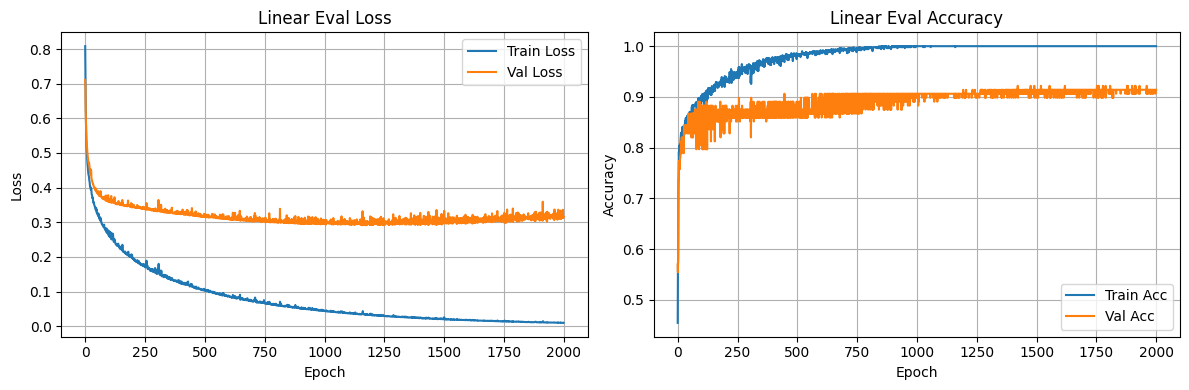

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(lin_train_losses, label='Train Loss')
plt.plot(lin_val_losses, label='Val Loss')
plt.title('Linear Eval Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(lin_train_accs, label='Train Acc')
plt.plot(lin_val_accs, label='Val Acc')
plt.title('Linear Eval Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

# TEST

In [15]:
classifier.eval()
test_labels_all, test_probs_all, test_preds_all = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = enc_linear(imgs)
        logits = classifier(feats)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)
        test_labels_all.append(labels.cpu().numpy())
        test_probs_all.append(probs.cpu().numpy())
        test_preds_all.append(preds.cpu().numpy())

test_labels_all = np.concatenate(test_labels_all)
test_probs_all = np.concatenate(test_probs_all)
test_preds_all = np.concatenate(test_preds_all)

print("\nTest Classification Report:")
print(classification_report(test_labels_all, test_preds_all, target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))


Test Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.87      0.88      0.87      1142
   Others_augmented       0.90      0.89      0.90      1412

           accuracy                           0.89      2554
          macro avg       0.88      0.88      0.88      2554
       weighted avg       0.89      0.89      0.89      2554



# TEST VISUALIZATION

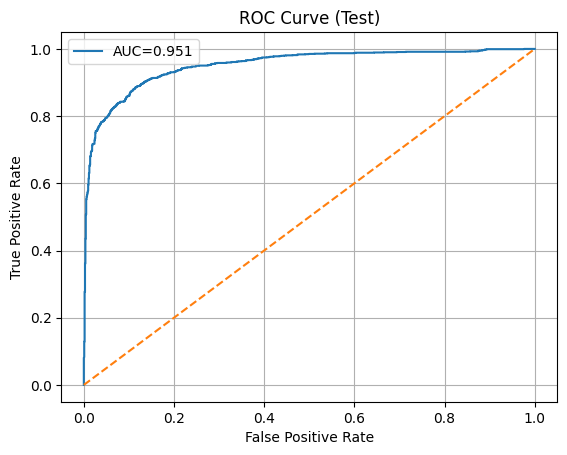

t-SNE (test features)...


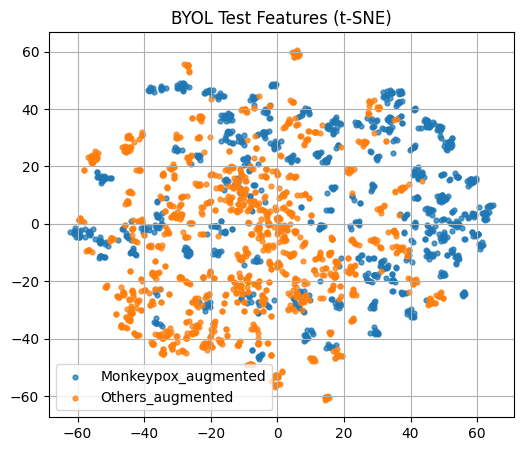

In [16]:
#ROC CURVE
fpr, tpr, _ = roc_curve(test_labels_all, test_probs_all[:,1])
auc = roc_auc_score(test_labels_all, test_probs_all[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)"); plt.grid(True); plt.legend(); plt.show()

# t-SNE on TEST features
print("t-SNE (test features)...")
test_encoder = enc_linear  # same encoder used for downstream
test_feats, test_labs = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        h = test_encoder(imgs)
        test_feats.append(h.cpu().numpy()); test_labs.append(labels.numpy())
test_feats = np.concatenate(test_feats); test_labs = np.concatenate(test_labs)

tsne_test = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_test_2d = tsne_test.fit_transform(test_feats)
plt.figure(figsize=(6,5))
for c in np.unique(test_labs):
    idx = test_labs == c
    plt.scatter(tsne_test_2d[idx,0], tsne_test_2d[idx,1], s=12, alpha=0.75, label=IDX_TO_CLASS[c])
plt.legend(); plt.title("BYOL Test Features (t-SNE)"); plt.grid(True); plt.show()